In [1]:
import mne
import sys
import os
import random
sys.path.append('D:/s.velut/Documents/Thèse/Protheus_PHD/Scripts')
from Wavelets.Green_files.green.data_utils import EpochsDataset
from Wavelets.Green_files.green.wavelet_layers import RealCovariance, PW_PLV
import torch
from tensorflow import keras
from scipy import stats

from EEG2CodeKeras import (basearchi,
                           basearchitest_batchnorm,
                           basearchi_patchembedding,
                           basearchi_patchembeddingdilation,
                           trueVanilliaEEG2Code,
                           vanilliaEEG2Code,
                           vanilliaEEG2Code2,
                           EEGnet_Inception)

from Wavelets.Green_files.research_code.pl_utils import get_green
from Wavelets.Green_files.tests.conftest import make_one_dummy_epoch

mne.set_log_level('ERROR')

In [2]:
from utils import get_BVEP_data, prepare_data, balance
from _utils import make_preds_accumul_aggresive
sys.path.append('D:/s.velut/Documents/Thèse/Protheus_PHD/Scripts/Wavelets/Jade/')
sys.path.insert(0,"D:/s.velut/Documents/Thèse/moabb/moabb/datasets")
sys.path.insert(0,"D:/s.velut/Documents/Thèse/Protheus_PHD/Scripts/SPDNet")
sys.path.insert(0,"D:/s.velut/Documents/Thèse/moabb/moabb/paradigms")
import numpy as np
from copy import deepcopy
import time
from sklearn.pipeline import make_pipeline
from pyriemann.utils.mean import mean_covariance
from sklearn.metrics.pairwise import cosine_similarity
from pyriemann.tangentspace import TangentSpace
from pyriemann.estimation import Xdawn, XdawnCovariances, covariances_EP
from sklearn.metrics import balanced_accuracy_score,f1_score,recall_score,confusion_matrix
from sklearn.model_selection import train_test_split
from SPDNet.SPD_tensorflow.optimizer import riemannian_adam
from SPDNet.SPD_torch.optimizers import riemannian_adam as torch_riemannian_adam
from Alignments.covariance import compute_covariances
from Alignments.riemannian import compute_riemannian_alignment,compute_ref_riemann
from Alignments.aligner import Aligner
from torch.utils.data import DataLoader, TensorDataset

from skimage.measure import block_reduce
from pyriemann.utils.distance import distance
from sklearn.preprocessing import normalize



from castillos2023 import CasitllosBurstVEP100

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


# Avec MOABB

In [ ]:
# get data

subjects = [1,2,3]
# subjects = [1,2,3,4,5,6,7,8,9,10,11,12]

nb_subject = len(subjects)
moabb_ds = CasitllosBurstVEP100()

on_frame = True
recenter = False
window_size=0.5

raw_data,labels,codes,labels_codes = get_BVEP_data(subjects,on_frame,to_keep=None,moabb_ds=moabb_ds,window_size=window_size)
X_parent,Y_parent,domains_parent = prepare_data(subjects,raw_data,labels,on_frame,False,recenter,codes,window_size=window_size)
X_parent.shape

Choosing the first None classes from all possible events.


None
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
[1, 2, 3]
[1, 2, 3]
['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz', 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2', 'stim_trial', 'stim_epoch']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'stim_trial', 'stim_epoch']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'stim_trial', 'stim_epoch']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


(3, 7020, 32, 251)

In [4]:
X_parent.shape

(3, 7020, 32, 126)

In [5]:
n = 3
n_epochs = 10
dataset = EpochsDataset(
    epochs=[make_one_dummy_epoch(n_epochs) for i in range(n)],
    targets=torch.Tensor([[0,1], [0,1],[0,1], [0,1],[0,1], [0,1],[0,1], [0,1],[0,1], [0,1]] * n).to(torch.float64),
    subjects=[f'subject_{i}' for i in range(n)],
    n_epochs=n_epochs,
)
dataset[0][0].shape

torch.Size([10, 32, 126])

In [6]:
torch.Tensor([[0,1], [0,1],[0,1], [0,1],[0,1], [0,1],[0,1], [0,1],[0,1], [0,1]] * n).to(torch.float64).shape

torch.Size([30, 2])

In [6]:
n = X_parent.shape[1]
Y = np.concatenate(np.array([[[0,1] if (y >= 0.5) else [1,0] for y in Y_parent[j]] for j in range(len(subjects))]))

dataset = EpochsDataset(
    epochs=mne.EpochsArray(np.concatenate(X_parent),info=mne.create_info(
                                        ch_names=[str(i) for i in range(32)],
                                        sfreq=500,
                                        ch_types='eeg')),
    targets=torch.Tensor(Y).to(torch.float64),
    subjects=subjects,
    n_epochs=n,
)
dataset

EpochsDataset
len: 21060
n_epochs/sample: 7020
num_channels/sample: 32
sampling frequency: 500.0
epoch duration (s): 0.5
padding: repeat
shuffle: False
random_state: Generator(PCG64)
use age: None

In [8]:
Y.shape

(21060, 2)

In [9]:
# model = get_green(
#     n_freqs=2,
#     kernel_width_s=.5,
#     n_ch=3,
#     sfreq=500,
#     orth_weights=True,
#     dropout=.5,
#     hidden_dim=[8],
#     logref='logeuclid',
#     pool_layer=PW_PLV(),
#     bi_out=[2],
#     dtype=torch.float32,
#     use_age=False,
#     out_dim=2
# )
# model_pl = GreenClassifierLM(model=model,)
# model_pl

In [7]:
model = get_green(
    n_freqs=4,
    kernel_width_s=.25,
    n_ch=32,
    sfreq=500,
    orth_weights=False,
    dropout=.5,
    hidden_dim=[8],
    logref='logeuclid',
    pool_layer=PW_PLV(),
    bi_out=[4],
    dtype=torch.float32,
    out_dim=2,
    use_age=False,
)
model_pl = GreenClassifierLM(model=model,
                            criterion=torch.nn.CrossEntropyLoss(),)
model_pl

GreenClassifierLM(
  (model): Green(
    (conv_layers): Sequential(
      (0): ComplexWavelet(kernel_width_s=0.25, sfreq=500, n_wavelets=4, stride=5, padding=0, scaling=oct)
    )
    (pooling_layers): PW_PLV()
    (spd_layers): Sequential(
      (0): LedoitWold(n_freqs=4, init_shrinkage=-3.0, learnable=True)
      (1): BiMap(d_in=32, d_out=4, n_freqs=4
    )
    (proj): LogEig(ref=logeuclid, reg=0.0001, n_freqs=4, size=4
    (head): Sequential(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=64, out_features=8, bias=True)
      (3): GELU(approximate='none')
      (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.5, inplace=False)
      (6): Linear(in_features=8, out_features=2, bias=True)
    )
  )
  (criterion): CrossEntropyLoss()
)

In [11]:
pl_crossval_output, _ = pl_crossval(
    model, 
    dataset=dataset,
    n_epochs=25,
    save_preds=True,
    ckpt_prefix='checkpoints/test',
    train_splits=[[0,1,2,3,4,5,6,7]],
    test_splits=[[8]],
    batch_size=64,
    pl_module=GreenClassifierLM,
    num_workers=0, 
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A1000 6GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424

validation 0
shape ypred et ytrue torch.Size([1, 2]) torch.Size([1, 2])
ypred et ytrue tensor([[-0.7690,  0.2440]], device='cuda:0') tensor([[1., 0.]], device='cuda:0', dtype=torch.float64)
1.0


c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Finding best initial lr:   0%|          | 0/20 [00:00<?, ?it/s]

training


Finding best initial lr:   5%|▌         | 1/20 [00:25<08:10, 25.82s/it]

validation 0
shape ypred et ytrue torch.Size([1, 2]) torch.Size([1, 2])
ypred et ytrue tensor([[-0.6825,  0.2094]], device='cuda:0') tensor([[1., 0.]], device='cuda:0', dtype=torch.float64)
1.0


c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


training


Finding best initial lr:  10%|█         | 2/20 [01:19<12:40, 42.26s/it]

validation 0
shape ypred et ytrue torch.Size([1, 2]) torch.Size([1, 2])
ypred et ytrue tensor([[-0.5910,  0.1727]], device='cuda:0') tensor([[1., 0.]], device='cuda:0', dtype=torch.float64)
1.0


c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


training


c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many work

pred_acc =  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.146393060684204
       test_score                   0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
dataset.epochs

Number of events,21060
Events,1: 21060
Time range,0.000 – 0.250 s
Baseline,off


In [8]:
from moabb.evaluations import WithinSessionEvaluation, CrossSubjectEvaluation
from moabb.paradigms import CVEP
from sklearn.pipeline import make_pipeline
from braindecode import EEGClassifier
from braindecode.models import EEGNetv4
from sklearn.pipeline import make_pipeline
from skorch.callbacks import EarlyStopping, EpochScoring
from skorch.dataset import ValidSplit

from moabb.datasets import BNCI2014_001
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import MotorImagery
from moabb.utils import setup_seed

In [9]:
# Set random seed to be able to reproduce results
seed = 42
setup_seed(seed)

# Hyperparameter
LEARNING_RATE = 0.0625 * 0.01  # parameter taken from Braindecode
WEIGHT_DECAY = 0  # parameter taken from Braindecode
BATCH_SIZE = 64  # parameter taken from BrainDecode
EPOCH = 10
PATIENCE = 3
fmin = 4
fmax = 100
tmin = 0
tmax = None

# Define a Skorch classifier
clf = EEGClassifier(
    module=model,
    optimizer=torch.optim.Adam,
    optimizer__lr=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    max_epochs=EPOCH,
    train_split=ValidSplit(0.2, random_state=seed),
    device="cuda",
    callbacks=[
        EarlyStopping(monitor="valid_loss", patience=PATIENCE),
        EpochScoring(
            scoring="accuracy", on_train=True, name="train_acc", lower_is_better=False
        ),
        EpochScoring(
            scoring="accuracy", on_train=False, name="valid_acc", lower_is_better=False
        ),
    ],
    verbose=1,  # Not printing the results for each epoch
)

# Create the pipelines
pipes = {}
pipes["Green"] = make_pipeline(clf)

In [10]:

paradigm = CVEP()
dataset = [CasitllosBurstVEP100()]


evaluation = WithinSessionEvaluation(
    paradigm=paradigm, datasets=dataset, suffix="examples", overwrite=False
)
results = evaluation.process(pipes)

Choosing the first None classes from all possible events.
CasitllosBurstVEP100-WithinSession:   0%|          | 0/12 [00:00<?, ?it/s]

le sujet est 1
get the data
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
start cv
No hdf5_path provided, models will not be saved.
grid search start
cv est finie
cross validate
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3538        0.7697       0.8221        7.6826  5.0076
      2       0.5192        0.6922       0.8221      229.0211  0.5524
      3       0.7154        0.6172       0.8221      868.0827  0.5497
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3275        0.7706       0.1842       10.8679  0.5259
      2       0.5116        0.6938       0.1842      410.2107  0.5242
      3       0.7098        0.6135       0.1842     3756.7553  0.5267
Stopping since valid_loss has not 

CasitllosBurstVEP100-WithinSession:   8%|▊         | 1/12 [00:26<04:46, 26.04s/it]

Stopping since valid_loss has not improved in the last 3 epochs.
return res
le sujet est 2
get the data
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
start cv
No hdf5_path provided, models will not be saved.
grid search start
cv est finie
cross validate
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3484        0.7681       0.1779       35.4138  0.8176
      2       0.5301        0.6902       0.8221      182.2675  0.5290
      3       0.7094        0.6143       0.8221      112.5674  0.5260
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3283        0.7697       0.8247        7.4649  0.5494
      2       0.5221        0.6906       0.1753     3602.7817  0.5276
      3       0.7237        

CasitllosBurstVEP100-WithinSession:  17%|█▋        | 2/12 [00:45<03:41, 22.14s/it]

le sujet est 3
get the data
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
start cv
No hdf5_path provided, models will not be saved.
grid search start
cv est finie
cross validate
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3475        0.7678       0.1548       21.1013  0.7922
      2       0.5304        0.6900       0.1548     1135.9080  0.5928
      3       0.7040        0.6218       0.1548      211.9135  0.6252
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3388        0.7671       0.1601       14.4414  0.7222
      2       0.5388        0.6864       0.1601      301.8501  0.7338
      3       0.7092        0.6194       0.8399     1377.3352  0.7674
Stopping since valid_loss has not 

CasitllosBurstVEP100-WithinSession:  25%|██▌       | 3/12 [01:06<03:16, 21.80s/it]

le sujet est 4
get the data
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
start cv
No hdf5_path provided, models will not be saved.
grid search start
cv est finie
cross validate
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3413        0.7682       0.1797        2.0585  0.7043
      2       0.5237        0.6926       0.8203        6.1535  0.6138
      3       0.7147        0.6179       0.1797      335.0947  0.6186
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3498        0.7679       0.8319        2.0918  0.5597
      2       0.5150        0.6913       0.1681     1336.6867  0.5831
      3       0.7051        0.6149       0.8319      182.9739  0.6088
Stopping since valid_loss has not 

CasitllosBurstVEP100-WithinSession:  33%|███▎      | 4/12 [01:25<02:45, 20.69s/it]

Stopping since valid_loss has not improved in the last 3 epochs.
return res
le sujet est 5
get the data
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
start cv
No hdf5_path provided, models will not be saved.
grid search start
cv est finie
cross validate
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3172        0.7720       0.1797       20.0817  0.7892
      2       0.5201        0.6901       0.8203      105.4492  0.5668
      3       0.7219        0.6110       0.1797      747.9804  0.5663
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3420        0.7692       0.1779       24.5045  0.5362
      2       0.5241        0.6905       0.8221      744.1621  0.5568
      3       0.7230        

CasitllosBurstVEP100-WithinSession:  42%|████▏     | 5/12 [01:44<02:19, 19.96s/it]

Stopping since valid_loss has not improved in the last 3 epochs.
return res
le sujet est 6
get the data
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\


C:\Users\s.velut\Documents\These\moabb\moabb\datasets\castillos2023.py:129: RuntimeWarning: Data file name in EEG.data (P13_burst100.fdt) is incorrect, the file name must have changed on disk, using the correct file name (P6_burst100.fdt).
  raw = mne.io.read_raw_eeglab(file_path_list[0], preload=True, verbose=False)


start cv
No hdf5_path provided, models will not be saved.
grid search start
cv est finie
cross validate
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3275        0.7686       0.1877        7.7937  0.7882
      2       0.5297        0.6873       0.1877     3815.1727  0.5676
      3       0.7252        0.6105       0.1877     2086.8965  0.5791
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3625        0.7657       0.1601        1.4006  0.5533
      2       0.5145        0.6917       0.8399      284.2771  0.5545
      3       0.7036        0.6187       0.8399      319.2554  0.6246
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_acc    train_loss    valid_acc    valid_loss     

CasitllosBurstVEP100-WithinSession:  50%|█████     | 6/12 [02:03<01:56, 19.50s/it]

le sujet est 7
get the data
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
start cv
No hdf5_path provided, models will not be saved.
grid search start
cv est finie
cross validate
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3355        0.7698       0.8203        6.4873  0.7715
      2       0.5217        0.6934       0.1797     1648.9735  0.5384
      3       0.7181        0.6131       0.1797     3951.8921  0.5458
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3408        0.7683       0.1610       49.3810  0.5657
      2       0.5179        0.6923       0.1610     1429.8317  0.5476
      3       0.7078        0.6200       0.8390      182.5405  0.5598
Stopping since valid_loss has not 

CasitllosBurstVEP100-WithinSession:  58%|█████▊    | 7/12 [02:25<01:42, 20.42s/it]

le sujet est 8
get the data
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
start cv
No hdf5_path provided, models will not be saved.
grid search start
cv est finie
cross validate
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3406        0.7686       0.8212        3.6106  0.7736
      2       0.5270        0.6921       0.1788     1105.8186  0.5768
      3       0.7225        0.6190       0.8212       96.8083  0.5810
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3478        0.7670       0.1646       23.3157  0.5750
      2       0.5165        0.6927       0.1646     2168.4011  0.5873
      3       0.7069        0.6187       0.1646     1689.2294  0.5903
Stopping since valid_loss has not 

CasitllosBurstVEP100-WithinSession:  67%|██████▋   | 8/12 [02:45<01:21, 20.30s/it]

le sujet est 9
get the data
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
start cv
No hdf5_path provided, models will not be saved.
grid search start
cv est finie
cross validate
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3393        0.7690       0.8443        1.6905  0.7493
      2       0.5143        0.6929       0.1557      658.8522  0.5723
      3       0.7172        0.6190       0.1557     1925.6755  0.5685
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3446        0.7682       0.1699        9.2919  0.5801
      2       0.5165        0.6932       0.8301      207.5981  0.5534
      3       0.7071        0.6224       0.1699      242.7426  0.5620
Stopping since valid_loss has not 

CasitllosBurstVEP100-WithinSession:  75%|███████▌  | 9/12 [03:04<00:59, 19.93s/it]

le sujet est 10
get the data
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
start cv
No hdf5_path provided, models will not be saved.
grid search start
cv est finie
cross validate
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3230        0.7680       0.8123        3.7347  0.7927
      2       0.5234        0.6920       0.8123      741.0393  0.5556
      3       0.7270        0.6122       0.1877     1809.0810  0.5456
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3326        0.7699       0.1690       19.0549  0.5814
      2       0.5308        0.6885       0.8310       82.6642  0.5480
      3       0.7225        0.6146       0.1690      393.8340  0.5520
Stopping since valid_loss has not

CasitllosBurstVEP100-WithinSession:  83%|████████▎ | 10/12 [03:23<00:39, 19.56s/it]

le sujet est 11
get the data
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
start cv
No hdf5_path provided, models will not be saved.
grid search start
cv est finie
cross validate
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3326        0.7685       0.8141       18.3613  0.7336
      2       0.5268        0.6881       0.8141      317.1253  0.5590
      3       0.7201        0.6160       0.8141      230.3204  0.5449
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3319        0.7696       0.8283        2.7670  0.5633
      2       0.5194        0.6921       0.8283       99.1806  0.5791
      3       0.7268        0.6173       0.1717     1020.5210  0.5560
Stopping since valid_loss has not

CasitllosBurstVEP100-WithinSession:  92%|█████████▏| 11/12 [03:42<00:19, 19.32s/it]

le sujet est 12
get the data
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
start cv
No hdf5_path provided, models will not be saved.
grid search start
cv est finie
cross validate
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3388        0.7673       0.8399        6.3398  0.7213
      2       0.5239        0.6935       0.1601     1373.8409  0.5530
      3       0.7063        0.6193       0.1601     1419.7458  0.5594
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3471        0.7663       0.1619       25.2622  0.5692
      2       0.5261        0.6940       0.1619      764.3405  0.5834
      3       0.7089        0.6223       0.8381       53.3334  0.5585
Stopping since valid_loss has not

CasitllosBurstVEP100-WithinSession: 100%|██████████| 12/12 [04:00<00:00, 20.07s/it]


In [ ]:
results

,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.697436,7.589004,7020.0,1,0,32,1,CasitllosBurstVEP100,Green
1,0.829060,8.038203,7020.0,2,0,32,1,CasitllosBurstVEP100,Green
2,0.829060,8.169000,7020.0,3,0,32,1,CasitllosBurstVEP100,Green
3,0.829060,10.290387,7020.0,4,0,32,1,CasitllosBurstVEP100,Green
4,0.829060,9.395892,7020.0,5,0,32,1,CasitllosBurstVEP100,Green
5,0.829060,7.266255,7020.0,6,0,32,1,CasitllosBurstVEP100,Green
6,0.829060,6.603435,7020.0,7,0,32,1,CasitllosBurstVEP100,Green
7,0.697436,10.050620,7020.0,8,0,32,1,CasitllosBurstVEP100,Green
8,0.829060,10.584088,7020.0,9,0,32,1,CasitllosBurstVEP100,Green
9,0.829060,8.627160,7020.0,10,0,32,1,CasitllosBurstVEP100,Green


In [ ]:

paradigm = CVEP()
dataset = [CasitllosBurstVEP100()]

cross_evaluation = CrossSubjectEvaluation(
    paradigm=paradigm, datasets=dataset, suffix="examples", overwrite=False
)
cross_results = cross_evaluation.process(pipes)

Choosing the first None classes from all possible events.


C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\


KeyboardInterrupt: 

In [ ]:
cross_results

,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.82906,137.261841,77220.0,1,0,32,1,CasitllosBurstVEP100,Green
1,0.82906,177.490524,77220.0,2,0,32,1,CasitllosBurstVEP100,Green
2,0.82906,137.546021,77220.0,3,0,32,1,CasitllosBurstVEP100,Green
3,0.82906,144.890167,77220.0,4,0,32,1,CasitllosBurstVEP100,Green
4,0.82906,105.100517,77220.0,5,0,32,1,CasitllosBurstVEP100,Green
5,0.82906,143.653839,77220.0,6,0,32,1,CasitllosBurstVEP100,Green
6,0.82906,105.876099,77220.0,7,0,32,1,CasitllosBurstVEP100,Green
7,0.82906,101.209442,77220.0,8,0,32,1,CasitllosBurstVEP100,Green
8,0.82906,211.256851,77220.0,9,0,32,1,CasitllosBurstVEP100,Green
9,0.82906,104.882607,77220.0,10,0,32,1,CasitllosBurstVEP100,Green


# OWN

In [4]:
# get data

on_frame = False
recenter = False
window_size=0.35
# subjects = [1,2,3]
subjects = [1,2,3,4,5,6,7,8,9,10,11,12]

nb_subject = len(subjects)
keep = ["O1", "O2", "Oz", "P7", "P3", "P4", "P8", "Pz","stim_trial","stim_epoch"]
# keep = None
moabb_ds = CasitllosBurstVEP100(window_size=window_size)



raw_data,labels,codes,labels_codes = get_BVEP_data(subjects,on_frame,to_keep=keep,moabb_ds=moabb_ds,window_size=window_size)
X_parent,Y_parent,domains_parent = prepare_data(subjects,raw_data,labels,on_frame,False,recenter,codes,window_size=window_size)
X_parent.shape

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 50 - 50 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 49.90, 50.10 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 50 - 50 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 49.90, 50.10 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 50 - 50 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 49.90, 50.10 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up b

(12, 55500, 8, 175)

In [5]:
model = get_green(
            n_freqs=20,
                kernel_width_s=window_size,
                n_ch=8,
                sfreq=500,
                oct_min=0,
                oct_max=4.5,
                orth_weights=False,
                dropout=.7,
                hidden_dim=[20,10],
                logref='logeuclid',
                pool_layer=RealCovariance(),
                bi_out=[4],
                dtype=torch.float32,
                out_dim=2,
            )

model

Green(
  (conv_layers): Sequential(
    (0): ComplexWavelet(kernel_width_s=0.35, sfreq=500, n_wavelets=20, stride=5, padding=0, scaling=oct)
  )
  (pooling_layers): RealCovariance()
  (spd_layers): Sequential(
    (0): LedoitWold(n_freqs=20, init_shrinkage=-3.0, learnable=True)
    (1): BiMap(d_in=8, d_out=4, n_freqs=20
  )
  (proj): LogEig(ref=logeuclid, reg=0.0001, n_freqs=20, size=4
  (head): Sequential(
    (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): Linear(in_features=200, out_features=20, bias=True)
    (3): GELU(approximate='none')
    (4): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.7, inplace=False)
    (6): Linear(in_features=20, out_features=10, bias=True)
    (7): GELU(approximate='none')
    (8): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.7, inplace=False)
    (10): Linea

### classification

In [58]:
n_cal = 7
n_class = 5
nb_fold = 1
spdbn_accuracy_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_train_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_test_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_pred_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_accuracy_perso = np.zeros((nb_fold,nb_subject))
spdbn_recall_perso = np.zeros((nb_fold,nb_subject))
spdbn_f1_perso = np.zeros((nb_fold,nb_subject))
path = '/'.join(['D:/s.velut/Documents/Thèse/Protheus_PHD/Data/STL',"ws"+str(window_size),"time_sample","data/test",''])

# nb_subject = 13

for k in range(nb_fold):
    for i in range(nb_subject):
        print("TL to the participant : ", i)
        X = X_parent.copy()
        Y = Y_parent.copy()
        domains = domains_parent.copy()
        nb_sample_cal = int(n_class*n_cal*(2.2-window_size)*500)
        

        # preprocessDA
        X = np.zeros((X_parent.shape[0],X_parent.shape[1],8,X_parent.shape[3]))
        for j in range(nb_subject):
            xdawn = Xdawn(nfilter=4,classes=[1],estimator='lwf')
            if j==i:
                X_std = X_parent[j][:nb_sample_cal].std(axis=0)
                temp_X = X_parent[j]/(X_std + 1e-8)
                xdawn = xdawn.fit(temp_X[:nb_sample_cal],Y[j][:nb_sample_cal])
                temp_X_train = xdawn.transform(temp_X[:nb_sample_cal])
                temp_Xtest = xdawn.transform(temp_X[nb_sample_cal:])
                X[j][:nb_sample_cal] = np.hstack([temp_X_train,np.tile(xdawn.evokeds_[None,:,:],(temp_X_train.shape[0],1,1))])
                X[j][nb_sample_cal:] = np.hstack([temp_Xtest,np.tile(xdawn.evokeds_[None,:,:],(temp_Xtest.shape[0],1,1))])
                rmean = mean_covariance(compute_covariances(X[j][:nb_sample_cal], estimator='lwf'), metric='riemann')
                X[j] = compute_riemannian_alignment(X[j], mean=rmean, dtype='real')

            else:
                X_std = X_parent[j].std(axis=0)
                temp_X = X_parent[j]/(X_std + 1e-8)
                xdawn = xdawn.fit(temp_X,Y[j])
                temp_X = xdawn.transform(temp_X)
                X[j] = np.hstack([temp_X,np.tile(xdawn.evokeds_[None,:,:],(temp_X.shape[0],1,1))])
                X[j] = compute_riemannian_alignment(X[j], mean=None, dtype='real')
                # X[j] = np.load(path+"full_preprocess_data_"+subjects[j]+".npy")
        # # DA
        n_cal = 4
        nb_sample_cal = int(n_class*n_cal*(2.2-window_size)*500)
        ind2take = [random.choice([j for j in range(len(subjects)) if j!=i]),random.choice([j for j in range(len(subjects)) if j!=i])]
        # ind2take = [j for j in range(6) if j!=i]
        X_train = np.concatenate([np.concatenate(X[ind2take]).reshape(-1,X.shape[-2],X.shape[-1]),X[i][:nb_sample_cal]]).reshape(-1,X.shape[-2],X.shape[-1])
        Y_train = np.concatenate([np.concatenate(Y[ind2take]).reshape(-1),Y[i][:nb_sample_cal]]).reshape(-1)
        X_test = X[i][nb_sample_cal:]
        Y_test = Y[i][nb_sample_cal:]
        labels_code_test = labels_codes[i][(n_class*4):]
        domains_train = np.concatenate([np.concatenate(domains[ind2take]).reshape(-1),domains[i][:nb_sample_cal]]).reshape(-1)
        domain_test = domains[i][nb_sample_cal]

        # Xs = np.concatenate(np.array([np.load(path+"full_preprocess_data_"+p+".npy") for p in subjects if p!=participants[i] ])).reshape(-1,X_parent.shape[-2],X_parent.shape[-1])
        # Xtarget = np.load(path+"full_solo_preprocess_data_"+participants[i]+".npy")
        # n_cal = 4
        # # Initialisation
        # nb_sample_cal = int(n_class*n_cal*(2.2-window_size)*freqwise)

        # # Get the training data
        # ind2take = [j for j in range(nb_subject) if j!=i]
        # X_train = np.concatenate([Xs,Xtarget[:nb_sample_cal]]).reshape(-1,Xs.shape[-2],Xs.shape[-1])
        # Y_train = np.concatenate([np.concatenate(Y[ind2take]).reshape(-1),Y[i][:nb_sample_cal]]).reshape(-1)
        # domains_train = np.concatenate([np.concatenate(domains_parent[ind2take]).reshape(-1),domains_parent[i][:nb_sample_cal]]).reshape(-1)
        # X_test = Xtarget[nb_sample_cal:]
        # Y_test = Y[i][nb_sample_cal:]
        # labels_code_test = labels_code_list[i][(n_class*n_cal):]
                    
        

        ## DG
        # X = X_parent.copy()
        # ind2take = [j for j in range(len(participants)) if j!=i]
        # X_train = np.concatenate(X[ind2take]).reshape(-1,X.shape[-2],X.shape[-1])
        # Y_train = np.concatenate(Y[ind2take]).reshape(-1)
        # X_test = X[i]
        # Y_test = Y[i]
        # labels_code_test = labels_code_list[i]
        # domains_train = np.concatenate(domains[ind2take]).reshape(-1)
        # #preprocessDG
        # X_std = X_train.std(axis=0)
        # X_train /= X_std + 1e-8
        # X_std = X_test.std(axis=0)
        # X_test /= X_std + 1e-8
        # xdawn = Xdawn(nfilter=8,classes=[1],estimator='lwf')
        # xdawn = xdawn.fit(X_train, Y_train)
        # X_train = xdawn.transform(X_train)
        # X_test = xdawn.transform(X_test)
        # X_train = np.hstack([X_train,np.tile(xdawn.evokeds_[None,:,:],(X_train.shape[0],1,1))])
        # X_test = np.hstack([X_test,np.tile(xdawn.evokeds_[None,:,:],(X_test.shape[0],1,1))])
        # rmean = mean_covariance(compute_covariances(X_train, estimator='lwf'), metric='riemann')
        # X_train = compute_riemannian_alignment(X_train,mean=rmean,dtype='real')
        # X_test = compute_riemannian_alignment(X_test,mean=rmean,dtype='real')
        

        #preprocessSS
        # n_cal = 7
        # nb_sample_cal = int(n_class*n_cal*(2.2-window_size)*freqwise)
        
        # xdawn = Xdawn(nfilter=4,classes=[1],estimator='lwf')
        # xdawn = xdawn.fit(X_parent[i][:nb_sample_cal],Y[i][:nb_sample_cal])
        # temp_X = xdawn.transform(X_parent[i][:nb_sample_cal])
        # temp_Xtest = xdawn.transform(X_parent[i][nb_sample_cal:])
        # X[i][:nb_sample_cal] = np.hstack([temp_X,np.tile(xdawn.evokeds_[None,:,:],(temp_X.shape[0],1,1))])
        # X[i][nb_sample_cal:] = np.hstack([temp_Xtest,np.tile(xdawn.evokeds_[None,:,:],(temp_Xtest.shape[0],1,1))])
        # rmean = mean_covariance(compute_covariances(X[i][:nb_sample_cal], estimator='lwf'), metric='riemann')
        # X[i] = compute_riemannian_alignment(X[i], mean=rmean, dtype='real')
        
        # ## SS
        # X_train = X[i][:nb_sample_cal]
        # Y_train = Y[i][:nb_sample_cal]
        # X_test = X[i][nb_sample_cal:]
        # Y_test = Y[i][nb_sample_cal:]
        # labels_code_test = labels_code_list[i][(n_class*n_cal):]
        # domains_train = domains[i][:nb_sample_cal]
        
        

        print("balancing the number of ones and zeros")
        X_train, Y_train, domains_train = balance(X_train,Y_train,domains_train)
        print(X_train.shape)
        print(Y_train.shape)
        print(X_test.shape)

        print("Creating the different pipelines")
        lr = 1e-3
        # optimizer = riemannian_adam.RiemannianAdam(learning_rate=lr)
        batchsize = 64 #128 # 64 for burst
        clf = deepcopy(model)

        print("Fitting")
        start = time.time()
        weight_decay = 1e-4
        
        x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, shuffle=True)

        # Convert data into PyTorch tensors
        X_train_tensor = torch.tensor(x_train, dtype=torch.float64)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(x_val, dtype=torch.float64)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float64)
        y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

        # Create DataLoader for train, validation, and test sets
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        val_dataloader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

        # Define loss function and optimizer
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch_riemannian_adam.RiemannianAdam(clf.parameters(), lr=lr)

        # Train the model
        num_epochs = 20

        for epoch in range(num_epochs):
            running_loss = 0.0
            train_y_pred= []
            y_train = []
            clf.train()
            for inputs, labels in train_dataloader:
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                # print(inputs.shape)
                # print(labels.shape)
                outputs = clf(inputs)
                # print(outputs.get_device())
                # print(labels.get_device())

                labels = labels.to('cpu')
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs, 1)
                train_y_pred.append(predicted.to('cpu'))
                y_train.append(labels.to('cpu'))

                running_loss += loss.item()
            
            train_accuracy = balanced_accuracy_score(np.concatenate(y_train),np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(train_y_pred)]))#train_correct / len(x_train)
            
            # Validation
            clf.eval()
            val_correct = 0
            val_y_pred = []
            with torch.no_grad():
                for inputs, labels in val_dataloader:
                    outputs = clf(inputs)
                    _, predicted = torch.max(outputs, 1)
                    predicted = predicted.to('cpu')
                    val_correct += (predicted == labels).sum().item()
                    val_y_pred.append(predicted)


            val_accuracy = balanced_accuracy_score(y_val,np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(val_y_pred)]))#val_correct / len(x_val)
            print(f"Epoch {epoch+1} train Accuracy: {train_accuracy} ||  Validation Accuracy: {val_accuracy}")

            print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_dataloader)}")

        print("Training finished!")
        print("Training accuracy :", balanced_accuracy_score(np.concatenate(y_train),np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(train_y_pred)])))
        spdbn_tps_train_code_perso[k][i] = time.time() - start

        # # Validation
        clf.eval()
        # val_correct = 0
        # val_y_pred = []
        # with torch.no_grad():
        #     for inputs, labels in val_dataloader:
        #         outputs = clf(inputs)
        #         _, predicted = torch.max(outputs, 1)
        #         predicted = predicted.to('cpu')
        #         val_correct += (predicted == labels).sum().item()
        #         val_y_pred.append(predicted)


        # val_accuracy = balanced_accuracy_score(y_val,np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(val_y_pred)]))#val_correct / len(x_val)
        # print(f"Validation Accuracy: {val_accuracy}")

        # Testing
        start = time.time()
        test_correct = 0
        y_pred= []
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = clf(inputs)
                _, predicted = torch.max(outputs, 1)
                predicted = predicted.to('cpu')
                y_pred.append(predicted)
                test_correct += (predicted == labels).sum().item()
                
        test_accuracy = test_correct / len(X_test)
        
        # print("getting accuracy of participant ", i)
        test_y_pred = np.concatenate(y_pred)

        y_pred_norm = np.array([1 if (y >= 0.5) else 0 for y in test_y_pred])
        y_test_norm = np.array([0 if y == 0 else 1 for y in Y_test])

        # tn, fp, fn, tp = confusion_matrix(y_test_norm, y_pred_norm).ravel()
        spdbn_accuracy_perso[k][i] = balanced_accuracy_score(y_test_norm,y_pred_norm)
        spdbn_recall_perso[k][i] = recall_score(y_test_norm,y_pred_norm)
        spdbn_f1_perso[k][i] = f1_score(y_test_norm,y_pred_norm)
        print(f"Test Accuracy: {spdbn_accuracy_perso[k][i]}")
        print(f"Test recall: {spdbn_recall_perso[k][i]}")
        print(f"Test f1: {spdbn_f1_perso[k][i]}")

        labels_pred_accumul, _, mean_long_accumul = make_preds_accumul_aggresive(
            y_pred_norm, codes, min_len=30, sfreq=500, consecutive=50, window_size=window_size
        )
        spdbn_tps_test_code_perso[k][i] = time.time() - start
        spdbn_accuracy_code_perso[k][i] = np.round(balanced_accuracy_score(labels_code_test[labels_pred_accumul!=-1], labels_pred_accumul[labels_pred_accumul!=-1]), 2)
        spdbn_tps_pred_code_perso[k][i] = np.mean(mean_long_accumul)
        # keras.backend.clear_session()


print(spdbn_accuracy_perso)
print(spdbn_tps_train_code_perso)
print(spdbn_tps_test_code_perso)
print(spdbn_accuracy_code_perso)
print(spdbn_tps_pred_code_perso)

spdbn_accuracy_perso = np.mean(spdbn_accuracy_perso,axis=0)
spdbn_tps_train_code_perso = np.mean(spdbn_tps_train_code_perso,axis=0)
spdbn_tps_test_code_perso = np.mean(spdbn_tps_test_code_perso,axis=0)
spdbn_accuracy_code_perso = np.mean(spdbn_accuracy_code_perso,axis=0)

print(spdbn_accuracy_perso)
print(spdbn_recall_perso)
print(spdbn_f1_perso)
print(spdbn_tps_train_code_perso)
print(spdbn_tps_test_code_perso)
print(np.mean(spdbn_tps_pred_code_perso,axis=0))
print(spdbn_accuracy_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/score/WO1_score",spdbn_accuracy_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/score_code/WO1_score_code",spdbn_accuracy_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/temps_train_code/WO1_tps_train_code",spdbn_tps_train_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/temps_test_code/WO1_tps_test_code",spdbn_tps_test_code_perso)

TL to the participant :  0
balancing the number of ones and zeros
(42070, 8, 175)
(42070,)
(37000, 8, 175)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5871763039816751 ||  Validation Accuracy: 0.8096647317397205
Epoch 1, Loss: 0.701512064543967
Epoch 2 train Accuracy: 0.7235187755823613 ||  Validation Accuracy: 0.8134838271489377
Epoch 2, Loss: 0.5605830495235131
Epoch 3 train Accuracy: 0.7604876206323469 ||  Validation Accuracy: 0.8222209560863378
Epoch 3, Loss: 0.5236695331199087
Epoch 4 train Accuracy: 0.7723928351860416 ||  Validation Accuracy: 0.8266130345071769
Epoch 4, Loss: 0.5049993198634101
Epoch 5 train Accuracy: 0.7866998614800431 ||  Validation Accuracy: 0.828008553652282
Epoch 5, Loss: 0.49128353686387094
Epoch 6 train Accuracy: 0.7908221803373094 ||  Validation Accuracy: 0.8263019833566438
Epoch 6, Loss: 0.48278452144376227
Epoch 7 train Accuracy: 0.795519258154302 ||  Validation Accuracy: 0.8332040631204913
Epoch 7, Loss: 0.4740796238750559
Epoch 

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


TL to the participant :  6
balancing the number of ones and zeros
(42070, 8, 175)
(42070,)
(37000, 8, 175)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5490677007660877 ||  Validation Accuracy: 0.7419223597219868
Epoch 1, Loss: 0.7266294226446985
Epoch 2 train Accuracy: 0.6533317876718827 ||  Validation Accuracy: 0.7721033508504266
Epoch 2, Loss: 0.6195902744513501
Epoch 3 train Accuracy: 0.7044868253019588 ||  Validation Accuracy: 0.7855734305249478
Epoch 3, Loss: 0.5698261345407355
Epoch 4 train Accuracy: 0.725346850826031 ||  Validation Accuracy: 0.7927248121150478
Epoch 4, Loss: 0.5520659154245608
Epoch 5 train Accuracy: 0.7368183090502574 ||  Validation Accuracy: 0.7954845454031756
Epoch 5, Loss: 0.5382953916212452
Epoch 6 train Accuracy: 0.7434815189017674 ||  Validation Accuracy: 0.7969760976436684
Epoch 6, Loss: 0.5323333028604775
Epoch 7 train Accuracy: 0.7505830263595663 ||  Validation Accuracy: 0.7946300502910097
Epoch 7, Loss: 0.5252314478498902
Epoch 

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


TL to the participant :  9
balancing the number of ones and zeros
(42070, 8, 175)
(42070,)
(37000, 8, 175)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5955956294310814 ||  Validation Accuracy: 0.8375837667219155
Epoch 1, Loss: 0.6914419777719694
Epoch 2 train Accuracy: 0.7493068048527474 ||  Validation Accuracy: 0.8499326928156608
Epoch 2, Loss: 0.520985094200069
Epoch 3 train Accuracy: 0.7907614284325979 ||  Validation Accuracy: 0.8559977975789754
Epoch 3, Loss: 0.4728072076016053
Epoch 4 train Accuracy: 0.8082037721116186 ||  Validation Accuracy: 0.8534393618064147
Epoch 4, Loss: 0.4512937996437341
Epoch 5 train Accuracy: 0.8177788346580905 ||  Validation Accuracy: 0.8570008088162382
Epoch 5, Loss: 0.4378340579144402
Epoch 6 train Accuracy: 0.8243449570706329 ||  Validation Accuracy: 0.8592876427964645
Epoch 6, Loss: 0.427136494009667
Epoch 7 train Accuracy: 0.8277926123971966 ||  Validation Accuracy: 0.8622092124819302
Epoch 7, Loss: 0.4211132124406303
Epoch 8

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


TL to the participant :  11
balancing the number of ones and zeros
(42070, 8, 175)
(42070,)
(37000, 8, 175)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5880685726633703 ||  Validation Accuracy: 0.7625701973527765
Epoch 1, Loss: 0.6973755424240243
Epoch 2 train Accuracy: 0.697735611402698 ||  Validation Accuracy: 0.7822614533236768
Epoch 2, Loss: 0.5669259642580163
Epoch 3 train Accuracy: 0.7317722825900812 ||  Validation Accuracy: 0.7996460633876106
Epoch 3, Loss: 0.531445209744312
Epoch 4 train Accuracy: 0.7413272485788729 ||  Validation Accuracy: 0.8052632078619226
Epoch 4, Loss: 0.5178596912794693
Epoch 5 train Accuracy: 0.7537925991070531 ||  Validation Accuracy: 0.8091673493136007
Epoch 5, Loss: 0.4984903137833447
Epoch 6 train Accuracy: 0.7602972529427978 ||  Validation Accuracy: 0.8050347358789283
Epoch 6, Loss: 0.49270388597317977
Epoch 7 train Accuracy: 0.7601622815659571 ||  Validation Accuracy: 0.8117327003252293
Epoch 7, Loss: 0.4897836761782831
Epoch

### Visu

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
X_preproc = np.zeros((X_parent.shape[0],X_parent.shape[1],8,X_parent.shape[3]))
for j in range(nb_subject):
    nb_sample_cal = int(4*4*(2.2-window_size)*500)
    xdawn = Xdawn(nfilter=4,classes=[1],estimator='lwf')

    X_std = X_parent[j][:nb_sample_cal].std(axis=0)
    temp_X = X_parent[j]/(X_std + 1e-8)
    xdawn = xdawn.fit(temp_X[:nb_sample_cal],Y_parent[j][:nb_sample_cal])
    temp_X_train = xdawn.transform(temp_X[:nb_sample_cal])
    temp_Xtest = xdawn.transform(temp_X[nb_sample_cal:])
    X_preproc[j][:nb_sample_cal] = np.hstack([temp_X_train,np.tile(xdawn.evokeds_[None,:,:],(temp_X_train.shape[0],1,1))])
    X_preproc[j][nb_sample_cal:] = np.hstack([temp_Xtest,np.tile(xdawn.evokeds_[None,:,:],(temp_Xtest.shape[0],1,1))])
    rmean = mean_covariance(compute_covariances(X_preproc[j][:nb_sample_cal], estimator='lwf'), metric='riemann')
    X_preproc[j] = compute_riemannian_alignment(X_preproc[j], mean=rmean, dtype='real')

In [20]:
Y_parent.shape

(12, 55500)

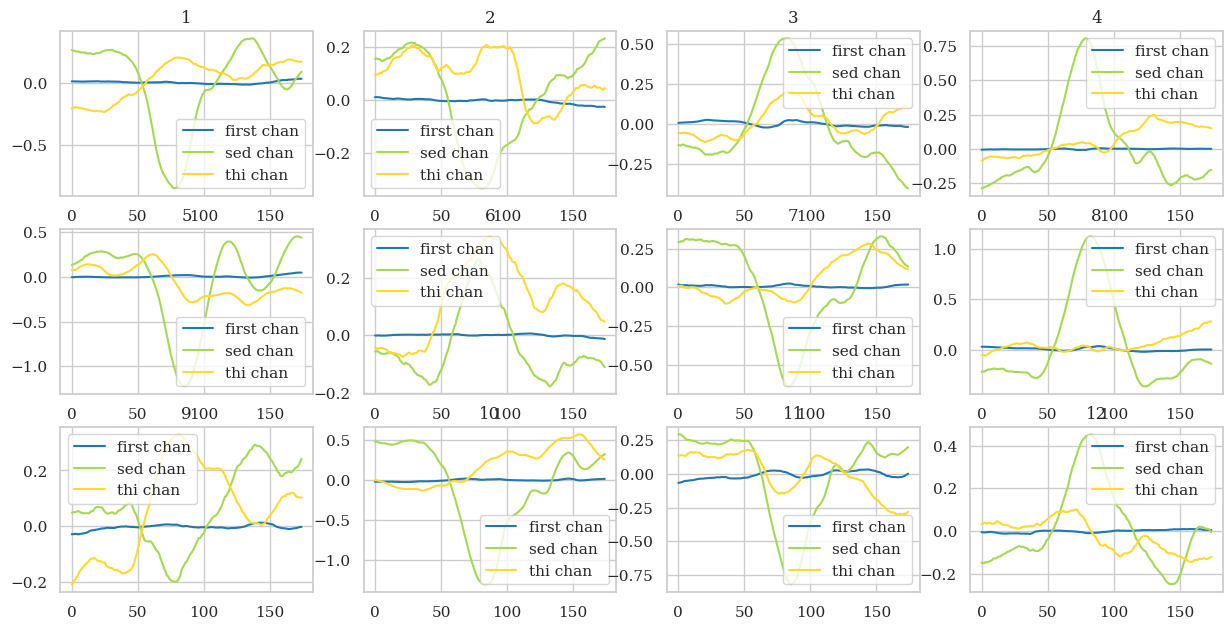

In [11]:
plt.figure(1,figsize=(15,15))
for i in range(nb_subject):
    plt.subplot(6,4,i+1)
    c = sns.color_palette("tab20", 20)[0]
    c2 = sns.color_palette("tab20", 20)[10]
    col = sns.color_palette('Set2')
    channel = 0
    
    # plt.plot(np.median(X_preroc[i][Y_parent[i]==0][:18500],axis=0)[channel],c=c2)
    # plt.plot(np.median(X_preroc[i][Y_parent[i]==0],axis=0)[channel+1],c=col[0])
    # plt.plot(np.median(X_preroc[i][Y_parent[i]==0],axis=0)[channel+2],c=col[1])
    plt.plot(np.median(X_preproc[i][Y_parent[i]==1],axis=0)[channel],c=c,label="first chan")
    plt.plot(np.median(X_preproc[i][Y_parent[i]==1],axis=0)[channel+1],c=col[4],label="sed chan")
    plt.plot(np.median(X_preproc[i][Y_parent[i]==1],axis=0)[channel+2],c=col[5],label="thi chan")
    plt.title(i+1)
    plt.legend()

dpicmax = np.zeros((12,12))

for i in range(12):
    for j in range(12):
        dpicmax[i,j] = np.abs(np.argmax(np.abs(np.mean(X_preproc[i][Y_parent[i]==1,0,:],axis=0))) - np.argmax(np.abs(np.mean(X_preproc[j][Y_parent[j]==1,0,:],axis=0))))

<Axes: >

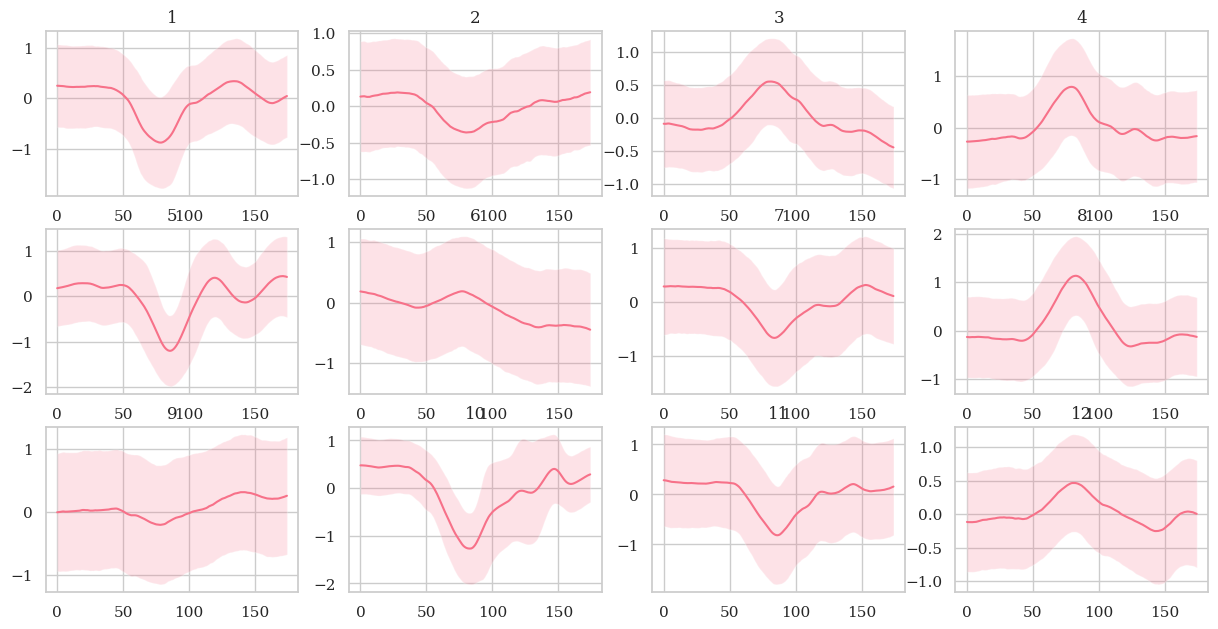

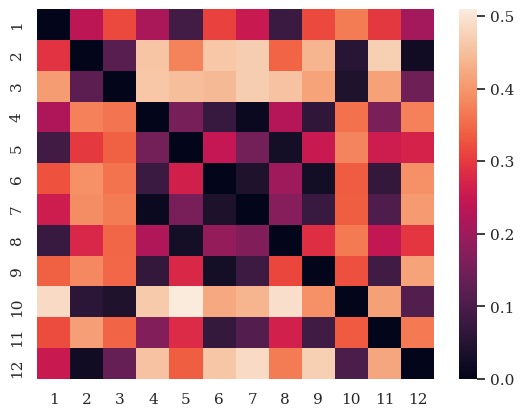

In [12]:
plt.figure(1,figsize=(15,15))
s = np.zeros((12,X_preproc.shape[-1]))
iqr = np.zeros((12,X_preproc.shape[-1]))
# iqr_c2 = np.zeros((12,X_preproc.shape[-1]))
# iqr_c3 = np.zeros((12,X_preproc.shape[-1]))
# iqr_c4 = np.zeros((12,X_preproc.shape[-1]))
for i in range(12):
    axes = plt.subplot(6,4,i+1)
    c = sns.color_palette("tab20", 20)[0]
    c2 = sns.color_palette("tab20", 20)[1]
    col = sns.color_palette('Set2')
    channel = 1

    d = np.mean(X_preproc[i][Y_parent[i]==1][:,channel,:],axis=0)
    std = np.std(X_preproc[i][Y_parent[i]==1][:,channel,:],axis=0)
    dist_iq = np.percentile(X_preproc[i][Y_parent[i]==1][:,channel,:], 75,axis=0) - np.percentile(X_preproc[i][Y_parent[i]==1][:,channel,:], 25,axis=0)
    cis = (d-dist_iq/2,d+dist_iq/2)
    plt.fill_between(np.arange(175),cis[0],cis[1], alpha=0.2)
    plt.plot(d)
    plt.title(i+1)

    s[i] = std
    iqr[i] = dist_iq
    # iqr_c2[i] = np.percentile(X_preproc[i][Y_parent[i]==1,1,:], 75,axis=0) - np.percentile(X_preproc[i][Y_parent[i]==1,1,:], 25,axis=0)
    # iqr_c3[i] = np.percentile(X_preproc[i][Y_parent[i]==1,2,:], 75,axis=0) - np.percentile(X_preproc[i][Y_parent[i]==1,2,:], 25,axis=0)
    # iqr_c4[i] = np.percentile(X_preproc[i][Y_parent[i]==1,3,:], 75,axis=0) - np.percentile(X_preproc[i][Y_parent[i]==1,3,:], 25,axis=0)

diqr = np.zeros((12,12))
for i in range(12):
    for j in range((12)):
        diqr[i,j] = np.abs(np.median(iqr[i]-iqr[j]))
plt.figure(2)
sns.heatmap(normalize(normalize(diqr),axis=0), xticklabels=subjects,yticklabels=subjects)

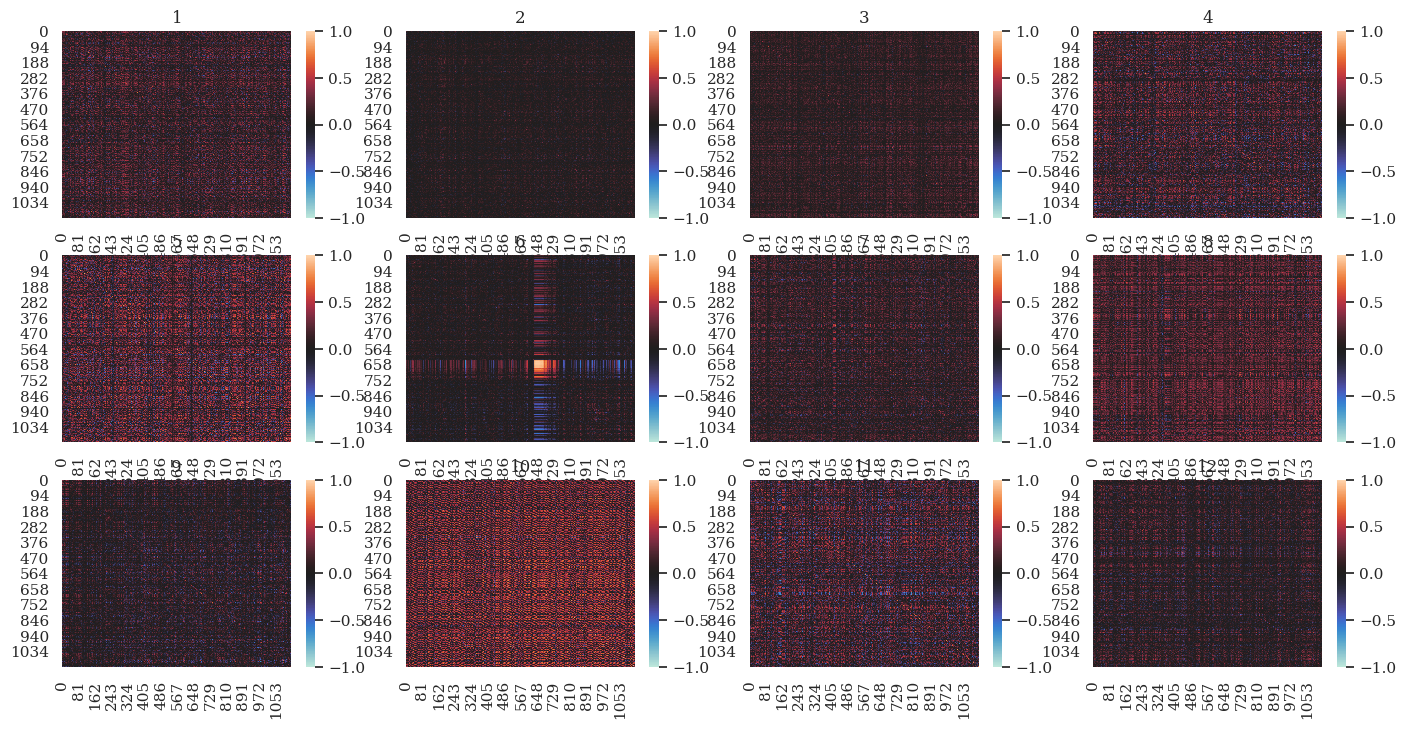

<Axes: >

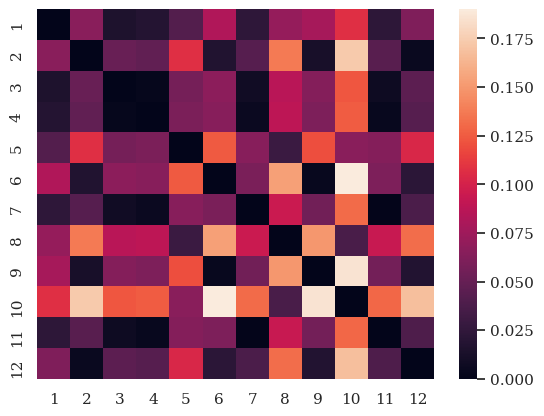

In [13]:
import math


m = np.zeros(12)
all_m = np.zeros((12,math.ceil(X_preproc[0][Y_parent[i]==1].shape[0]/8)))
all_cm = np.zeros((12,math.ceil(X_preproc[0][Y_parent[i]==1].shape[0]/8),math.ceil(X_preproc[0][Y_parent[i]==1].shape[0]/8)))
all_m2 = np.zeros((12,math.ceil(X_preproc[0][Y_parent[i]==1].shape[0]/8),math.ceil(X_preproc[0][Y_parent[i]==1].shape[0]/8)))
plt.figure(1,figsize=(17,17))
for i in range(12):
    plt.subplot(6,4,i+1)
    
    corr = stats.spearmanr(X_preproc[i][Y_parent[i]==1][:,1],axis=1)

    arr_reduced = block_reduce(corr.statistic, block_size=(8,8), func=np.median, cval=np.median(corr))
    sns.heatmap(arr_reduced,cmap='icefire', vmin=-1.0,vmax=1.0)

    m[i] = np.median(arr_reduced)
    all_cm[i] = arr_reduced
    all_m[i] = np.median(arr_reduced, axis=0)
    all_m2[i] = np.median(np.abs(arr_reduced), axis=0)
    
    plt.title(str(i+1))

plt.show()

dicmdif = np.zeros((12,12))

for i in range(12):
    for j in range(12):
        dicmdif[i,j] = np.abs(np.median((all_cm[i])) - np.median((all_cm[j])))
plt.figure(2)
sns.heatmap(dicmdif,xticklabels=subjects,yticklabels=subjects)

<Axes: >

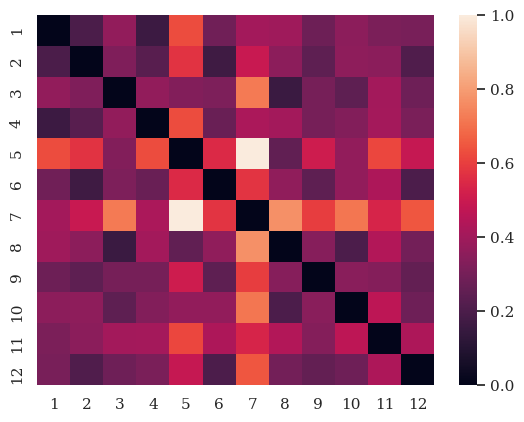

In [14]:


mr = np.zeros((12,8,8))
dmr = np.zeros((12,12))
for i in range(12):
    mr[i] = mean_covariance(compute_covariances(X_preproc[i,Y_parent[i]==1], estimator='lwf'), metric='riemann')

for i in range(12):
    dmr[:,i] = distance(mr,mr[i])[:,0]

sns.heatmap(dmr/np.max(dmr),xticklabels=subjects,yticklabels=subjects)


<Axes: >

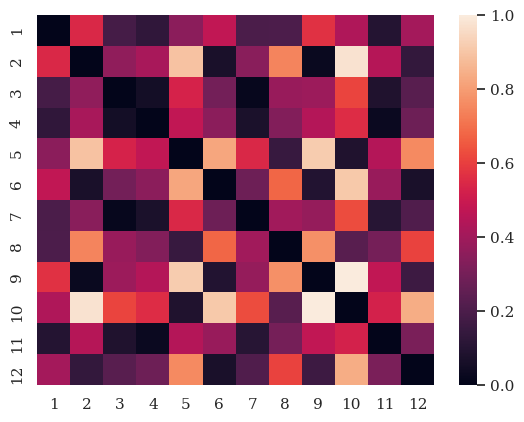

In [15]:
damp = np.zeros((12,12))

for i in range(12):
    for j in range(12):
        damp[i,j] = np.abs((np.max(np.mean(X_preproc[i][Y_parent[i]==1,1,:],axis=0)) - np.min(np.mean(X_preproc[i][Y_parent[i]==1,1,:],axis=0))) - (np.max(np.mean(X_preproc[j][Y_parent[j]==1,1,:],axis=0)) - np.min(np.mean(X_preproc[j][Y_parent[j]==1,1,:],axis=0))))

sns.heatmap(damp/np.max(damp),xticklabels=subjects,yticklabels=subjects)

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.cluster import AffinityPropagation


af = AffinityPropagation(preference=None, random_state=2, max_iter=1000,affinity='precomputed')

# temp = np.array([np.mean(datas[i][Y[i]==1,0,:],axis=0) for i in range(nb_subject)])

# temp = np.concatenate([np.array([np.mean(datas[i][Y[i]==1,0,:],axis=0) for i in range(nb_subject)]),np.array([np.mean(datas[i][Y[i]==1,1,:],axis=0) for i in range(nb_subject)]),np.array([np.mean(datas[i][Y[i]==1,2,:],axis=0) for i in range(nb_subject)])],axis=1)
# temp = np.concatenate([np.array([np.mean(datas[i][Y[i]==1,0,:],axis=0) for i in range(nb_subject)]),np.array([np.std(datas[i][Y[i]==1,0,:],axis=0) for i in range(nb_subject)])],axis=1)

# temp = np.concatenate([all_m,np.array([np.mean(datas[i][Y[i]==1,0,:],axis=0) for i in range(nb_subject)])],axis=1)
# temp = np.concatenate([normalize(all_m,axis=0),
#                        normalize(iqr,axis=0),
#                        normalize(np.array([np.median(X_preproc[i][Y[i]==1,1,:],axis=0) for i in range(nb_subject)]),axis=0), 
#                        ],axis=1)
temp = 1/np.exp(dmr/np.max(dmr))+1/np.exp(diqr/np.max(diqr))+1/np.exp(dicmdif/np.max(dicmdif))+1/np.exp(damp/np.max(damp))


# temp[1] = np.mean(datas[i][Y[i]==1,1,:],axis=0)
# temp = np.concatenate([normalize(np.array(s).reshape(-1,1),axis=0),normalize(np.array(m2).reshape(-1,1),axis=0),time_max,time_min, amp,max, min],axis=1)

af = af.fit(temp)

cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)
print(n_clusters_)
temp.shape

4


(12, 12)

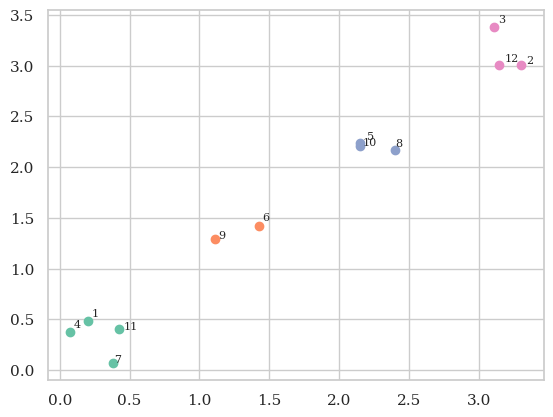

In [85]:
plt.close("all")
plt.figure(2)

colors = sns.color_palette('Set2', n_clusters_)
info = [(labels[i],subjects[i]) for i in range(12)]


for i,cluster_info in enumerate(info):
    cluster,p = cluster_info
    point = (cluster+np.random.random()*0.5,cluster+np.random.random()*0.5)
    plt.scatter(point[0],point[1],color=colors[cluster])
    plt.annotate(p,(point[0]+np.random.random()*0.05,point[1]+np.random.random()*0.05),fontsize=8)

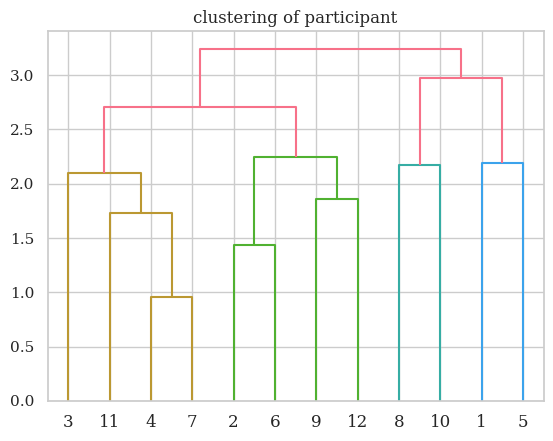

In [18]:
from scipy.cluster import hierarchy


temp = 1/np.exp(dmr/np.max(dmr))+1/np.exp(diqr/np.max(diqr))+1/np.exp(dicmdif/np.max(dicmdif))+1/np.exp(damp/np.max(damp))+1/np.exp(dpicmax/np.max(dpicmax))

Z = hierarchy.linkage(temp, 'average')
fig, ax = plt.subplots()
dn = hierarchy.dendrogram(Z)
ax.set_xticklabels([int(item.get_text())+1 for item in ax.get_xticklabels()])
plt.title("clustering of participant")
plt.show()

### old

In [31]:
n_cal = 7
n_class = 4
nb_fold = 1
spdbn_accuracy_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_train_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_test_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_pred_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_accuracy_perso = np.zeros((nb_fold,nb_subject))

for k in range(nb_fold):
    for i in range(nb_subject):
        print("TL to the participant : ", i)
        X = X_parent.copy()
        Y = Y_parent.copy()
        domains = domains_parent.copy()

        ## DA
        # n_cal = 4
        # nb_sample_cal = int(n_class*n_cal*(2.2-window_size)*60)
        # ind2take = [j for j in range(len(subjects)) if j!=i]
        # X_train = np.concatenate([np.concatenate(X[ind2take]).reshape(-1,X.shape[-2],X.shape[-1]),X[i][:nb_sample_cal]]).reshape(-1,X.shape[-2],X.shape[-1])
        # Y_train = np.concatenate([np.concatenate(Y[ind2take]).reshape(-1),Y[i][:nb_sample_cal]]).reshape(-1)
        # X_test = X[i][nb_sample_cal:]
        # Y_test = Y[i][nb_sample_cal:]
        # labels_code_test = labels_codes[i][(n_class*4):]
        # domains_train = np.concatenate([np.concatenate(domains[ind2take]).reshape(-1),domains[i][:nb_sample_cal]]).reshape(-1)

        ## DG
        ind2take = [j for j in range(len(subjects)) if j!=i]
        X_train = np.concatenate(X[ind2take]).reshape(-1,X.shape[-2],X.shape[-1])
        Y_train = np.concatenate(Y[ind2take]).reshape(-1)
        X_test = X[i]
        Y_test = Y[i]
        labels_code_test = labels_codes[i]
        domains_train = np.concatenate(domains[ind2take]).reshape(-1)

        ## SS
        # nb_sample_cal = int(n_class*n_cal*(2.2-window_size)*60)
        # X_train = X[i][:nb_sample_cal]
        # Y_train = Y[i][:nb_sample_cal]
        # X_test = X[i][nb_sample_cal:]
        # Y_test = Y[i][nb_sample_cal:]
        # labels_code_test = labels_codes[i][(n_class*n_cal):]
        # domains_train = domains[i][:nb_sample_cal]
        
        # X_std = X_train.std(axis=0)
        # X_train /= X_std + 1e-8
        # X_std = X_test.std(axis=0)
        # X_test /= X_std + 1e-8

        xdawn = Xdawn(nfilter=16,classes=[1],estimator='lwf')
        xdawn = xdawn.fit(X_train, Y_train)
        X_train = xdawn.transform(X_train)
        X_test = xdawn.transform(X_test)
        X_train = np.hstack([X_train,np.tile(xdawn.evokeds_[None,:,:],(X_train.shape[0],1,1))])
        X_test = np.hstack([X_test,np.tile(xdawn.evokeds_[None,:,:],(X_test.shape[0],1,1))])

        print("balancing the number of ones and zeros")
        X_train, Y_train, domains_train = balance(X_train,Y_train,domains_train)
        print(X_train.shape)
        print(Y_train.shape)
        print(X_test.shape)

        print("Creating the different pipelines")
        lr = 1e-3
        # optimizer = riemannian_adam.RiemannianAdam(learning_rate=lr)
        batchsize = 64 #128 # 64 for burst
        clf = deepcopy(model)

        print("Fitting")
        start = time.time()
        weight_decay = 1e-4
        
        x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, shuffle=True)

        # Convert data into PyTorch tensors
        X_train_tensor = torch.tensor(x_train, dtype=torch.float64)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(x_val, dtype=torch.float64)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float64)
        y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

        # Create DataLoader for train, validation, and test sets
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        val_dataloader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

        # Define loss function and optimizer
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch_riemannian_adam.RiemannianAdam(clf.parameters(), lr=lr)

        # Train the model
        num_epochs = 20

        for epoch in range(num_epochs):
            running_loss = 0.0
            train_y_pred= []
            y_train = []
            clf.train()
            for inputs, labels in train_dataloader:
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                # print(inputs.shape)
                # print(labels.shape)
                outputs = clf(inputs)
                # print(outputs.get_device())
                # print(labels.get_device())

                labels = labels.to('cpu')
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs, 1)
                train_y_pred.append(predicted.to('cpu'))
                y_train.append(labels.to('cpu'))

                running_loss += loss.item()
            
            train_accuracy = balanced_accuracy_score(np.concatenate(y_train),np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(train_y_pred)]))#train_correct / len(x_train)
            
            # Validation
            clf.eval()
            val_correct = 0
            val_y_pred = []
            with torch.no_grad():
                for inputs, labels in val_dataloader:
                    outputs = clf(inputs)
                    _, predicted = torch.max(outputs, 1)
                    predicted = predicted.to('cpu')
                    val_correct += (predicted == labels).sum().item()
                    val_y_pred.append(predicted)


            val_accuracy = balanced_accuracy_score(y_val,np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(val_y_pred)]))#val_correct / len(x_val)
            print(f"Epoch {epoch+1} train Accuracy: {train_accuracy} ||  Validation Accuracy: {val_accuracy}")

            print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_dataloader)}")

        print("Training finished!")
        print("Training accuracy :", balanced_accuracy_score(np.concatenate(y_train),np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(train_y_pred)])))
        spdbn_tps_train_code_perso[k][i] = time.time() - start

        # # Validation
        clf.eval()
        # val_correct = 0
        # val_y_pred = []
        # with torch.no_grad():
        #     for inputs, labels in val_dataloader:
        #         outputs = clf(inputs)
        #         _, predicted = torch.max(outputs, 1)
        #         predicted = predicted.to('cpu')
        #         val_correct += (predicted == labels).sum().item()
        #         val_y_pred.append(predicted)


        # val_accuracy = balanced_accuracy_score(y_val,np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(val_y_pred)]))#val_correct / len(x_val)
        # print(f"Validation Accuracy: {val_accuracy}")

        # Testing
        start = time.time()
        test_correct = 0
        y_pred= []
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = clf(inputs)
                _, predicted = torch.max(outputs, 1)
                predicted = predicted.to('cpu')
                y_pred.append(predicted)
                test_correct += (predicted == labels).sum().item()
                
        test_accuracy = test_correct / len(X_test)
        
        # print("getting accuracy of participant ", i)
        test_y_pred = np.concatenate(y_pred)

        y_pred_norm = np.array([1 if (y >= 0.5) else 0 for y in test_y_pred])
        y_test_norm = np.array([0 if y == 0 else 1 for y in Y_test])

        # tn, fp, fn, tp = confusion_matrix(y_test_norm, y_pred_norm).ravel()
        spdbn_accuracy_perso[k][i] = balanced_accuracy_score(y_test_norm,y_pred_norm)
        print(f"Test Accuracy: {spdbn_accuracy_perso[k][i]}")

        labels_pred_accumul, _, mean_long_accumul = make_preds_accumul_aggresive(
            y_pred_norm, codes, min_len=30, sfreq=60, consecutive=50, window_size=window_size
        )
        spdbn_tps_test_code_perso[k][i] = time.time() - start
        spdbn_accuracy_code_perso[k][i] = np.round(balanced_accuracy_score(labels_code_test[labels_pred_accumul!=-1], labels_pred_accumul[labels_pred_accumul!=-1]), 2)
        spdbn_tps_pred_code_perso[k][i] = np.mean(mean_long_accumul)
        # keras.backend.clear_session()


print(spdbn_accuracy_perso)
print(spdbn_tps_train_code_perso)
print(spdbn_tps_test_code_perso)
print(spdbn_accuracy_code_perso)
print(spdbn_tps_pred_code_perso)

spdbn_accuracy_perso = np.mean(spdbn_accuracy_perso,axis=0)
spdbn_tps_train_code_perso = np.mean(spdbn_tps_train_code_perso,axis=0)
spdbn_tps_test_code_perso = np.mean(spdbn_tps_test_code_perso,axis=0)
spdbn_accuracy_code_perso = np.mean(spdbn_accuracy_code_perso,axis=0)

print(spdbn_accuracy_perso)
print(spdbn_tps_train_code_perso)
print(spdbn_tps_test_code_perso)
print(np.mean(spdbn_tps_pred_code_perso,axis=0))
print(spdbn_accuracy_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/score/WO1_score",spdbn_accuracy_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/score_code/WO1_score_code",spdbn_accuracy_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/temps_train_code/WO1_tps_train_code",spdbn_tps_train_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/temps_test_code/WO1_tps_test_code",spdbn_tps_test_code_perso)

TL to the participant :  0
balancing the number of ones and zeros
(23760, 32, 176)
(23760,)
(6660, 32, 176)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5252178367632259 ||  Validation Accuracy: 0.6913341506406936
Epoch 1, Loss: 0.7317424193777219
Epoch 2 train Accuracy: 0.6488097331702043 ||  Validation Accuracy: 0.796559284808233
Epoch 2, Loss: 0.627236849129802
Epoch 3 train Accuracy: 0.7483095981426479 ||  Validation Accuracy: 0.8081331116294121
Epoch 3, Loss: 0.5365058412455549
Epoch 4 train Accuracy: 0.7678845252176374 ||  Validation Accuracy: 0.8190440054650123
Epoch 4, Loss: 0.5095516875737444
Epoch 5 train Accuracy: 0.7763012373612397 ||  Validation Accuracy: 0.8202949427380009
Epoch 5, Loss: 0.4975906486061687
Epoch 6 train Accuracy: 0.785348731290646 ||  Validation Accuracy: 0.8219736644225255
Epoch 6, Loss: 0.4904178062874059
Epoch 7 train Accuracy: 0.7883460574095786 ||  Validation Accuracy: 0.8261792368857508
Epoch 7, Loss: 0.4790947113173578
Epoch 8

c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


TL to the participant :  2
balancing the number of ones and zeros
(23760, 32, 176)
(23760,)
(6660, 32, 176)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5165742862893468 ||  Validation Accuracy: 0.6871185684070305
Epoch 1, Loss: 0.7383522808752477
Epoch 2 train Accuracy: 0.6425315817780564 ||  Validation Accuracy: 0.8040926950070679
Epoch 2, Loss: 0.6286457058556554
Epoch 3 train Accuracy: 0.7367671170878936 ||  Validation Accuracy: 0.8132447503888273
Epoch 3, Loss: 0.545619813380418
Epoch 4 train Accuracy: 0.7645275957638691 ||  Validation Accuracy: 0.8191223309088462
Epoch 4, Loss: 0.5141758284584842
Epoch 5 train Accuracy: 0.7805958916287723 ||  Validation Accuracy: 0.8171195604037427
Epoch 5, Loss: 0.49805725784815524
Epoch 6 train Accuracy: 0.782206416725583 ||  Validation Accuracy: 0.8218717560821798
Epoch 6, Loss: 0.4855358197231485
Epoch 7 train Accuracy: 0.7905162444138343 ||  Validation Accuracy: 0.8216517453827867
Epoch 7, Loss: 0.4832376971188619
Epoch

c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


TL to the participant :  7
balancing the number of ones and zeros
(23760, 32, 176)
(23760,)
(6660, 32, 176)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5174781706023452 ||  Validation Accuracy: 0.6846765715297921
Epoch 1, Loss: 0.7348455126438077
Epoch 2 train Accuracy: 0.6494685445826431 ||  Validation Accuracy: 0.7905861878086045
Epoch 2, Loss: 0.6245546338935493
Epoch 3 train Accuracy: 0.7472141608372738 ||  Validation Accuracy: 0.8042875805415938
Epoch 3, Loss: 0.5340860998791075
Epoch 4 train Accuracy: 0.7703599954011034 ||  Validation Accuracy: 0.8101750548014968
Epoch 4, Loss: 0.511756940923556
Epoch 5 train Accuracy: 0.7768830330885295 ||  Validation Accuracy: 0.816914553949029
Epoch 5, Loss: 0.49823910319042525
Epoch 6 train Accuracy: 0.7864048912154489 ||  Validation Accuracy: 0.8204975754489294
Epoch 6, Loss: 0.4923040054061196
Epoch 7 train Accuracy: 0.7860901313979145 ||  Validation Accuracy: 0.8221957797311958
Epoch 7, Loss: 0.48258551353155965
Epoc

c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


TL to the participant :  8
balancing the number of ones and zeros
(23760, 32, 176)
(23760,)
(6660, 32, 176)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5214225759820362 ||  Validation Accuracy: 0.7168015458493562
Epoch 1, Loss: 0.733287553995948
Epoch 2 train Accuracy: 0.6780245647052447 ||  Validation Accuracy: 0.8096162798854643
Epoch 2, Loss: 0.6046506219640725
Epoch 3 train Accuracy: 0.7630176915777185 ||  Validation Accuracy: 0.8232365264305803
Epoch 3, Loss: 0.5196224055707656
Epoch 4 train Accuracy: 0.7789087848892429 ||  Validation Accuracy: 0.8260170145465444
Epoch 4, Loss: 0.5038009074199882
Epoch 5 train Accuracy: 0.7880101488732575 ||  Validation Accuracy: 0.8272350724138591
Epoch 5, Loss: 0.48312183441939177
Epoch 6 train Accuracy: 0.7928780329742726 ||  Validation Accuracy: 0.8281039749500979
Epoch 6, Loss: 0.4751642872187425
Epoch 7 train Accuracy: 0.7994579216730495 ||  Validation Accuracy: 0.8296536506661054
Epoch 7, Loss: 0.4665600020275373
Epoc

In [ ]:
[0.63403524 0.59517622 0.69441458 0.73543907 0.72982378 0.77270012
 0.7338859  0.72413381 0.75077658 0.8301822  0.81689068 0.78546894]
[0.73 0.63 0.82 0.93 0.92 0.97 0.9  0.88 0.98 1.   0.98 1.  ]

(7020,)

In [8]:
np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/GREEN/score/DG_noXDAWN_score",spdbn_accuracy_perso)
np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/GREEN/score_code/DG_noXDAWN_score_code",spdbn_accuracy_code_perso)
np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/GREEN/temps_train_code/DG_noXDAWN_tps_train_code",spdbn_tps_train_code_perso)
np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/GREEN/temps_test_code/DG_noXDAWN_tps_test_code",spdbn_tps_test_code_perso)

# New dataset

In [22]:
# participants = ['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10',
#                 'P11','P12','P13','P14','P15','P16','P17','P18','P19','P20',
#                 'P21','P22','P23','P24']
participants = ["P1","P17","P15","P23"]
path = 'D:/s.velut/Documents/Thèse\\Protheus_PHD\\Data\\Dry_Ricker'
# path = '/home/dcas/k.cabrera/Data/SETNOP2'
nb_subject = len(participants)
n_class=5
fmin = 1
fmax = 45
fps = 60
window_size = 0.35
sfreq = 500

framewise = False
if framewise:
    freqwise = fps
else:
    freqwise = sfreq


raw_eeglab = [mne.io.read_raw_eeglab(os.path.join(path, '_'.join([p, 'dryburst100.set'])), preload=True, verbose=False).resample(sfreq=sfreq)
               for p in participants]

C:\Users\s.velut\AppData\Local\Temp\ipykernel_29268\3986067434.py:22: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_eeglab = [mne.io.read_raw_eeglab(os.path.join(path, '_'.join([p, 'dryburst100.set'])), preload=True, verbose=False).resample(sfreq=sfreq)
C:\Users\s.velut\AppData\Local\Temp\ipykernel_29268\3986067434.py:22: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeglab = [mne.io.read_raw_eeglab(os.path.join(path, '_'.join([p, 'dryburst100.set'])), preload=True, verbose=False).resample(sfreq=sfreq)
C:\Users\s.velut\AppData\Local\Temp\ipykernel_29268\3986067434.py:22: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_eeglab = [mne.io.read_raw_eeglab(os.path.join(path, '_'.join([p, 'dryburst100.set'])), preload=True, verbose=False).resample(sfreq=sfreq)
C:\Users\s.velut\AppData\Local\Temp\ipykernel

In [23]:
for ind_i,i in enumerate(participants):
    # raw = raw.drop_channels([ch for ch in raw.ch_names if ch in to_drop])
    # raw = raw.drop_channels([i for i in raw.ch_names if i not in keep])

    raw_eeglab[ind_i] = raw_eeglab[ind_i].filter(l_freq=fmin, h_freq=fmax, method="fir", verbose=True)

    # mne.set_eeg_reference(raw_eeglab[ind_i], 'average', copy=False, verbose=False)
    n_channels = len(raw_eeglab[ind_i].ch_names)
    print("Channels :", raw_eeglab[ind_i].ch_names)
    # print(raw_eeglab[ind_i].info)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (3.302 s)



Channels : ['EEG 000', 'EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (3.302 s)

Channels : ['EEG 000', 'EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) metho

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

In [24]:
def changeEventID(events, event_id):
    new_dic = {}
    for k in event_id.keys():
        new_dic[k.split('_')[1]] = event_id[k]
        event_id[k] = int(k.split('_')[1])
    for i in range(len(events)):
        events[i][2] = int(new_dic[str(events[i][2])])
    
    return events, event_id 


In [25]:
epochs_list = []
events_list = []
events_id_list = []
onset_code_list = []
data_list = []
labels_code_list = []
for ind_i, i in enumerate(participants): 
    # Get the events
    events, event_id = mne.events_from_annotations(raw_eeglab[ind_i], event_id='auto', verbose=False)
    to_remove = []
    for idx in range(len(raw_eeglab[ind_i].annotations.description)):
        if (('boundary' in raw_eeglab[ind_i].annotations.description[idx]) or
            ('BURST' in raw_eeglab[ind_i].annotations.description[idx])):
            to_remove.append(idx)

    to_remove = np.array(to_remove)
    if len(to_remove) > 0:
        raw_eeglab[ind_i].annotations.delete(to_remove)
        
    temp_event,temp_event_id = mne.events_from_annotations(raw_eeglab[ind_i], event_id='auto', verbose=False)
    temp_event,temp_event_id = changeEventID(temp_event,temp_event_id)
    events_list.append(temp_event)
    events_id_list.append(temp_event_id)
    shift = 0.0
    # Epoch the data following event
    epochs_list.append(mne.Epochs(raw_eeglab[ind_i], events_list[ind_i], event_id=events_id_list[ind_i], tmin=shift, \
                tmax=2.2+shift, baseline=(None, None), preload=False, verbose=False))
    # print(events_list[ind_i])

    labels_code_list.append(epochs_list[ind_i].events[..., -1])
    labels_code_list[ind_i] -= np.min(labels_code_list[ind_i])
    # print(epochs.events[..., -1])
    data_list.append(epochs_list[ind_i].get_data())
    info_ep = epochs_list[ind_i].info
    # print(epochs)
    onset_code_list.append(epochs_list[ind_i].events[..., 0])
data_list = np.array(data_list)

In [26]:
data_list[0].shape

(75, 8, 1101)

In [27]:
from collections import OrderedDict
codes = OrderedDict()
for k, v in events_id_list[0].items():
    code = k.split('_')[0]
    code = code.replace('.','').replace('2','')
    idx = k.split('_')[1]
    codes[v-1] = np.array(list(map(int, code)))

In [28]:
def to_window_old(data, labels,length,n_samples_windows,codes,window_size=0.25,normalise=True,sfreq=500,fps=60,n_channels=8):
    
    X = np.empty(shape=((length)*data.shape[0], n_channels, n_samples_windows))
    idx_taken = []
    y = np.empty(shape=((length)*data.shape[0]), dtype=int)
    count = 0
    for trial_nb, trial in enumerate(data):
        lab = labels[trial_nb]
        c = codes[lab]
        code_pos = 0
        for idx in range(length):
            X[count] = trial[:, int(idx*500/sfreq):int(idx*500/sfreq)+n_samples_windows]
            if idx/sfreq >= (code_pos+1)/fps:
                code_pos += 1 
            y[count] = int(c[code_pos])
            count += 1
        
        for idx in range(length):
            # print('Xidx:', trial_nb*length+idx, "Tidxm:", idx, 'TidxM:', idx +
            #       n_samples_windows, 'Ltrial', trial[:, idx:idx+n_samples_windows].shape)
            idx_taken.append(trial_nb*length+idx)
    # if normalise:
    #     X_std = X.std(axis=0)
    #     X /= X_std + 1e-8
    y_pred = np.vstack((y,np.abs(1-y))).T
    y = np.array([1 if (y >= 0.5) else 0 for y in y_pred[:,0]])

    return X, y, np.array(idx_taken)

In [29]:

n_samples_windows = int(window_size*sfreq)
length = int((2.2-window_size)*freqwise)
X = np.zeros((data_list.shape[0],length*data_list.shape[1],data_list.shape[2],n_samples_windows))
Y = np.zeros((data_list.shape[0],length*data_list.shape[1]))
idx_taken = np.zeros((data_list.shape[0],length*data_list.shape[1]))
domains = []
print(Y.shape)
print(X.shape)
for ind_i,i in enumerate(participants):
    X[ind_i],Y[ind_i],idx_taken[ind_i] = to_window_old(data_list[ind_i],labels_code_list[ind_i],length,n_samples_windows,codes,window_size=window_size,sfreq=freqwise)
    domains.append(["Source_sub_{}".format(i),]*len(Y[ind_i]))
    # X[ind_i] = compute_riemannian_alignment(temp_X, mean=None, dtype='real')

# print(codes[labels_test[0]])
print(Y.shape)
print(X.shape)
domains = np.array(domains)

(4, 69375)
(4, 69375, 8, 175)
(4, 69375)
(4, 69375, 8, 175)


In [30]:
def onset_anno(onset_window,label_window,onset_code,nb_seq_min,nb_seq_max,code_freq,sfreq,win_size):
    assert(sfreq!=0)
    new_onset = []
    new_onset_0 = []
    current_code = 0
    onset_code = np.ceil(onset_code*code_freq/sfreq)
    nb_seq_min-=1
    onset_shift = onset_code[current_code+nb_seq_min]
    time_trial = (2.2-win_size)
    # onset_window = np.arange(0,time_trial*code_freq*(nb_seq_max-nb_seq_min)-1,1,dtype=int)
    for i,o in enumerate(onset_window):
        if label_window[i]==1:
            # print(i)
            if current_code==nb_seq_max-1-nb_seq_min:
                new_onset.append(o+onset_shift)
            else:
                if o+onset_shift >= onset_code[current_code+nb_seq_min]+time_trial*code_freq:
                    current_code+=1
                    onset_shift = onset_code[current_code+nb_seq_min]-time_trial*code_freq*current_code
                new_onset.append(o+onset_shift)
        else:
            if current_code==nb_seq_max-1-nb_seq_min:
                new_onset_0.append(o+onset_shift)
            else:
                if o+onset_shift >= onset_code[current_code+nb_seq_min]+time_trial*code_freq:
                    current_code+=1
                    onset_shift = onset_code[current_code+nb_seq_min]-time_trial*code_freq*current_code
                new_onset_0.append(o+onset_shift)
    
    # modified_onset_code = [onset_code[i]-time_trial*sfreq*i for i in range(nb_seq_min,nb_seq_max)]
    # new_onset_0 = np.concatenate([np.arange(onset_code[i],onset_code[i]+time_trial*sfreq,sfreq//60) for i in range(nb_seq_min,nb_seq_max)])
    new_onset_0 = np.array(list(filter(lambda i: i not in new_onset, new_onset_0)))
    # print(new_onset_0.shape)
    return np.array(new_onset)/code_freq, np.array(new_onset_0)/code_freq
            

In [31]:

# for ind_i,i in enumerate(participants):
#     onset,onset_0 = onset_anno(idx_taken[ind_i],Y[ind_i],onset_code_list[ind_i],1,n_class*15,freqwise,500,window_size)
#     # print(onset,onset_0)
#     anno = mne.Annotations(onset,1/freqwise,"1")
#     anno.append(onset_0,1/freqwise,"0")
#     # print(anno)

#     raw_eeglab[ind_i] = raw_eeglab[ind_i].set_annotations(anno)

# X_parent = np.zeros((X.shape[0],length*data_list.shape[1],data_list.shape[2],int(window_size*sfreq)))
# domains_parent = []
# Y_parent = np.zeros((data_list.shape[0],length*data_list.shape[1]))
# for ind_i,i in enumerate(participants):
#     events, event_id = mne.events_from_annotations(raw_eeglab[ind_i])
#     print(events.shape)
#     epochs = mne.Epochs(raw_eeglab[ind_i],events,event_id,tmin=0.0,tmax=window_size,baseline=(0,0))
#     X_parent[ind_i] = epochs.get_data()[:,:,:-1]
#     Y_parent[ind_i] = epochs.events[...,-1]-1

#     # xdawn = Xdawn(nfilter=8,classes=[1],estimator='lwf')
#     # temp_X = xdawn.fit_transform(temp_X,Y_parent[ind_i])
#     # temp_X = np.hstack([temp_X,np.tile(xdawn.evokeds_[None,:,:],(temp_X.shape[0],1,1))])
    
#     # X_parent[ind_i] = compute_riemannian_alignment(temp_X, mean=None, dtype='real')

    
    
#     domains_parent.append(["Source_sub_{}".format(ind_i+1),]*len(Y_parent[ind_i]))

# domains_parent = np.array(domains_parent)

In [32]:
X_parent,Y_parent,domains_parent = X,Y,domains

In [36]:
model = get_green(
            n_freqs=20,
                kernel_width_s=window_size,
                n_ch=8,
                sfreq=500,
                oct_min=0,
                oct_max=4.5,
                orth_weights=False,
                dropout=.7,
                hidden_dim=[20,10],
                logref='logeuclid',
                pool_layer=RealCovariance(),
                bi_out=[4],
                dtype=torch.float32,
                out_dim=2,
                shrinkage_init=None
            )

model

Green(
  (conv_layers): Sequential(
    (0): ComplexWavelet(kernel_width_s=0.35, sfreq=500, n_wavelets=20, stride=5, padding=0, scaling=oct)
  )
  (pooling_layers): RealCovariance()
  (spd_layers): Sequential(
    (0): Identity()
    (1): BiMap(d_in=8, d_out=4, n_freqs=20
  )
  (proj): LogEig(ref=logeuclid, reg=0.0001, n_freqs=20, size=4
  (head): Sequential(
    (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): Linear(in_features=200, out_features=20, bias=True)
    (3): GELU(approximate='none')
    (4): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.7, inplace=False)
    (6): Linear(in_features=20, out_features=10, bias=True)
    (7): GELU(approximate='none')
    (8): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.7, inplace=False)
    (10): Linear(in_features=10, out_features=2, bias=True)
  )


## Perform test train

In [37]:
n_cal = 4
n_class = 5
nb_fold = 1
spdbn_accuracy_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_train_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_test_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_pred_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_accuracy_perso = np.zeros((nb_fold,nb_subject))
spdbn_recall_perso = np.zeros((nb_fold,nb_subject))
spdbn_f1_perso = np.zeros((nb_fold,nb_subject))
path = '/'.join(['D:/s.velut/Documents/Thèse/Protheus_PHD/Data/STL',"ws"+str(window_size),"time_sample","data",''])

# nb_subject = 13

for k in range(nb_fold):
    for i in range(nb_subject):
        print("TL to the participant : ", i)
        X = X_parent.copy()
        Y = Y_parent.copy()
        domains = domains_parent.copy()
        nb_sample_cal = int(n_class*n_cal*(2.2-window_size)*freqwise)
        

        # preprocessDA
        # X = np.zeros((X_parent.shape[0],X_parent.shape[1],X_parent.shape[2],X_parent.shape[3]))
        # for j in range(nb_subject):
        #     xdawn = Xdawn(nfilter=4,classes=[1],estimator='lwf')
        #     alig = Aligner(estimator="lwf",metric="real")
            
        #     if j==i:
        #         X_std = X_parent[j][:nb_sample_cal].std(axis=0)
        #         temp_X = X_parent[j]/(X_std + 1e-8)
        #         xdawn = xdawn.fit(temp_X[:nb_sample_cal],Y[j][:nb_sample_cal])
        #         temp_X_train = xdawn.transform(temp_X[:nb_sample_cal])
        #         temp_Xtest = xdawn.transform(temp_X[nb_sample_cal:])
        #         X[j][:nb_sample_cal] = np.hstack([temp_X_train,np.tile(xdawn.evokeds_[None,:,:],(temp_X_train.shape[0],1,1))])
        #         X[j][nb_sample_cal:] = np.hstack([temp_Xtest,np.tile(xdawn.evokeds_[None,:,:],(temp_Xtest.shape[0],1,1))])
        #         alig = alig.fit(X[j][:nb_sample_cal])
        #         X[j] = alig.transform(X[j])

        #     else:
        #         X_std = X_parent[j].std(axis=0)
        #         temp_X = X_parent[j]/(X_std + 1e-8)
        #         xdawn = xdawn.fit(temp_X,Y[j])
        #         temp_X = xdawn.transform(temp_X)
        #         X[j] = np.hstack([temp_X,np.tile(xdawn.evokeds_[None,:,:],(temp_X.shape[0],1,1))])
        #         X[j] = compute_riemannian_alignment(X[j], mean=None, dtype='real')
        #         # X[j] = np.load(path+"full_preprocess_data_"+participants[j]+".npy")
        # # DA
        # n_cal = 4
        # nb_sample_cal = int(n_class*n_cal*(2.2-window_size)*freqwise)
        # ind2take = [1,]
        # # ind2take = [j for j in range(6) if j!=i]
        # X_train = np.concatenate([np.concatenate(X[ind2take]).reshape(-1,X.shape[-2],X.shape[-1]),X[i][:nb_sample_cal]]).reshape(-1,X.shape[-2],X.shape[-1])
        # Y_train = np.concatenate([np.concatenate(Y[ind2take]).reshape(-1),Y[i][:nb_sample_cal]]).reshape(-1)
        # X_test = X[i][nb_sample_cal:]
        # Y_test = Y[i][nb_sample_cal:]
        # labels_code_test = labels_code_list[i][(n_class*4):]
        # domains_train = np.concatenate([np.concatenate(domains[ind2take]).reshape(-1),domains[i][:nb_sample_cal]]).reshape(-1)
        # domain_test = domains[i][nb_sample_cal]

        Xs = np.concatenate(np.array([np.load(path+"full_preprocess_data_"+p+".npy") for p in participants if p!=participants[i] ])).reshape(-1,X_parent.shape[-2],X_parent.shape[-1])
        Xtarget = np.load(path+"full_solo_preprocess_data_"+participants[i]+".npy")
        n_cal = 4
        # Initialisation
        nb_sample_cal = int(n_class*n_cal*(2.2-window_size)*freqwise)

        # Get the training data
        # ind2take = [0,]
        ind2take = [j for j in range(nb_subject) if j!=i]
        X_train = np.concatenate([Xs,Xtarget[:nb_sample_cal]]).reshape(-1,Xs.shape[-2],Xs.shape[-1])
        Y_train = np.concatenate([np.concatenate(Y[ind2take]).reshape(-1),Y[i][:nb_sample_cal]]).reshape(-1)
        domains_train = np.concatenate([np.concatenate(domains_parent[ind2take]).reshape(-1),domains_parent[i][:nb_sample_cal]]).reshape(-1)
        X_test = Xtarget[nb_sample_cal:]
        Y_test = Y[i][nb_sample_cal:]
        labels_code_test = labels_code_list[i][(n_class*n_cal):]
                    
        

        ## DG
        # X = X_parent.copy()
        # ind2take = [j for j in range(len(participants)) if j!=i]
        # X_train = np.concatenate(X[ind2take]).reshape(-1,X.shape[-2],X.shape[-1])
        # Y_train = np.concatenate(Y[ind2take]).reshape(-1)
        # X_test = X[i]
        # Y_test = Y[i]
        # labels_code_test = labels_code_list[i]
        # domains_train = np.concatenate(domains[ind2take]).reshape(-1)
        # #preprocessDG
        # X_std = X_train.std(axis=0)
        # X_train /= X_std + 1e-8
        # X_std = X_test.std(axis=0)
        # X_test /= X_std + 1e-8
        # xdawn = Xdawn(nfilter=8,classes=[1],estimator='lwf')
        # xdawn = xdawn.fit(X_train, Y_train)
        # X_train = xdawn.transform(X_train)
        # X_test = xdawn.transform(X_test)
        # X_train = np.hstack([X_train,np.tile(xdawn.evokeds_[None,:,:],(X_train.shape[0],1,1))])
        # X_test = np.hstack([X_test,np.tile(xdawn.evokeds_[None,:,:],(X_test.shape[0],1,1))])
        # rmean = mean_covariance(compute_covariances(X_train, estimator='lwf'), metric='riemann')
        # X_train = compute_riemannian_alignment(X_train,mean=rmean,dtype='real')
        # X_test = compute_riemannian_alignment(X_test,mean=rmean,dtype='real')
        

        #preprocessSS
        # n_cal = 7
        # nb_sample_cal = int(n_class*n_cal*(2.2-window_size)*freqwise)
        
        # xdawn = Xdawn(nfilter=4,classes=[1],estimator='lwf')
        # xdawn = xdawn.fit(X_parent[i][:nb_sample_cal],Y[i][:nb_sample_cal])
        # temp_X = xdawn.transform(X_parent[i][:nb_sample_cal])
        # temp_Xtest = xdawn.transform(X_parent[i][nb_sample_cal:])
        # X[i][:nb_sample_cal] = np.hstack([temp_X,np.tile(xdawn.evokeds_[None,:,:],(temp_X.shape[0],1,1))])
        # X[i][nb_sample_cal:] = np.hstack([temp_Xtest,np.tile(xdawn.evokeds_[None,:,:],(temp_Xtest.shape[0],1,1))])
        # rmean = mean_covariance(compute_covariances(X[i][:nb_sample_cal], estimator='lwf'), metric='riemann')
        # X[i] = compute_riemannian_alignment(X[i], mean=rmean, dtype='real')
        
        # ## SS
        # X_train = X[i][:nb_sample_cal]
        # Y_train = Y[i][:nb_sample_cal]
        # X_test = X[i][nb_sample_cal:]
        # Y_test = Y[i][nb_sample_cal:]
        # labels_code_test = labels_code_list[i][(n_class*n_cal):]
        # domains_train = domains[i][:nb_sample_cal]
        
        

        print("balancing the number of ones and zeros")
        X_train, Y_train, domains_train = balance(X_train,Y_train,domains_train)
        print(X_train.shape)
        print(Y_train.shape)
        print(X_test.shape)
        print(Y_test.shape)

        print("Creating the different pipelines")
        lr = 1e-3
        # optimizer = riemannian_adam.RiemannianAdam(learning_rate=lr)
        batchsize = 64 #128 # 64 for burst
        clf = deepcopy(model)

        print("Fitting")
        start = time.time()
        weight_decay = 1e-4
        
        x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, shuffle=True)

        # Convert data into PyTorch tensors
        X_train_tensor = torch.tensor(x_train, dtype=torch.float64)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(x_val, dtype=torch.float64)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float64)
        y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

        # Create DataLoader for train, validation, and test sets
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        val_dataloader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

        # Define loss function and optimizer
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch_riemannian_adam.RiemannianAdam(clf.parameters(), lr=lr)

        # Train the model
        num_epochs = 20

        for epoch in range(num_epochs):
            running_loss = 0.0
            train_y_pred= []
            y_train = []
            clf.train()
            for inputs, labels in train_dataloader:
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                # print(inputs.shape)
                # print(labels.shape)
                outputs = clf(inputs)
                # print(outputs.get_device())
                # print(labels.get_device())

                labels = labels.to('cpu')
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs, 1)
                train_y_pred.append(predicted.to('cpu'))
                y_train.append(labels.to('cpu'))

                running_loss += loss.item()
            
            train_accuracy = balanced_accuracy_score(np.concatenate(y_train),np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(train_y_pred)]))#train_correct / len(x_train)
            
            # Validation
            clf.eval()
            val_correct = 0
            val_y_pred = []
            with torch.no_grad():
                for inputs, labels in val_dataloader:
                    outputs = clf(inputs)
                    _, predicted = torch.max(outputs, 1)
                    predicted = predicted.to('cpu')
                    val_correct += (predicted == labels).sum().item()
                    val_y_pred.append(predicted)


            val_accuracy = balanced_accuracy_score(y_val,np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(val_y_pred)]))#val_correct / len(x_val)
            print(f"Epoch {epoch+1} train Accuracy: {train_accuracy} ||  Validation Accuracy: {val_accuracy}")

            print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_dataloader)}")

        print("Training finished!")
        print("Training accuracy :", balanced_accuracy_score(np.concatenate(y_train),np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(train_y_pred)])))
        spdbn_tps_train_code_perso[k][i] = time.time() - start

        # # Validation
        clf.eval()
        # val_correct = 0
        # val_y_pred = []
        # with torch.no_grad():
        #     for inputs, labels in val_dataloader:
        #         outputs = clf(inputs)
        #         _, predicted = torch.max(outputs, 1)
        #         predicted = predicted.to('cpu')
        #         val_correct += (predicted == labels).sum().item()
        #         val_y_pred.append(predicted)


        # val_accuracy = balanced_accuracy_score(y_val,np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(val_y_pred)]))#val_correct / len(x_val)
        # print(f"Validation Accuracy: {val_accuracy}")

        # Testing
        start = time.time()
        test_correct = 0
        y_pred= []
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = clf(inputs)
                _, predicted = torch.max(outputs, 1)
                predicted = predicted.to('cpu')
                y_pred.append(predicted)
                test_correct += (predicted == labels).sum().item()
                
        test_accuracy = test_correct / len(X_test)
        
        # print("getting accuracy of participant ", i)
        test_y_pred = np.concatenate(y_pred)

        y_pred_norm = np.array([1 if (y >= 0.5) else 0 for y in test_y_pred])
        y_test_norm = np.array([0 if y == 0 else 1 for y in Y_test])

        # tn, fp, fn, tp = confusion_matrix(y_test_norm, y_pred_norm).ravel()
        spdbn_accuracy_perso[k][i] = balanced_accuracy_score(y_test_norm,y_pred_norm)
        spdbn_recall_perso[k][i] = recall_score(y_test_norm,y_pred_norm)
        spdbn_f1_perso[k][i] = f1_score(y_test_norm,y_pred_norm)
        print(f"Test Accuracy: {spdbn_accuracy_perso[k][i]}")
        print(f"Test recall: {spdbn_recall_perso[k][i]}")
        print(f"Test f1: {spdbn_f1_perso[k][i]}")

        labels_pred_accumul, _, mean_long_accumul = make_preds_accumul_aggresive(
            y_pred_norm, codes, min_len=30, sfreq=freqwise, consecutive=50, window_size=window_size
        )
        spdbn_tps_test_code_perso[k][i] = time.time() - start
        spdbn_accuracy_code_perso[k][i] = np.round(balanced_accuracy_score(labels_code_test[labels_pred_accumul!=-1], labels_pred_accumul[labels_pred_accumul!=-1]), 2)
        spdbn_tps_pred_code_perso[k][i] = np.mean(mean_long_accumul)
        # keras.backend.clear_session()


print(spdbn_accuracy_perso)
print(spdbn_tps_train_code_perso)
print(spdbn_tps_test_code_perso)
print(spdbn_accuracy_code_perso)
print(spdbn_tps_pred_code_perso)

spdbn_accuracy_perso = np.mean(spdbn_accuracy_perso,axis=0)
spdbn_tps_train_code_perso = np.mean(spdbn_tps_train_code_perso,axis=0)
spdbn_tps_test_code_perso = np.mean(spdbn_tps_test_code_perso,axis=0)
spdbn_accuracy_code_perso = np.mean(spdbn_accuracy_code_perso,axis=0)

print(spdbn_accuracy_perso)
print(spdbn_recall_perso)
print(spdbn_f1_perso)
print(spdbn_tps_train_code_perso)
print(spdbn_tps_test_code_perso)
print(np.mean(spdbn_tps_pred_code_perso,axis=0))
print(spdbn_accuracy_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/score/WO1_score",spdbn_accuracy_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/score_code/WO1_score_code",spdbn_accuracy_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/temps_train_code/WO1_tps_train_code",spdbn_tps_train_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/temps_test_code/WO1_tps_test_code",spdbn_tps_test_code_perso)

TL to the participant :  0
balancing the number of ones and zeros
(21168, 8, 175)
(21168,)
(50875, 8, 175)
(50875,)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5421939547490549 ||  Validation Accuracy: 0.7486382698394846
Epoch 1, Loss: 0.7165286835634483
Epoch 2 train Accuracy: 0.6372387858835156 ||  Validation Accuracy: 0.7856283686195957
Epoch 2, Loss: 0.6332388209846784
Epoch 3 train Accuracy: 0.7106185645355083 ||  Validation Accuracy: 0.8018425980972377
Epoch 3, Loss: 0.5747365830079565
Epoch 4 train Accuracy: 0.7361404041185188 ||  Validation Accuracy: 0.8083868027771975
Epoch 4, Loss: 0.549869149248555
Epoch 5 train Accuracy: 0.7537236434073492 ||  Validation Accuracy: 0.81345144813821
Epoch 5, Loss: 0.529843321723758
Epoch 6 train Accuracy: 0.7657001313331063 ||  Validation Accuracy: 0.8129986538911294
Epoch 6, Loss: 0.518718041226549
Epoch 7 train Accuracy: 0.7709323367238454 ||  Validation Accuracy: 0.8177033400995835
Epoch 7, Loss: 0.509746326028176
Ep

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


TL to the participant :  1
balancing the number of ones and zeros
(21168, 8, 175)
(21168,)
(50875, 8, 175)
(50875,)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5465250106259606 ||  Validation Accuracy: 0.7530255451805152
Epoch 1, Loss: 0.7171556031928872
Epoch 2 train Accuracy: 0.653265506847825 ||  Validation Accuracy: 0.7856716669020742
Epoch 2, Loss: 0.6237846181077777
Epoch 3 train Accuracy: 0.7196746745211524 ||  Validation Accuracy: 0.8053753925226075
Epoch 3, Loss: 0.5692375623954917
Epoch 4 train Accuracy: 0.7446762894607224 ||  Validation Accuracy: 0.8181883702410016
Epoch 4, Loss: 0.5436832151322994
Epoch 5 train Accuracy: 0.757916269173929 ||  Validation Accuracy: 0.8203263396085629
Epoch 5, Loss: 0.5200903588870787
Epoch 6 train Accuracy: 0.7677711946642927 ||  Validation Accuracy: 0.8284780242007913
Epoch 6, Loss: 0.5108305353038716
Epoch 7 train Accuracy: 0.776109297492011 ||  Validation Accuracy: 0.8319907291811007
Epoch 7, Loss: 0.503299142279715


c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


TL to the participant :  2
balancing the number of ones and zeros
(21168, 8, 175)
(21168,)
(50875, 8, 175)
(50875,)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5635314631194777 ||  Validation Accuracy: 0.8098963449702261
Epoch 1, Loss: 0.7053466686662638
Epoch 2 train Accuracy: 0.7038266984609644 ||  Validation Accuracy: 0.8466254737571577
Epoch 2, Loss: 0.5807387660134513
Epoch 3 train Accuracy: 0.7729295103770409 ||  Validation Accuracy: 0.8493130744472982
Epoch 3, Loss: 0.5052539784953279
Epoch 4 train Accuracy: 0.7860055579015406 ||  Validation Accuracy: 0.8564082688261538
Epoch 4, Loss: 0.4858419638759685
Epoch 5 train Accuracy: 0.8047501678396096 ||  Validation Accuracy: 0.8597710069549873
Epoch 5, Loss: 0.4593829594693094
Epoch 6 train Accuracy: 0.8091999262130652 ||  Validation Accuracy: 0.8597908770714038
Epoch 6, Loss: 0.45202721683484204
Epoch 7 train Accuracy: 0.8105798880831199 ||  Validation Accuracy: 0.8603488031492126
Epoch 7, Loss: 0.446074402782

In [39]:
y_pred

[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1,

In [17]:
print("group 1: P10, P15, P23, P9, P3, P2, P20, P12", [0.8,0.8,0.76,0.89,0.96,0.98,0.96,0.95])
print("group 1: P1,P6,P8,P13,P14,P17,P21,P22,P24", [1,0.98,1,0.95,0.96,1,0.98,0.96,1])

group 1: P10, P15, P23, P9, P3, P2, P20, P12 [0.8, 0.8, 0.76, 0.89, 0.96, 0.98, 0.96, 0.95]
group 1: P1,P6,P8,P13,P14,P17,P21,P22,P24 [1, 0.98, 1, 0.95, 0.96, 1, 0.98, 0.96, 1]


In [18]:
print("group 0 : P1, P3, P8, P17, P22, P24", [1,1,0.98,1,0.98,1])
print("group 2 : P4, P5, P7, P9, P11, P16", [0.99,0.97,0.93,0.85,0.96,0.99])
print("group 6 : P6, P14, P20, P21", [0.95,0.98,0.96,1])
print("group 4 : P12, P18", [0.95,0.98])
print("group 3: P10, P15, P23", [0.69, 0.87, 0.75])

group 0 : P1, P3, P8, P17, P22, P24 [1, 1, 0.98, 1, 0.98, 1]
group 2 : P4, P5, P7, P9, P11, P16 [0.99, 0.97, 0.93, 0.85, 0.96, 0.99]
group 6 : P6, P14, P20, P21 [0.95, 0.98, 0.96, 1]
group 4 : P12, P18 [0.95, 0.98]
group 3: P10, P15, P23 [0.69, 0.87, 0.75]


In [135]:
print("Pour SS, 98.7% si on enlève les 4 sujets qui se sont montrés mauvais et avec des mauvais ERP")

Pour SS, 98.7% si on enlève les 4 sujets qui se sont montrés mauvais et avec des mauvais ERP


In [154]:
y_test_norm[200:400]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [153]:
y_pred_norm[200:400]==y_test_norm[200:400]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

## Test on similar training

### Absolute value on xdawn

In [14]:
n_cal = 7
# n_class = 4
nb_fold = 1
spdbn_accuracy_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_train_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_test_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_pred_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_accuracy_perso = np.zeros((nb_fold,nb_subject))
spdbn_recall_perso = np.zeros((nb_fold,nb_subject))
spdbn_f1_perso = np.zeros((nb_fold,nb_subject))

for k in range(nb_fold):
    for i in range(nb_subject):
        print("TL to the participant : ", i)
        # X = X_parent.copy()
        Y = Y_parent.copy()
        X = np.zeros((X_parent.shape[0],X_parent.shape[1],X_parent.shape[2]*2,X_parent.shape[3]))
        domains = domains_parent.copy()

        # #preprocessDA
        n_cal = 4
        nb_sample_cal = int(n_class*n_cal*(2.2-window_size)*60)
        for j in range(nb_subject):
            xdawn = Xdawn(nfilter=8,classes=[1],estimator='lwf')
            if j==i:
                xdawn = xdawn.fit(X_parent[j][:nb_sample_cal],Y[j][:nb_sample_cal])
                temp_X = np.abs(xdawn.transform(X_parent[j][:nb_sample_cal]))
                temp_Xtest = np.abs(xdawn.transform(X_parent[j][nb_sample_cal:]))
                X[j][:nb_sample_cal] = np.hstack([temp_X,np.abs(np.tile(xdawn.evokeds_[None,:,:],(temp_X.shape[0],1,1)))])
                X[j][nb_sample_cal:] = np.hstack([temp_Xtest,np.abs(np.tile(xdawn.evokeds_[None,:,:],(temp_Xtest.shape[0],1,1)))])
                rmean = mean_covariance(compute_covariances(X[j][:nb_sample_cal], estimator='lwf'), metric='riemann')
                X[j] = compute_riemannian_alignment(X[j], mean=rmean, dtype='real')

            else:
                xdawn = xdawn.fit(X_parent[j],Y[j])
                temp_X = np.abs(xdawn.transform(X_parent[j]))
                X[j] = np.hstack([temp_X,np.abs(np.tile(xdawn.evokeds_[None,:,:],(temp_X.shape[0],1,1)))])
                X[j] = compute_riemannian_alignment(X[j], mean=None, dtype='real')

            
            # X[j] = compute_riemannian_alignment(X[j], mean=None, dtype='real')
        ## DA
        
        ind2take = [j for j in range(len(participants)) if j!=i]
        X_train = np.concatenate([np.concatenate(X[ind2take]).reshape(-1,X.shape[-2],X.shape[-1]),X[i][:nb_sample_cal]]).reshape(-1,X.shape[-2],X.shape[-1])
        Y_train = np.concatenate([np.concatenate(Y[ind2take]).reshape(-1),Y[i][:nb_sample_cal]]).reshape(-1)
        X_test = X[i][nb_sample_cal:]
        Y_test = Y[i][nb_sample_cal:]
        labels_code_test = labels_code_list[i][(n_class*4):]
        domains_train = np.concatenate([np.concatenate(domains[ind2take]).reshape(-1),domains[i][:nb_sample_cal]]).reshape(-1)
        domain_test = domains[i][nb_sample_cal]
        # X_train = np.zeros((X_train_temp.shape[0],X_train_temp.shape[1]*2,X_train_temp.shape[2]))
        # X_test = np.zeros((X_test_temp.shape[0],X_test_temp.shape[1]*2,X_test_temp.shape[2]))
        
            
        

        ## DG
        # ind2take = [j for j in range(len(participants)) if j!=i]
        # X_train = np.concatenate(X[ind2take]).reshape(-1,X.shape[-2],X.shape[-1])
        # Y_train = np.concatenate(Y[ind2take]).reshape(-1)
        # X_test = X[i]
        # Y_test = Y[i]
        # labels_code_test = labels_code_list[i]
        # domains_train = np.concatenate(domains[ind2take]).reshape(-1)
        # #preprocessDG
        # r_mean = compute_ref_riemann(X_train, mean=None, dtype='real')
        # X_train = compute_riemannian_alignment(X_train,mean=r_mean,dtype='real')
        # X_test = compute_riemannian_alignment(X_test,mean=r_mean,dtype='real')
        # xdawn = Xdawn(nfilter=8,classes=[1],estimator='lwf')
        # xdawn = xdawn.fit(X_train, Y_train)
        # X_train = xdawn.transform(X_train)
        # X_test = xdawn.transform(X_test)
        # X_train = np.hstack([X_train,np.tile(xdawn.evokeds_[None,:,:],(X_train.shape[0],1,1))])
        # X_test = np.hstack([X_test,np.tile(xdawn.evokeds_[None,:,:],(X_test.shape[0],1,1))])
        

        ## SS
        # nb_sample_cal = int(n_class*n_cal*(2.2-window_size)*60)
        # X_train = X[i][:nb_sample_cal]
        # Y_train = Y[i][:nb_sample_cal]
        # X_test = X[i][nb_sample_cal:]
        # Y_test = Y[i][nb_sample_cal:]
        # labels_code_test = labels_code_list[i][(n_class*n_cal):]
        # domains_train = domains[i][:nb_sample_cal]
        #preprocessSS
        # xdawn = Xdawn(nfilter=8,classes=[1],estimator='lwf')
        # xdawn = xdawn.fit(X_train, Y_train)
        # X_train = xdawn.transform(X_train)
        # X_test = xdawn.transform(X_test)
        # X_train = np.hstack([X_train,np.tile(xdawn.evokeds_[None,:,:],(X_train.shape[0],1,1))])
        # X_test = np.hstack([X_test,np.tile(xdawn.evokeds_[None,:,:],(X_test.shape[0],1,1))])
        # r_mean = compute_ref_riemann(X_train, mean=None, dtype='real')
        # X_train = compute_riemannian_alignment(X_train,mean=r_mean,dtype='real')
        # X_test = compute_riemannian_alignment(X_test,mean=r_mean,dtype='real')
        
        # X_std = X_train.std(axis=0)
        # X_train /= X_std + 1e-8
        # X_std = X_test.std(axis=0)
        # X_test /= X_std + 1e-8

        # xdawn = Xdawn(nfilter=8,classes=[1],estimator='lwf')
        # xdawn = xdawn.fit(X_train, Y_train)
        # X_train = xdawn.transform(X_train)
        # X_test = xdawn.transform(X_test)
        # X_train = np.hstack([X_train,np.tile(xdawn.evokeds_[None,:,:],(X_train.shape[0],1,1))])
        # X_test = np.hstack([X_test,np.tile(xdawn.evokeds_[None,:,:],(X_test.shape[0],1,1))])

        print("balancing the number of ones and zeros")
        X_train, Y_train, domains_train = balance(X_train,Y_train,domains_train)
        print(X_train.shape)
        print(Y_train.shape)
        print(X_test.shape)

        print("Creating the different pipelines")
        lr = 1e-3
        # optimizer = riemannian_adam.RiemannianAdam(learning_rate=lr)
        batchsize = 64 #128 # 64 for burst
        clf = deepcopy(model)

        print("Fitting")
        start = time.time()
        weight_decay = 1e-4
        
        x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, shuffle=True)

        # Convert data into PyTorch tensors
        X_train_tensor = torch.tensor(x_train, dtype=torch.float64)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(x_val, dtype=torch.float64)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float64)
        y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

        # Create DataLoader for train, validation, and test sets
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        val_dataloader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

        # Define loss function and optimizer
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch_riemannian_adam.RiemannianAdam(clf.parameters(), lr=lr)

        # Train the model
        num_epochs = 20

        for epoch in range(num_epochs):
            running_loss = 0.0
            train_y_pred= []
            y_train = []
            clf.train()
            for inputs, labels in train_dataloader:
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                # print(inputs.shape)
                # print(labels.shape)
                outputs = clf(inputs)
                # print(outputs.get_device())
                # print(labels.get_device())

                labels = labels.to('cpu')
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs, 1)
                train_y_pred.append(predicted.to('cpu'))
                y_train.append(labels.to('cpu'))

                running_loss += loss.item()
            
            train_accuracy = balanced_accuracy_score(np.concatenate(y_train),np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(train_y_pred)]))#train_correct / len(x_train)
            
            # Validation
            clf.eval()
            val_correct = 0
            val_y_pred = []
            with torch.no_grad():
                for inputs, labels in val_dataloader:
                    outputs = clf(inputs)
                    _, predicted = torch.max(outputs, 1)
                    predicted = predicted.to('cpu')
                    val_correct += (predicted == labels).sum().item()
                    val_y_pred.append(predicted)


            val_accuracy = balanced_accuracy_score(y_val,np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(val_y_pred)]))#val_correct / len(x_val)
            print(f"Epoch {epoch+1} train Accuracy: {train_accuracy} ||  Validation Accuracy: {val_accuracy}")

            print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_dataloader)}")

        print("Training finished!")
        print("Training accuracy :", balanced_accuracy_score(np.concatenate(y_train),np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(train_y_pred)])))
        spdbn_tps_train_code_perso[k][i] = time.time() - start

        # # Validation
        clf.eval()

        # Testing
        start = time.time()
        test_correct = 0
        y_pred= []
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = clf(inputs)
                _, predicted = torch.max(outputs, 1)
                predicted = predicted.to('cpu')
                y_pred.append(predicted)
                test_correct += (predicted == labels).sum().item()
                
        test_accuracy = test_correct / len(X_test)
        
        # print("getting accuracy of participant ", i)
        test_y_pred = np.concatenate(y_pred)

        y_pred_norm = np.array([1 if (y >= 0.5) else 0 for y in test_y_pred])
        y_test_norm = np.array([0 if y == 0 else 1 for y in Y_test])

        # tn, fp, fn, tp = confusion_matrix(y_test_norm, y_pred_norm).ravel()
        spdbn_accuracy_perso[k][i] = balanced_accuracy_score(y_test_norm,y_pred_norm)
        spdbn_recall_perso[k][i] = recall_score(y_test_norm,y_pred_norm)
        spdbn_f1_perso[k][i] = f1_score(y_test_norm,y_pred_norm)
        print(f"Test Accuracy: {spdbn_accuracy_perso[k][i]}")
        print(f"Test recall: {spdbn_recall_perso[k][i]}")
        print(f"Test f1: {spdbn_f1_perso[k][i]}")

        labels_pred_accumul, _, mean_long_accumul = make_preds_accumul_aggresive(
            y_pred_norm, codes, min_len=30, sfreq=60, consecutive=50, window_size=window_size
        )
        spdbn_tps_test_code_perso[k][i] = time.time() - start
        spdbn_accuracy_code_perso[k][i] = np.round(balanced_accuracy_score(labels_code_test[labels_pred_accumul!=-1], labels_pred_accumul[labels_pred_accumul!=-1]), 2)
        spdbn_tps_pred_code_perso[k][i] = np.mean(mean_long_accumul)
        # keras.backend.clear_session()


print(spdbn_accuracy_perso)
print(spdbn_tps_train_code_perso)
print(spdbn_tps_test_code_perso)
print(spdbn_accuracy_code_perso)
print(spdbn_tps_pred_code_perso)

spdbn_accuracy_perso = np.mean(spdbn_accuracy_perso,axis=0)
spdbn_tps_train_code_perso = np.mean(spdbn_tps_train_code_perso,axis=0)
spdbn_tps_test_code_perso = np.mean(spdbn_tps_test_code_perso,axis=0)
spdbn_accuracy_code_perso = np.mean(spdbn_accuracy_code_perso,axis=0)

print(spdbn_accuracy_perso)
print(spdbn_recall_perso)
print(spdbn_f1_perso)
print(spdbn_tps_train_code_perso)
print(spdbn_tps_test_code_perso)
print(np.mean(spdbn_tps_pred_code_perso,axis=0))
print(spdbn_accuracy_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/score/WO1_score",spdbn_accuracy_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/score_code/WO1_score_code",spdbn_accuracy_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/temps_train_code/WO1_tps_train_code",spdbn_tps_train_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/temps_test_code/WO1_tps_test_code",spdbn_tps_test_code_perso)

TL to the participant :  0


c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\pyriemann\utils\mean.py:540: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")


balancing the number of ones and zeros
(18148, 16, 175)
(18148,)
(6105, 16, 175)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5026743004653822 ||  Validation Accuracy: 0.5257408833043529
Epoch 1, Loss: 0.780429240627961
Epoch 2 train Accuracy: 0.5114104460718829 ||  Validation Accuracy: 0.511904646260552
Epoch 2, Loss: 0.6963644529229219
Epoch 3 train Accuracy: 0.514244957473694 ||  Validation Accuracy: 0.5539813294735921
Epoch 3, Loss: 0.6920574738065577
Epoch 4 train Accuracy: 0.5282778945041539 ||  Validation Accuracy: 0.5704616268226106
Epoch 4, Loss: 0.6900996384641672
Epoch 5 train Accuracy: 0.5402744522273837 ||  Validation Accuracy: 0.6239605898409799
Epoch 5, Loss: 0.6882132344308929
Epoch 6 train Accuracy: 0.5511972247108499 ||  Validation Accuracy: 0.6271753543222949
Epoch 6, Loss: 0.6859818549933413
Epoch 7 train Accuracy: 0.5736817535950485 ||  Validation Accuracy: 0.6354059406661939
Epoch 7, Loss: 0.6774744879831827
Epoch 8 train Accuracy: 0.59039217

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\pyriemann\utils\mean.py:540: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")


balancing the number of ones and zeros
(18148, 16, 175)
(18148,)
(6105, 16, 175)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5032018062748169 ||  Validation Accuracy: 0.5215357110004217
Epoch 1, Loss: 0.7756045442320701
Epoch 2 train Accuracy: 0.5093734229924618 ||  Validation Accuracy: 0.5696696713107042
Epoch 2, Loss: 0.699249613915246
Epoch 3 train Accuracy: 0.5147167664808278 ||  Validation Accuracy: 0.6028459871744779
Epoch 3, Loss: 0.6927877987533939
Epoch 4 train Accuracy: 0.5303111203689722 ||  Validation Accuracy: 0.6172872226578758
Epoch 4, Loss: 0.6903168666730368
Epoch 5 train Accuracy: 0.543426025326403 ||  Validation Accuracy: 0.63796179666602
Epoch 5, Loss: 0.6868504813589188
Epoch 6 train Accuracy: 0.5720116239125617 ||  Validation Accuracy: 0.6487307906339626
Epoch 6, Loss: 0.6766275411660451
Epoch 7 train Accuracy: 0.5882107003814585 ||  Validation Accuracy: 0.6588021315759035
Epoch 7, Loss: 0.6708490412665884
Epoch 8 train Accuracy: 0.603967704

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TL to the participant :  2


c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\pyriemann\utils\mean.py:540: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")


balancing the number of ones and zeros
(18148, 16, 175)
(18148,)
(6105, 16, 175)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.503238094175336 ||  Validation Accuracy: 0.5311385912592406
Epoch 1, Loss: 0.7714876101930761
Epoch 2 train Accuracy: 0.508856370231267 ||  Validation Accuracy: 0.5233126584614787
Epoch 2, Loss: 0.6981614043008914
Epoch 3 train Accuracy: 0.5206015854240462 ||  Validation Accuracy: 0.5812549177700281
Epoch 3, Loss: 0.6918466936649205
Epoch 4 train Accuracy: 0.5165806363163918 ||  Validation Accuracy: 0.5275883862914428
Epoch 4, Loss: 0.6926739591333835
Epoch 5 train Accuracy: 0.5291331499011103 ||  Validation Accuracy: 0.6103647771096626
Epoch 5, Loss: 0.6898830785100155
Epoch 6 train Accuracy: 0.5434257986900431 ||  Validation Accuracy: 0.6266853987157942
Epoch 6, Loss: 0.6863322024303385
Epoch 7 train Accuracy: 0.5688423471247583 ||  Validation Accuracy: 0.6469411470425381
Epoch 7, Loss: 0.6776530401297077
Epoch 8 train Accuracy: 0.5778763

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\pyriemann\utils\mean.py:540: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")


balancing the number of ones and zeros
(18148, 16, 175)
(18148,)
(6105, 16, 175)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5006501477246158 ||  Validation Accuracy: 0.5280027469925168
Epoch 1, Loss: 0.7790746134808411
Epoch 2 train Accuracy: 0.508295162284524 ||  Validation Accuracy: 0.5551566222921722
Epoch 2, Loss: 0.6995357818540497
Epoch 3 train Accuracy: 0.5068909813590665 ||  Validation Accuracy: 0.5769768145087838
Epoch 3, Loss: 0.693399828436091
Epoch 4 train Accuracy: 0.5116321178821179 ||  Validation Accuracy: 0.528297848310636
Epoch 4, Loss: 0.6933788092651031
Epoch 5 train Accuracy: 0.5242300252938551 ||  Validation Accuracy: 0.6205006157052193
Epoch 5, Loss: 0.6908367037247981
Epoch 6 train Accuracy: 0.5380203573022722 ||  Validation Accuracy: 0.6298582420705183
Epoch 6, Loss: 0.6872815061770872
Epoch 7 train Accuracy: 0.5662695017748209 ||  Validation Accuracy: 0.6352529491915682
Epoch 7, Loss: 0.677861883514253
Epoch 8 train Accuracy: 0.585014055

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\pyriemann\utils\mean.py:540: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")


balancing the number of ones and zeros
(18148, 16, 175)
(18148,)
(6105, 16, 175)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5072984465406227 ||  Validation Accuracy: 0.5537171540780068
Epoch 1, Loss: 0.7762736559964487
Epoch 2 train Accuracy: 0.5109476792999109 ||  Validation Accuracy: 0.6150915763370922
Epoch 2, Loss: 0.6976360746942428
Epoch 3 train Accuracy: 0.5213212185668152 ||  Validation Accuracy: 0.6072597411429251
Epoch 3, Loss: 0.6907425816888851
Epoch 4 train Accuracy: 0.5415859724075736 ||  Validation Accuracy: 0.6519917033611589
Epoch 4, Loss: 0.6870692742553577
Epoch 5 train Accuracy: 0.5540354910507561 ||  Validation Accuracy: 0.6612221998236721
Epoch 5, Loss: 0.6842580878787103
Epoch 6 train Accuracy: 0.5769124653272786 ||  Validation Accuracy: 0.6616967185044678
Epoch 6, Loss: 0.6763934781897961
Epoch 7 train Accuracy: 0.5940292700775363 ||  Validation Accuracy: 0.6558142655555906
Epoch 7, Loss: 0.6691621702148001
Epoch 8 train Accuracy: 0.59790

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\pyriemann\utils\mean.py:540: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")


balancing the number of ones and zeros
(18148, 16, 175)
(18148,)
(6105, 16, 175)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5079785974229457 ||  Validation Accuracy: 0.5287373734920446
Epoch 1, Loss: 0.7744322398160522
Epoch 2 train Accuracy: 0.5089898376853577 ||  Validation Accuracy: 0.518403309912006
Epoch 2, Loss: 0.698933933537437
Epoch 3 train Accuracy: 0.5120011075533774 ||  Validation Accuracy: 0.5425202740611027
Epoch 3, Loss: 0.6920950948404321
Epoch 4 train Accuracy: 0.5243810150624223 ||  Validation Accuracy: 0.5470511229364661
Epoch 4, Loss: 0.6911333631313845
Epoch 5 train Accuracy: 0.5383716953689238 ||  Validation Accuracy: 0.5636252741461092
Epoch 5, Loss: 0.6887083710027686
Epoch 6 train Accuracy: 0.5561123813688115 ||  Validation Accuracy: 0.603997614959209
Epoch 6, Loss: 0.685194445601644
Epoch 7 train Accuracy: 0.5675061374702236 ||  Validation Accuracy: 0.6180923073933836
Epoch 7, Loss: 0.6793118242650306
Epoch 8 train Accuracy: 0.580492978

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


TL to the participant :  7


c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\pyriemann\utils\mean.py:540: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")


balancing the number of ones and zeros
(18148, 16, 175)
(18148,)
(6105, 16, 175)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5128721704810593 ||  Validation Accuracy: 0.5358311577924838
Epoch 1, Loss: 0.7715666225828263
Epoch 2 train Accuracy: 0.5086043595573579 ||  Validation Accuracy: 0.5301363001639245
Epoch 2, Loss: 0.6988876435725174
Epoch 3 train Accuracy: 0.5148473453504007 ||  Validation Accuracy: 0.5624233501305325
Epoch 3, Loss: 0.6923613619174201
Epoch 4 train Accuracy: 0.5192680037384813 ||  Validation Accuracy: 0.5848309149414121
Epoch 4, Loss: 0.6915087531841799
Epoch 5 train Accuracy: 0.5393129030132547 ||  Validation Accuracy: 0.5940683625766499
Epoch 5, Loss: 0.6887357833627037
Epoch 6 train Accuracy: 0.5478463424098994 ||  Validation Accuracy: 0.6315767105822354
Epoch 6, Loss: 0.6869945998758996
Epoch 7 train Accuracy: 0.5625608239537293 ||  Validation Accuracy: 0.6431060652055127
Epoch 7, Loss: 0.6817378065659612
Epoch 8 train Accuracy: 0.56983

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\pyriemann\utils\mean.py:540: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")


balancing the number of ones and zeros
(18148, 16, 175)
(18148,)
(6105, 16, 175)
Creating the different pipelines
Fitting


KeyboardInterrupt: 

### Correlation on xdawn

In [30]:
def get_interrested_corr(corr_stat):
    length = corr_stat.shape[0]
    return np.array([corr_stat[i,length//2+i] for i in range(length//2)])

def get_most_corr(X,Y,domains,ind_test,M):
    corr_list = []
    assert M < X.shape[0], "M need to be stricly inferior to number of participant"
    for j in range(X.shape[0]):
        X_test = X[ind_test]
        if j!=ind_test:
            corr = stats.spearmanr(np.mean(X[j],axis=0),np.mean(X_test,axis=0),axis=1)
            corr_list.append(np.mean(get_interrested_corr(corr.statistic)[:4]))
        else:
            corr_list.append(-10)
    
    print("list of correlation with sub {}".format(ind_test),corr_list)
    # max_ind = np.argpartition(np.array(corr_list), -M)[-M:]
    max_ind = np.array(corr_list) > M

    if np.sum(max_ind) == 0:
            max_ind = np.argpartition(np.array(corr_list), -1)[-1:]
    print("list of index to take are ",max_ind)


    return X[max_ind],Y[max_ind],domains[max_ind]

In [31]:
def get_most_corr_sample(Xs,Xt,Ys,Yt,domainss,domainst):
    corr_list = []

    for xs in Xs[Ys==1]:
        temp_corr = []
        for xt in Xt[Yt==1]:
            temp_corr.append(stats.spearmanr(xt,xs,axis=1).statistic)
        corr_list.append(np.median(temp_corr))
    ind_train = np.array(corr_list) > 0.2
        
    return np.concatenate([np.concatenate(Xs[ind_train]).reshape(-1,Xs.shape[-2],Xs.shape[-1]),Xt]).reshape(-1,Xs.shape[-2],Xs.shape[-1]),np.concatenate([np.concatenate(Ys[ind_train]).reshape(-1),Yt]).reshape(-1),np.concatenate([np.concatenate(domainss[ind_train]).reshape(-1),domainst]).reshape(-1)

In [38]:
n_cal = 7
# max_sub = 6
max_sub = 0.15
# n_class = 4
nb_fold = 1
spdbn_accuracy_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_train_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_test_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_pred_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_accuracy_perso = np.zeros((nb_fold,nb_subject))
spdbn_recall_perso = np.zeros((nb_fold,nb_subject))
spdbn_f1_perso = np.zeros((nb_fold,nb_subject))

for k in range(nb_fold):
    for i in range(nb_subject):
        print("TL to the participant : ", i)
        # X = X_parent.copy()
        Y = Y_parent.copy()
        ind2take = [j for j in range(len(participants)) if j!=i]
        X = np.zeros((X_parent.shape[0],X_parent.shape[1],X_parent.shape[2],X_parent.shape[3]))
        domains = domains_parent.copy()

        # #preprocessDA
        n_cal = 4
        nb_sample_cal = int(n_class*n_cal*(2.2-window_size)*freqwise)
        for j in range(nb_subject):
            xdawn = Xdawn(nfilter=4,classes=[1],estimator='lwf')
            if j==i:
                start_prepro_test = time.time()
                X_std = X_parent[j][:nb_sample_cal].std(axis=0)
                temp_X = X_parent[j]/(X_std + 1e-8)
                xdawn = xdawn.fit(temp_X[:nb_sample_cal],Y[j][:nb_sample_cal])
                temp_X_train = xdawn.transform(temp_X[:nb_sample_cal])
                temp_Xtest = xdawn.transform(temp_X[nb_sample_cal:])
                X[j][:nb_sample_cal] = np.hstack([temp_X_train,np.tile(xdawn.evokeds_[None,:,:],(temp_X_train.shape[0],1,1))])
                X[j][nb_sample_cal:] = np.hstack([temp_Xtest,np.tile(xdawn.evokeds_[None,:,:],(temp_Xtest.shape[0],1,1))])
                rmean = mean_covariance(compute_covariances(X[j][:nb_sample_cal], estimator='lwf'), metric='riemann')
                X[j] = compute_riemannian_alignment(X[j], mean=rmean, dtype='real')
                print("time for preprocessing the test subject", time.time() - start_prepro_test)
            else:
                X_std = X_parent[j].std(axis=0)
                temp_X = X_parent[j]/(X_std + 1e-8)
                xdawn = xdawn.fit(temp_X,Y[j])
                temp_X = xdawn.transform(temp_X)
                X[j] = np.hstack([temp_X,np.tile(xdawn.evokeds_[None,:,:],(temp_X.shape[0],1,1))])
                X[j] = compute_riemannian_alignment(X[j], mean=None, dtype='real')


        # DA
        # X_best, Y_best, domains_best = get_most_corr(X,Y,domains,i,max_sub)
        ind_rand = random.sample(ind2take, 6)
        print(ind_rand)
        X_best, Y_best, domains_best = X[ind_rand], Y[ind_rand], domains[ind_rand]
        # X_best, Y_best, domains_best = X[ind2take], Y[ind2take], domains[ind2take]
        ind2take = [j for j in range(len(participants)) if j!=i]
        X_train = np.concatenate([np.concatenate(X_best).reshape(-1,X_best.shape[-2],X_best.shape[-1]),X[i][:nb_sample_cal]]).reshape(-1,X.shape[-2],X.shape[-1])
        Y_train = np.concatenate([np.concatenate(Y_best).reshape(-1),Y[i][:nb_sample_cal]]).reshape(-1)
        X_test = X[i][nb_sample_cal:]
        Y_test = Y[i][nb_sample_cal:]
        labels_code_test = labels_code_list[i][(n_class*n_cal):]
        domains_train = np.concatenate([np.concatenate(domains_best).reshape(-1),domains[i][:nb_sample_cal]]).reshape(-1)
        domain_test = domains[i][nb_sample_cal]
        print(X_train.shape)
        print(Y_train.shape)
        print(X_test.shape)            
        

        ## DG
        # ind2take = [j for j in range(len(participants)) if j!=i]
        # X_train = np.concatenate(X[ind2take]).reshape(-1,X.shape[-2],X.shape[-1])
        # Y_train = np.concatenate(Y[ind2take]).reshape(-1)
        # X_test = X[i]
        # Y_test = Y[i]
        # labels_code_test = labels_code_list[i]
        # domains_train = np.concatenate(domains[ind2take]).reshape(-1)
        # #preprocessDG
        # r_mean = compute_ref_riemann(X_train, mean=None, dtype='real')
        # X_train = compute_riemannian_alignment(X_train,mean=r_mean,dtype='real')
        # X_test = compute_riemannian_alignment(X_test,mean=r_mean,dtype='real')
        # xdawn = Xdawn(nfilter=8,classes=[1],estimator='lwf')
        # xdawn = xdawn.fit(X_train, Y_train)
        # X_train = xdawn.transform(X_train)
        # X_test = xdawn.transform(X_test)
        # X_train = np.hstack([X_train,np.tile(xdawn.evokeds_[None,:,:],(X_train.shape[0],1,1))])
        # X_test = np.hstack([X_test,np.tile(xdawn.evokeds_[None,:,:],(X_test.shape[0],1,1))])
        

        ## SS
        # nb_sample_cal = int(n_class*n_cal*(2.2-window_size)*60)
        # X_train = X[i][:nb_sample_cal]
        # Y_train = Y[i][:nb_sample_cal]
        # X_test = X[i][nb_sample_cal:]
        # Y_test = Y[i][nb_sample_cal:]
        # labels_code_test = labels_code_list[i][(n_class*n_cal):]
        # domains_train = domains[i][:nb_sample_cal]
        #preprocessSS
        # xdawn = Xdawn(nfilter=8,classes=[1],estimator='lwf')
        # xdawn = xdawn.fit(X_train, Y_train)
        # X_train = xdawn.transform(X_train)
        # X_test = xdawn.transform(X_test)
        # X_train = np.hstack([X_train,np.tile(xdawn.evokeds_[None,:,:],(X_train.shape[0],1,1))])
        # X_test = np.hstack([X_test,np.tile(xdawn.evokeds_[None,:,:],(X_test.shape[0],1,1))])
        # r_mean = compute_ref_riemann(X_train, mean=None, dtype='real')
        # X_train = compute_riemannian_alignment(X_train,mean=r_mean,dtype='real')
        # X_test = compute_riemannian_alignment(X_test,mean=r_mean,dtype='real')
        
        # X_std = X_train.std(axis=0)
        # X_train /= X_std + 1e-8
        # X_std = X_test.std(axis=0)
        # X_test /= X_std + 1e-8

        # xdawn = Xdawn(nfilter=8,classes=[1],estimator='lwf')
        # xdawn = xdawn.fit(X_train, Y_train)
        # X_train = xdawn.transform(X_train)
        # X_test = xdawn.transform(X_test)
        # X_train = np.hstack([X_train,np.tile(xdawn.evokeds_[None,:,:],(X_train.shape[0],1,1))])
        # X_test = np.hstack([X_test,np.tile(xdawn.evokeds_[None,:,:],(X_test.shape[0],1,1))])

        print("balancing the number of ones and zeros")
        X_train, Y_train, domains_train = balance(X_train,Y_train,domains_train)
        print(X_train.shape)
        print(Y_train.shape)
        print(X_test.shape)

        print("Creating the different pipelines")
        lr = 1e-3
        # optimizer = riemannian_adam.RiemannianAdam(learning_rate=lr)
        batchsize = 64 #128 # 64 for burst
        clf = deepcopy(model)

        print("Fitting")
        start = time.time()
        weight_decay = 1e-4
        
        x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, shuffle=True)

        # Convert data into PyTorch tensors
        X_train_tensor = torch.tensor(x_train, dtype=torch.float64)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(x_val, dtype=torch.float64)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float64)
        y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

        # Create DataLoader for train, validation, and test sets
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        val_dataloader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

        # Define loss function and optimizer
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch_riemannian_adam.RiemannianAdam(clf.parameters(), lr=lr)

        # Train the model
        num_epochs = 20

        for epoch in range(num_epochs):
            running_loss = 0.0
            train_y_pred= []
            y_train = []
            clf.train()
            for inputs, labels in train_dataloader:
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                # print(inputs.shape)
                # print(labels.shape)
                outputs = clf(inputs)
                # print(outputs.get_device())
                # print(labels.get_device())

                labels = labels.to('cpu')
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs, 1)
                train_y_pred.append(predicted.to('cpu'))
                y_train.append(labels.to('cpu'))

                running_loss += loss.item()
            
            train_accuracy = balanced_accuracy_score(np.concatenate(y_train),np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(train_y_pred)]))#train_correct / len(x_train)
            
            # Validation
            clf.eval()
            val_correct = 0
            val_y_pred = []
            with torch.no_grad():
                for inputs, labels in val_dataloader:
                    outputs = clf(inputs)
                    _, predicted = torch.max(outputs, 1)
                    predicted = predicted.to('cpu')
                    val_correct += (predicted == labels).sum().item()
                    val_y_pred.append(predicted)


            val_accuracy = balanced_accuracy_score(y_val,np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(val_y_pred)]))#val_correct / len(x_val)
            print(f"Epoch {epoch+1} train Accuracy: {train_accuracy} ||  Validation Accuracy: {val_accuracy}")

            print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_dataloader)}")

        print("Training finished!")
        print("Training accuracy :", balanced_accuracy_score(np.concatenate(y_train),np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(train_y_pred)])))
        spdbn_tps_train_code_perso[k][i] = time.time() - start

        # # Validation
        clf.eval()

        # Testing
        start = time.time()
        test_correct = 0
        y_pred= []
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = clf(inputs)
                _, predicted = torch.max(outputs, 1)
                predicted = predicted.to('cpu')
                y_pred.append(predicted)
                test_correct += (predicted == labels).sum().item()
                
        test_accuracy = test_correct / len(X_test)
        
        # print("getting accuracy of participant ", i)
        test_y_pred = np.concatenate(y_pred)

        y_pred_norm = np.array([1 if (y >= 0.5) else 0 for y in test_y_pred])
        y_test_norm = np.array([0 if y == 0 else 1 for y in Y_test])

        # tn, fp, fn, tp = confusion_matrix(y_test_norm, y_pred_norm).ravel()
        spdbn_accuracy_perso[k][i] = balanced_accuracy_score(y_test_norm,y_pred_norm)
        spdbn_recall_perso[k][i] = recall_score(y_test_norm,y_pred_norm)
        spdbn_f1_perso[k][i] = f1_score(y_test_norm,y_pred_norm)
        print(f"Test Accuracy: {spdbn_accuracy_perso[k][i]}")
        print(f"Test recall: {spdbn_recall_perso[k][i]}")
        print(f"Test f1: {spdbn_f1_perso[k][i]}")

        labels_pred_accumul, _, mean_long_accumul = make_preds_accumul_aggresive(
            y_pred_norm, codes, min_len=30, sfreq=freqwise, consecutive=50, window_size=window_size
        )
        spdbn_tps_test_code_perso[k][i] = time.time() - start
        spdbn_accuracy_code_perso[k][i] = np.round(balanced_accuracy_score(labels_code_test[labels_pred_accumul!=-1], labels_pred_accumul[labels_pred_accumul!=-1]), 2)
        spdbn_tps_pred_code_perso[k][i] = np.mean(mean_long_accumul)
        print(f"Code Accuracy: {spdbn_accuracy_code_perso[k][i]}")

        del(X)
        del(Y)
        del(domains)
        del(X_train)
        del(X_test)
        del(x_train)
        del(x_val)
        del(Y_train)
        del(Y_test)
        del(y_train)
        del(y_val)

        del(X_train_tensor)
        del(y_train_tensor) 
        del(X_val_tensor) 
        del(y_val_tensor)
        del(X_test_tensor) 
        del(y_test_tensor) 

        del(train_dataset)
        del(train_dataloader) 
        del(val_dataset)
        del(val_dataloader) 
        del(test_dataset)
        del(test_dataloader)

        del(clf)  
        # keras.backend.clear_session()


print(spdbn_accuracy_perso)
print(spdbn_tps_train_code_perso)
print(spdbn_tps_test_code_perso)
print(spdbn_accuracy_code_perso)
print(spdbn_tps_pred_code_perso)

spdbn_accuracy_perso = np.mean(spdbn_accuracy_perso,axis=0)
spdbn_tps_train_code_perso = np.mean(spdbn_tps_train_code_perso,axis=0)
spdbn_tps_test_code_perso = np.mean(spdbn_tps_test_code_perso,axis=0)
spdbn_accuracy_code_perso = np.mean(spdbn_accuracy_code_perso,axis=0)

print(spdbn_accuracy_perso)
print(spdbn_recall_perso)
print(spdbn_f1_perso)
print(spdbn_tps_train_code_perso)
print(spdbn_tps_test_code_perso)
print(np.mean(spdbn_tps_pred_code_perso,axis=0))
print(spdbn_accuracy_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/score/WO1_score",spdbn_accuracy_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/score_code/WO1_score_code",spdbn_accuracy_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/temps_train_code/WO1_tps_train_code",spdbn_tps_train_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/temps_test_code/WO1_tps_test_code",spdbn_tps_test_code_perso)

TL to the participant :  0
time for preprocessing the test subject 50.577420711517334
[13, 9, 6, 5, 20, 19]
(434750, 8, 175)
(434750,)
(50875, 8, 175)
balancing the number of ones and zeros
(40608, 8, 175)
(40608,)
(50875, 8, 175)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5765209263664912 ||  Validation Accuracy: 0.8294521147286862
Epoch 1, Loss: 0.7010545125157814
Epoch 2 train Accuracy: 0.7181906484578704 ||  Validation Accuracy: 0.8459555105524041
Epoch 2, Loss: 0.5658119949182188
Epoch 3 train Accuracy: 0.7649667892532057 ||  Validation Accuracy: 0.8485906326457882
Epoch 3, Loss: 0.5137279071793781
Epoch 4 train Accuracy: 0.7836957155166018 ||  Validation Accuracy: 0.8556274789355477
Epoch 4, Loss: 0.48885494183132966
Epoch 5 train Accuracy: 0.7924208391999478 ||  Validation Accuracy: 0.853544941126503
Epoch 5, Loss: 0.48040903248186184
Epoch 6 train Accuracy: 0.7994029731381311 ||  Validation Accuracy: 0.8546133313831429
Epoch 6, Loss: 0.46999200726822604


c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Code Accuracy: 1.0
TL to the participant :  1
time for preprocessing the test subject 46.79869079589844
[18, 23, 10, 14, 21, 8]
(434750, 8, 175)
(434750,)
(50875, 8, 175)
balancing the number of ones and zeros
(40608, 8, 175)
(40608,)
(50875, 8, 175)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5516803418081326 ||  Validation Accuracy: 0.7986939366646661
Epoch 1, Loss: 0.7139082587375416
Epoch 2 train Accuracy: 0.6901651419327866 ||  Validation Accuracy: 0.8202093633121639
Epoch 2, Loss: 0.5939377337459504
Epoch 3 train Accuracy: 0.7389865122486889 ||  Validation Accuracy: 0.8234786753716534
Epoch 3, Loss: 0.552971230482492
Epoch 4 train Accuracy: 0.7542463171950196 ||  Validation Accuracy: 0.8222762185759624
Epoch 4, Loss: 0.5305405493796341
Epoch 5 train Accuracy: 0.7681661991483186 ||  Validation Accuracy: 0.8302016398163461
Epoch 5, Loss: 0.5179078031595298
Epoch 6 train Accuracy: 0.7743187061179797 ||  Validation Accuracy: 0.830621044376477
Epoch 6, Loss: 0.5

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Code Accuracy: 0.96
TL to the participant :  13
time for preprocessing the test subject 45.91110634803772
[4, 19, 8, 21, 6, 20]
(434750, 8, 175)
(434750,)
(50875, 8, 175)
balancing the number of ones and zeros
(40608, 8, 175)
(40608,)
(50875, 8, 175)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5705102090321602 ||  Validation Accuracy: 0.8237926390968726
Epoch 1, Loss: 0.7037144799636105
Epoch 2 train Accuracy: 0.7188184812477496 ||  Validation Accuracy: 0.8426474283505032
Epoch 2, Loss: 0.563018687656076
Epoch 3 train Accuracy: 0.7676422271495442 ||  Validation Accuracy: 0.8463394130079716
Epoch 3, Loss: 0.5175101740036424
Epoch 4 train Accuracy: 0.7841379574355184 ||  Validation Accuracy: 0.8534208659983051
Epoch 4, Loss: 0.4968073030743073
Epoch 5 train Accuracy: 0.7946033695301988 ||  Validation Accuracy: 0.8497577443936551
Epoch 5, Loss: 0.4748719318175879
Epoch 6 train Accuracy: 0.8021455189796654 ||  Validation Accuracy: 0.8514589666833053
Epoch 6, Loss: 0.

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Code Accuracy: 1.0
TL to the participant :  17
time for preprocessing the test subject 62.093974113464355
[10, 21, 18, 19, 14, 3]
(434750, 8, 175)
(434750,)
(50875, 8, 175)
balancing the number of ones and zeros
(40608, 8, 175)
(40608,)
(50875, 8, 175)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5566873536674354 ||  Validation Accuracy: 0.7912546953931178
Epoch 1, Loss: 0.7137497621258413
Epoch 2 train Accuracy: 0.683046181772809 ||  Validation Accuracy: 0.8191380415256371
Epoch 2, Loss: 0.5987820511493157
Epoch 3 train Accuracy: 0.7390599148039927 ||  Validation Accuracy: 0.8223094178561501
Epoch 3, Loss: 0.548136092253088
Epoch 4 train Accuracy: 0.7644631418942429 ||  Validation Accuracy: 0.8244137034893508
Epoch 4, Loss: 0.5207637406474962
Epoch 5 train Accuracy: 0.776256074085383 ||  Validation Accuracy: 0.8238471393940512
Epoch 5, Loss: 0.5058388018936623
Epoch 6 train Accuracy: 0.7799822092652515 ||  Validation Accuracy: 0.8258232916725083
Epoch 6, Loss: 0.

In [ ]:
np.mean(spdbn_accuracy_code_perso)

0.8995833333333333

In [46]:
import tensorflow as tf
from keras.layers import Input
from keras import Model

from scikeras.wrappers import KerasClassifier

from SPDNet.tensorflow.layers import BiMap, ReEig, LogEig

import os
import json

from sklearn import metrics
from typing import Any, Dict

class SPDNet_Tensorflow2(KerasClassifier):

    def __init__(self, n_classes=2, bimap_dims=[60, 30, 15], eig_eps=1e-4, **kwargs):
        super(SPDNet_Tensorflow2, self).__init__(**kwargs)
        self.bimap_dims = bimap_dims
        self.n_classes = n_classes
        self.eig_eps = eig_eps

    

    def _keras_build_fn(self, compile_kwargs: Dict[str, Any]):

        model = tf.keras.Sequential()
        model.add(Input(shape=(self.X_shape_[1], self.X_shape_[2])))
        for output_dim in self.bimap_dims:
            model.add(BiMap(output_dim))
            model.add(ReEig(self.eig_eps))
        model.add(LogEig())
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(self.n_classes, use_bias=False))

        model.compile(
            optimizer=self.optimizer,
            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[tf.metrics.SparseCategoricalAccuracy()],)

        return model
    
    def get_model(self, X_shape_):

        model = tf.keras.Sequential()
        model.add(Input(shape=(X_shape_[1], X_shape_[2])))
        for output_dim in self.bimap_dims:
            model.add(BiMap(output_dim))
            model.add(ReEig(self.eig_eps))
        model.add(LogEig())
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(self.n_classes, use_bias=False))

        model.compile(
            optimizer=self.optimizer,
            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[tf.metrics.SparseCategoricalAccuracy()],)

        return model
    


In [48]:
import tensorflow as tf


n_cal = 7
max_sub = 6
# max_sub = 0.2
# n_class = 4
nb_fold = 1
spdbn_accuracy_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_train_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_test_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_pred_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_accuracy_perso = np.zeros((nb_fold,nb_subject))
spdbn_recall_perso = np.zeros((nb_fold,nb_subject))
spdbn_f1_perso = np.zeros((nb_fold,nb_subject))

for k in range(nb_fold):
    for i in range(nb_subject):
        print("TL to the participant : ", i)
        # X = X_parent.copy()
        Y = Y_parent.copy()
        X = np.zeros((X_parent.shape[0],X_parent.shape[1],X_parent.shape[2],X_parent.shape[2]))
        domains = domains_parent.copy()

        # #preprocessDA
        n_cal = 4
        nb_sample_cal = int(n_class*n_cal*(2.2-window_size)*60)
        for j in range(nb_subject):
            xdawn = XdawnCovariances(nfilter=4,classes=[1],estimator='lwf',xdawn_estimator="lwf")
            if j==i:
                start_prepro_test = time.time()
                X_std = X_parent[j][:nb_sample_cal].std(axis=0)
                temp_X = X_parent[j]/(X_std + 1e-8)
                xdawn = xdawn.fit(temp_X[:nb_sample_cal],Y[j][:nb_sample_cal])
                X[j][:nb_sample_cal] = xdawn.transform(temp_X[:nb_sample_cal])
                X[j][nb_sample_cal:] = xdawn.transform(temp_X[nb_sample_cal:])
                rmean = mean_covariance(X[j][:nb_sample_cal], metric='riemann')
                X[j] = compute_riemannian_alignment(X[j], mean=rmean, dtype='cov')
                print("time for preprocessing the test subject", time.time() - start_prepro_test)

            else:
                X_std = X_parent[j].std(axis=0)
                temp_X = X_parent[j]/(X_std + 1e-8)
                xdawn = xdawn.fit(temp_X,Y[j])
                X[j] = xdawn.transform(temp_X)
                X[j] = compute_riemannian_alignment(X[j], mean=None, dtype='cov')


        # DA
        X_best, Y_best, domains_best = get_most_corr(X,Y,domains,i,max_sub)
        # X_best, Y_best, domains_best = X[ind2take], Y[ind2take], domains[ind2take]
        ind2take = [j for j in range(len(participants)) if j!=i]
        X_train = np.concatenate([np.concatenate(X_best).reshape(-1,X_best.shape[-2],X_best.shape[-1]),X[i][:nb_sample_cal]]).reshape(-1,X.shape[-2],X.shape[-1])
        Y_train = np.concatenate([np.concatenate(Y_best).reshape(-1),Y[i][:nb_sample_cal]]).reshape(-1)
        X_test = X[i][nb_sample_cal:]
        Y_test = Y[i][nb_sample_cal:]
        labels_code_test = labels_code_list[i][(n_class*n_cal):]
        domains_train = np.concatenate([np.concatenate(domains_best).reshape(-1),domains[i][:nb_sample_cal]]).reshape(-1)
        domain_test = domains[i][nb_sample_cal]
        print(X_train.shape)
        print(Y_train.shape)
        print(X_test.shape)


        

        print("balancing the number of ones and zeros")
        X_train, Y_train, domains_train = balance(X_train,Y_train,domains_train)
        print(X_train.shape)
        print(Y_train.shape)
        print(X_test.shape)

        print("Creating the different pipelines")
        lr = 1e-3
        weight_decay = 1e-4
        # optimizer = riemannian_adam.RiemannianAdam(learning_rate=lr)
        batchsize = 64 #128 # 64 for burst
        epoch = 20
        optimizer = riemannian_adam.RiemannianAdam(learning_rate=lr, amsgrad=True,)

        clf = SPDNet_Tensorflow2(bimap_dims=[4],optimizer=optimizer).get_model(X_train.shape)

        print("Fitting")
        start = time.time()
        
        x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, shuffle=True)
        # clf.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=tf.metrics.SparseCategoricalAccuracy())
        clf.fit(x_train, y_train,
                    batch_size=batchsize, epochs=epoch,
                    validation_data=(np.array(x_val), y_val), shuffle=True)
        spdbn_tps_train_code_perso[k][i] = time.time() - start

        print("getting accuracy of participant ", i)
        start = time.time()
        y_pred = clf.predict(X_test)

        y_pred_norm = np.array([1 if (y[1] >= y[0]) else 0 for y in y_pred])
        y_test_norm = np.array([0 if y == 0 else 1 for y in Y_test])

        # tn, fp, fn, tp = confusion_matrix(y_test_norm, y_pred_norm).ravel()
        spdbn_accuracy_perso[k][i] = balanced_accuracy_score(y_test_norm,y_pred_norm)
        spdbn_recall_perso[k][i] = recall_score(y_test_norm,y_pred_norm)
        spdbn_f1_perso[k][i] = f1_score(y_test_norm,y_pred_norm)
        print(f"Test Accuracy: {spdbn_accuracy_perso[k][i]}")
        print(f"Test recall: {spdbn_recall_perso[k][i]}")
        print(f"Test f1: {spdbn_f1_perso[k][i]}")

        labels_pred_accumul, _, mean_long_accumul = make_preds_accumul_aggresive(
            y_pred_norm, codes, min_len=30, sfreq=60, consecutive=50, window_size=window_size
        )
        spdbn_tps_test_code_perso[k][i] = time.time() - start
        spdbn_accuracy_code_perso[k][i] = np.round(balanced_accuracy_score(labels_code_test[labels_pred_accumul!=-1], labels_pred_accumul[labels_pred_accumul!=-1]), 2)
        spdbn_tps_pred_code_perso[k][i] = np.mean(mean_long_accumul)
        print(f"Code Accuracy: {spdbn_accuracy_code_perso[k][i]}")

        # keras.backend.clear_session()


print(spdbn_accuracy_perso)
print(spdbn_tps_train_code_perso)
print(spdbn_tps_test_code_perso)
print(spdbn_accuracy_code_perso)
print(spdbn_tps_pred_code_perso)

spdbn_accuracy_perso = np.mean(spdbn_accuracy_perso,axis=0)
spdbn_tps_train_code_perso = np.mean(spdbn_tps_train_code_perso,axis=0)
spdbn_tps_test_code_perso = np.mean(spdbn_tps_test_code_perso,axis=0)
spdbn_accuracy_code_perso = np.mean(spdbn_accuracy_code_perso,axis=0)

print(spdbn_accuracy_perso)
print(spdbn_recall_perso)
print(spdbn_f1_perso)
print(spdbn_tps_train_code_perso)
print(spdbn_tps_test_code_perso)
print(np.mean(spdbn_tps_pred_code_perso,axis=0))
print(spdbn_accuracy_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/score/WO1_score",spdbn_accuracy_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/score_code/WO1_score_code",spdbn_accuracy_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/temps_train_code/WO1_tps_train_code",spdbn_tps_train_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/temps_test_code/WO1_tps_test_code",spdbn_tps_test_code_perso)

TL to the participant :  0
time for preprocessing the test subject 4.390968084335327
list of correlation with sub 0 [-10, 0.4226190476190476, 0.20833333333333334, 0.5238095238095238, 0.4761904761904763, 0.5952380952380953, 0.5952380952380953, 0.5178571428571429, 0.3035714285714286, 0.42261904761904767, 0.3452380952380953, 0.39285714285714285, 0.23809523809523814, 0.4702380952380953, 0.5535714285714286, 0.40476190476190477, 0.5833333333333334, 0.29761904761904767, 0.31547619047619047, 0.5535714285714286, 0.5297619047619049, 0.6428571428571429, 0.4285714285714286, 0.2738095238095239]
list of index to take are  [19 14  5 21  6 16]
(47940, 8, 8)
(47940,)
(5610, 8, 8)
balancing the number of ones and zeros
(4324, 8, 8)
(4324,)
(5610, 8, 8)
Creating the different pipelines
Fitting
Epoch 1/20
55/55 [==============================] - 1s 5ms/step - loss: 0.7070 - sparse_categorical_accuracy: 0.5733 - val_loss: 0.7117 - val_sparse_categorical_accuracy: 0.5480
Epoch 2/20
55/55 [==================

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Code Accuracy: 0.6
TL to the participant :  2
time for preprocessing the test subject 6.715583562850952
list of correlation with sub 2 [0.28571428571428575, 0.523809523809524, -10, 0.3928571428571429, 0.3750000000000001, 0.33928571428571436, 0.261904761904762, 0.27976190476190477, 0.18452380952380953, 0.23809523809523817, 0.15476190476190477, 0.27380952380952384, 0.1666666666666667, 0.380952380952381, 0.24404761904761904, 0.29166666666666674, 0.3928571428571429, 0.1666666666666667, 0.33333333333333337, 0.2678571428571429, 0.17261904761904764, 0.37500000000000006, 0.3452380952380953, -1.3877787807814457e-17]
list of index to take are  [21  4 13  3 16  1]
(47940, 8, 8)
(47940,)
(5610, 8, 8)
balancing the number of ones and zeros
(4324, 8, 8)
(4324,)
(5610, 8, 8)
Creating the different pipelines
Fitting
Epoch 1/20
55/55 [==============================] - 1s 5ms/step - loss: 0.7710 - sparse_categorical_accuracy: 0.4600 - val_loss: 0.7537 - val_sparse_categorical_accuracy: 0.4948
Epoch 2/20

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Code Accuracy: 0.56
TL to the participant :  9
time for preprocessing the test subject 6.7538511753082275
list of correlation with sub 9 [0.4821428571428572, 0.1011904761904762, 0.4464285714285715, 0.32142857142857145, 0.386904761904762, 0.4523809523809524, 0.386904761904762, 0.27380952380952384, 0.523809523809524, -10, 0.5595238095238095, 0.4047619047619048, 0.4761904761904762, 0.4464285714285715, 0.40476190476190477, 0.5178571428571429, 0.33333333333333337, 0.511904761904762, 0.4761904761904762, 0.4761904761904762, 0.4880952380952382, 0.32738095238095244, 0.523809523809524, 0.3690476190476191]
list of index to take are  [20 17 15  8 22 10]
(47940, 8, 8)
(47940,)
(5610, 8, 8)
balancing the number of ones and zeros
(4324, 8, 8)
(4324,)
(5610, 8, 8)
Creating the different pipelines
Fitting
Epoch 1/20
55/55 [==============================] - 2s 5ms/step - loss: 0.7589 - sparse_categorical_accuracy: 0.5007 - val_loss: 0.7125 - val_sparse_categorical_accuracy: 0.5468
Epoch 2/20
55/55 [====

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Code Accuracy: 0.51
TL to the participant :  12
time for preprocessing the test subject 6.805380821228027
list of correlation with sub 12 [0.14880952380952384, 0.3750000000000001, 0.3392857142857143, 0.37500000000000006, 0.17857142857142858, 0.36309523809523814, 0.45238095238095244, 0.3571428571428572, 0.11309523809523812, 0.30357142857142866, 0.17857142857142858, 0.5476190476190477, -10, 0.28571428571428575, 0.24404761904761904, 0.17261904761904762, 0.255952380952381, 0.255952380952381, 0.43452380952380965, 0.3214285714285715, 0.36309523809523814, 0.3095238095238096, 0.3511904761904762, 0.48809523809523825]
list of index to take are  [ 3 18  6  1 23 11]
(47940, 8, 8)
(47940,)
(5610, 8, 8)
balancing the number of ones and zeros
(4324, 8, 8)
(4324,)
(5610, 8, 8)
Creating the different pipelines
Fitting
Epoch 1/20
55/55 [==============================] - 1s 5ms/step - loss: 0.6617 - sparse_categorical_accuracy: 0.6253 - val_loss: 0.6450 - val_sparse_categorical_accuracy: 0.6509
Epoch 2/2

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Code Accuracy: 0.85
TL to the participant :  13
time for preprocessing the test subject 6.802354097366333
list of correlation with sub 13 [0.3392857142857143, 0.3869047619047619, 0.41666666666666674, 0.27976190476190477, 0.3214285714285715, 0.45238095238095244, 0.4285714285714286, 0.42857142857142866, 0.25000000000000006, 0.39880952380952384, 0.2916666666666667, 0.4642857142857143, 0.28571428571428575, -10, 0.4583333333333334, 0.255952380952381, 0.3035714285714286, 0.33928571428571436, 0.4821428571428572, 0.4047619047619048, 0.4226190476190478, 0.34523809523809523, 0.4642857142857144, 0.4821428571428572]
list of index to take are  [ 5 14 11 18 22 23]
(47940, 8, 8)
(47940,)
(5610, 8, 8)
balancing the number of ones and zeros
(4324, 8, 8)
(4324,)
(5610, 8, 8)
Creating the different pipelines
Fitting
Epoch 1/20
55/55 [==============================] - 1s 5ms/step - loss: 0.7012 - sparse_categorical_accuracy: 0.5594 - val_loss: 0.6663 - val_sparse_categorical_accuracy: 0.6116
Epoch 2/20
55

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Code Accuracy: 0.6
TL to the participant :  18
time for preprocessing the test subject 6.857104539871216
list of correlation with sub 18 [0.5892857142857143, 0.3154761904761906, 0.24404761904761907, 0.5714285714285714, 0.4345238095238096, 0.24404761904761907, 0.35714285714285715, 0.386904761904762, 0.41666666666666674, 0.47023809523809523, 0.5416666666666667, 0.06547619047619047, 0.4404761904761905, 0.3750000000000001, 0.37500000000000006, 0.41666666666666674, 0.5000000000000001, 0.2142857142857143, -10, 0.5535714285714286, 0.41666666666666674, 0.2678571428571429, 0.14285714285714288, 0.2023809523809524]
list of index to take are  [ 9 16  3 10 19  0]
(47940, 8, 8)
(47940,)
(5610, 8, 8)
balancing the number of ones and zeros
(4324, 8, 8)
(4324,)
(5610, 8, 8)
Creating the different pipelines
Fitting
Epoch 1/20
55/55 [==============================] - 2s 5ms/step - loss: 0.7268 - sparse_categorical_accuracy: 0.5244 - val_loss: 0.6986 - val_sparse_categorical_accuracy: 0.5549
Epoch 2/20
55

In [49]:
np.mean(spdbn_accuracy_code_perso)

0.7004166666666668

### Cosine similarity on xdawn

In [ ]:
def cosine_similarity_hm(X1,X2):
    X1 = np.reshape(X1,(X1.shape[0],X1.shape[1]*X1.shape[2]))
    X2 = np.reshape(X2,(X2.shape[0],X2.shape[1]*X2.shape[2]))
    X1_mean = np.mean(X1)
    X2_mean = np.mean(X2)

    num = np.dot(X1-X1_mean,X2-X2_mean)
    den = np.linalg.norm(X1-X1_mean,axis=1)*np.linalg.norm(X2-X2_mean,axis=1)

    cos_sim = num/den

    return np.median(cos_sim)


In [57]:
def get_most_similarity(Xs,Xt,Ys,Yt,domains_s, domains_t,alpha):
    corr_list = []
    X2 = Xs[Ys==1]
    X1 = Xt[Yt==1]
    print(X1.shape)
    print(X2.shape)

    cs = cosine_similarity(np.reshape(X1,(X1.shape[0],X1.shape[1]*X1.shape[2])),np.reshape(X2,(X2.shape[0],X2.shape[1]*X2.shape[2])))
    cs_samples = np.mean(cs,axis=0)
    print("taille cs",cs.shape)

    ind1 = np.where(cs_samples>alpha)[0]

    X1_0 = Xs[Ys==0]
    X2_0 = Xt[Yt==0]

    cs_0 = cosine_similarity(np.reshape(X1_0,(X1_0.shape[0],X1_0.shape[1]*X1_0.shape[2])),np.reshape(X2_0,(X2_0.shape[0],X2_0.shape[1]*X2_0.shape[2])))
    cs_samples_0 = np.mean(cs_0,axis=0)

    ind0 = np.where(cs_samples_0>alpha)[0]

    ind = np.concatenate([ind0,ind1]).flatten()
    print("number of 1",ind1.shape)
    print("number of 0",ind0.shape)

    return np.concatenate([Xs[ind],Xt]).reshape(-1,Xs.shape[-2],Xs.shape[-1]),np.concatenate([Ys[ind],Yt]).reshape(-1),np.concatenate([domains_s[ind],domains_t]).reshape(-1)

In [58]:
n_cal = 7
alpha = 0.02
# n_class = 4
nb_fold = 1
spdbn_accuracy_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_train_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_test_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_pred_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_accuracy_perso = np.zeros((nb_fold,nb_subject))
spdbn_recall_perso = np.zeros((nb_fold,nb_subject))
spdbn_f1_perso = np.zeros((nb_fold,nb_subject))

for k in range(nb_fold):
    for i in range(nb_subject):
        print("TL to the participant : ", i)
        # X = X_parent.copy()
        Y = Y_parent.copy()
        X = np.zeros((X_parent.shape[0],X_parent.shape[1],X_parent.shape[2]*2,X_parent.shape[3]))
        domains = domains_parent.copy()

        n_cal = 4
        nb_sample_cal = int(n_class*n_cal*(2.2-window_size)*60)

        # #preprocessDA
        for j in range(nb_subject):
            xdawn = Xdawn(nfilter=8,classes=[1],estimator='lwf')
            if j==i:
                X_std = X_parent[j][:nb_sample_cal].std(axis=0)
                temp_X = X_parent[j]/(X_std + 1e-8)
                xdawn = xdawn.fit(temp_X[:nb_sample_cal],Y[j][:nb_sample_cal])
                temp_X_train = np.abs(xdawn.transform(temp_X[:nb_sample_cal]))
                temp_Xtest = np.abs(xdawn.transform(temp_X[nb_sample_cal:]))
                X[j][:nb_sample_cal] = np.hstack([temp_X_train,np.abs(np.tile(xdawn.evokeds_[None,:,:],(temp_X_train.shape[0],1,1)))])
                X[j][nb_sample_cal:] = np.hstack([temp_Xtest,np.abs(np.tile(xdawn.evokeds_[None,:,:],(temp_Xtest.shape[0],1,1)))])
                # rmean = mean_covariance(compute_covariances(X[j][:nb_sample_cal], estimator='lwf'), metric='riemann')
                # X[j] = compute_riemannian_alignment(X[j], mean=rmean, dtype='real')

            else:
                X_std = X_parent[j].std(axis=0)
                temp_X = X_parent[j]/(X_std + 1e-8)
                xdawn = xdawn.fit(temp_X,Y[j])
                temp_X = np.abs(xdawn.transform(temp_X))
                X[j] = np.hstack([temp_X,np.abs(np.tile(xdawn.evokeds_[None,:,:],(temp_X.shape[0],1,1)))])
                # X[j] = compute_riemannian_alignment(X[j], mean=None, dtype='real')

            
            # X[j] = compute_riemannian_alignment(X[j], mean=None, dtype='real')
        ## DA

        ind2take = [j for j in range(len(participants)) if j!=i]
        # X_train = np.concatenate([np.concatenate(X[ind2take]).reshape(-1,X.shape[-2],X.shape[-1]),X[i][:nb_sample_cal]]).reshape(-1,X.shape[-2],X.shape[-1])
        # Y_train = np.concatenate([np.concatenate(Y[ind2take]).reshape(-1),Y[i][:nb_sample_cal]]).reshape(-1)
        X_test = X[i][nb_sample_cal:]
        Y_test = Y[i][nb_sample_cal:]
        labels_code_test = labels_code_list[i][(n_class*4):]
        # domains_train = np.concatenate([np.concatenate(domains[ind2take]).reshape(-1),domains[i][:nb_sample_cal]]).reshape(-1)
        domain_test = domains[i][nb_sample_cal]

        print("Get the similarity with cosine similarity")

        X_train, Y_train, domains_train = get_most_similarity(np.concatenate(X[ind2take]).reshape(-1,X.shape[-2],X.shape[-1]),X[i][:nb_sample_cal],
                                                     np.concatenate(Y[ind2take]).reshape(-1),Y[i][:nb_sample_cal],
                                                     np.concatenate(domains[ind2take]).reshape(-1),domains[i][:nb_sample_cal],
                                                     alpha)
        
            
        

        ## DG
        # ind2take = [j for j in range(len(participants)) if j!=i]
        # X_train = np.concatenate(X[ind2take]).reshape(-1,X.shape[-2],X.shape[-1])
        # Y_train = np.concatenate(Y[ind2take]).reshape(-1)
        # X_test = X[i]
        # Y_test = Y[i]
        # labels_code_test = labels_code_list[i]
        # domains_train = np.concatenate(domains[ind2take]).reshape(-1)
        # #preprocessDG
        # r_mean = compute_ref_riemann(X_train, mean=None, dtype='real')
        # X_train = compute_riemannian_alignment(X_train,mean=r_mean,dtype='real')
        # X_test = compute_riemannian_alignment(X_test,mean=r_mean,dtype='real')
        # xdawn = Xdawn(nfilter=8,classes=[1],estimator='lwf')
        # xdawn = xdawn.fit(X_train, Y_train)
        # X_train = xdawn.transform(X_train)
        # X_test = xdawn.transform(X_test)
        # X_train = np.hstack([X_train,np.tile(xdawn.evokeds_[None,:,:],(X_train.shape[0],1,1))])
        # X_test = np.hstack([X_test,np.tile(xdawn.evokeds_[None,:,:],(X_test.shape[0],1,1))])
        

        ## SS
        # nb_sample_cal = int(n_class*n_cal*(2.2-window_size)*60)
        # X_train = X[i][:nb_sample_cal]
        # Y_train = Y[i][:nb_sample_cal]
        # X_test = X[i][nb_sample_cal:]
        # Y_test = Y[i][nb_sample_cal:]
        # labels_code_test = labels_code_list[i][(n_class*n_cal):]
        # domains_train = domains[i][:nb_sample_cal]
        #preprocessSS
        # xdawn = Xdawn(nfilter=8,classes=[1],estimator='lwf')
        # xdawn = xdawn.fit(X_train, Y_train)
        # X_train = xdawn.transform(X_train)
        # X_test = xdawn.transform(X_test)
        # X_train = np.hstack([X_train,np.tile(xdawn.evokeds_[None,:,:],(X_train.shape[0],1,1))])
        # X_test = np.hstack([X_test,np.tile(xdawn.evokeds_[None,:,:],(X_test.shape[0],1,1))])
        # r_mean = compute_ref_riemann(X_train, mean=None, dtype='real')
        # X_train = compute_riemannian_alignment(X_train,mean=r_mean,dtype='real')
        # X_test = compute_riemannian_alignment(X_test,mean=r_mean,dtype='real')
        

        print("balancing the number of ones and zeros")
        X_train, Y_train, domains_train = balance(X_train,Y_train,domains_train)
        print(X_train.shape)
        print(Y_train.shape)
        print(X_test.shape)

        print("Creating the different pipelines")
        lr = 1e-3
        # optimizer = riemannian_adam.RiemannianAdam(learning_rate=lr)
        batchsize = 64 #128 # 64 for burst
        clf = deepcopy(model)

        print("Fitting")
        start = time.time()
        weight_decay = 1e-4
        
        x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, shuffle=True)

        # Convert data into PyTorch tensors
        X_train_tensor = torch.tensor(x_train, dtype=torch.float64)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(x_val, dtype=torch.float64)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float64)
        y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

        # Create DataLoader for train, validation, and test sets
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        val_dataloader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

        # Define loss function and optimizer
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch_riemannian_adam.RiemannianAdam(clf.parameters(), lr=lr)

        # Train the model
        num_epochs = 20

        for epoch in range(num_epochs):
            running_loss = 0.0
            train_y_pred= []
            y_train = []
            clf.train()
            for inputs, labels in train_dataloader:
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                # print(inputs.shape)
                # print(labels.shape)
                outputs = clf(inputs)
                # print(outputs.get_device())
                # print(labels.get_device())

                labels = labels.to('cpu')
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs, 1)
                train_y_pred.append(predicted.to('cpu'))
                y_train.append(labels.to('cpu'))

                running_loss += loss.item()
            
            train_accuracy = balanced_accuracy_score(np.concatenate(y_train),np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(train_y_pred)]))#train_correct / len(x_train)
            
            # Validation
            clf.eval()
            val_correct = 0
            val_y_pred = []
            with torch.no_grad():
                for inputs, labels in val_dataloader:
                    outputs = clf(inputs)
                    _, predicted = torch.max(outputs, 1)
                    predicted = predicted.to('cpu')
                    val_correct += (predicted == labels).sum().item()
                    val_y_pred.append(predicted)


            val_accuracy = balanced_accuracy_score(y_val,np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(val_y_pred)]))#val_correct / len(x_val)
            print(f"Epoch {epoch+1} train Accuracy: {train_accuracy} ||  Validation Accuracy: {val_accuracy}")

            print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_dataloader)}")

        print("Training finished!")
        print("Training accuracy :", balanced_accuracy_score(np.concatenate(y_train),np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(train_y_pred)])))
        spdbn_tps_train_code_perso[k][i] = time.time() - start

        # # Validation
        clf.eval()

        # Testing
        start = time.time()
        test_correct = 0
        y_pred= []
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = clf(inputs)
                _, predicted = torch.max(outputs, 1)
                predicted = predicted.to('cpu')
                y_pred.append(predicted)
                test_correct += (predicted == labels).sum().item()
                
        test_accuracy = test_correct / len(X_test)
        
        # print("getting accuracy of participant ", i)
        test_y_pred = np.concatenate(y_pred)

        y_pred_norm = np.array([1 if (y >= 0.5) else 0 for y in test_y_pred])
        y_test_norm = np.array([0 if y == 0 else 1 for y in Y_test])

        # tn, fp, fn, tp = confusion_matrix(y_test_norm, y_pred_norm).ravel()
        spdbn_accuracy_perso[k][i] = balanced_accuracy_score(y_test_norm,y_pred_norm)
        spdbn_recall_perso[k][i] = recall_score(y_test_norm,y_pred_norm)
        spdbn_f1_perso[k][i] = f1_score(y_test_norm,y_pred_norm)
        print(f"Test Accuracy: {spdbn_accuracy_perso[k][i]}")
        print(f"Test recall: {spdbn_recall_perso[k][i]}")
        print(f"Test f1: {spdbn_f1_perso[k][i]}")

        labels_pred_accumul, _, mean_long_accumul = make_preds_accumul_aggresive(
            y_pred_norm, codes, min_len=30, sfreq=60, consecutive=50, window_size=window_size
        )
        spdbn_tps_test_code_perso[k][i] = time.time() - start
        spdbn_accuracy_code_perso[k][i] = np.round(balanced_accuracy_score(labels_code_test[labels_pred_accumul!=-1], labels_pred_accumul[labels_pred_accumul!=-1]), 2)
        spdbn_tps_pred_code_perso[k][i] = np.mean(mean_long_accumul)
        # keras.backend.clear_session()


print(spdbn_accuracy_perso)
print(spdbn_tps_train_code_perso)
print(spdbn_tps_test_code_perso)
print(spdbn_accuracy_code_perso)
print(spdbn_tps_pred_code_perso)

spdbn_accuracy_perso = np.mean(spdbn_accuracy_perso,axis=0)
spdbn_tps_train_code_perso = np.mean(spdbn_tps_train_code_perso,axis=0)
spdbn_tps_test_code_perso = np.mean(spdbn_tps_test_code_perso,axis=0)
spdbn_accuracy_code_perso = np.mean(spdbn_accuracy_code_perso,axis=0)

print(spdbn_accuracy_perso)
print(spdbn_recall_perso)
print(spdbn_f1_perso)
print(spdbn_tps_train_code_perso)
print(spdbn_tps_test_code_perso)
print(np.mean(spdbn_tps_pred_code_perso,axis=0))
print(spdbn_accuracy_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/score/WO1_score",spdbn_accuracy_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/score_code/WO1_score_code",spdbn_accuracy_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/temps_train_code/WO1_tps_train_code",spdbn_tps_train_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/SPDbnNet/temps_test_code/WO1_tps_test_code",spdbn_tps_test_code_perso)

TL to the participant :  0
Get the similarity with cosine similarity
(104, 16, 175)
(8970, 16, 175)
taille cs (104, 8970)
number of 1 (8970,)
number of 0 (2116,)
balancing the number of ones and zeros
(1246, 16, 175)
(1246,)
(6105, 16, 175)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.49508876908747074 ||  Validation Accuracy: 0.5
Epoch 1, Loss: 0.9110635705292225
Epoch 2 train Accuracy: 0.48403043511570426 ||  Validation Accuracy: 0.5
Epoch 2, Loss: 0.8427831903100014
Epoch 3 train Accuracy: 0.5282234489098923 ||  Validation Accuracy: 0.5
Epoch 3, Loss: 0.7893842794001102
Epoch 4 train Accuracy: 0.5091047285718318 ||  Validation Accuracy: 0.5074244751664106
Epoch 4, Loss: 0.8109132461249828
Epoch 5 train Accuracy: 0.519068317721963 ||  Validation Accuracy: 0.4859831029185868
Epoch 5, Loss: 0.7762108594179153
Epoch 6 train Accuracy: 0.5201106438228569 ||  Validation Accuracy: 0.4857910906298003
Epoch 6, Loss: 0.758995059877634
Epoch 7 train Accuracy: 0.50908456752

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


TL to the participant :  2
Get the similarity with cosine similarity
(104, 16, 175)
(8970, 16, 175)
taille cs (104, 8970)
number of 1 (8970,)
number of 0 (2116,)
balancing the number of ones and zeros
(1246, 16, 175)
(1246,)
(6105, 16, 175)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.4858005749930444 ||  Validation Accuracy: 0.5
Epoch 1, Loss: 0.8819853737950325
Epoch 2 train Accuracy: 0.4858449292952101 ||  Validation Accuracy: 0.5
Epoch 2, Loss: 0.8456197343766689
Epoch 3 train Accuracy: 0.48085103809228114 ||  Validation Accuracy: 0.5126728110599078
Epoch 3, Loss: 0.8655566498637199
Epoch 4 train Accuracy: 0.4969274565227033 ||  Validation Accuracy: 0.522273425499232
Epoch 4, Loss: 0.8287864476442337
Epoch 5 train Accuracy: 0.4999818550582049 ||  Validation Accuracy: 0.4991039426523297
Epoch 5, Loss: 0.7885872945189476
Epoch 6 train Accuracy: 0.5110845433321372 ||  Validation Accuracy: 0.5067204301075269
Epoch 6, Loss: 0.7839493826031685
Epoch 7 train Accuracy

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


TL to the participant :  3
Get the similarity with cosine similarity
(104, 16, 175)
(8970, 16, 175)
taille cs (104, 8970)
number of 1 (8970,)
number of 0 (2116,)
balancing the number of ones and zeros
(1246, 16, 175)
(1246,)
(6105, 16, 175)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5179292185981621 ||  Validation Accuracy: 0.5
Epoch 1, Loss: 0.8646635189652443
Epoch 2 train Accuracy: 0.5028467397571803 ||  Validation Accuracy: 0.5
Epoch 2, Loss: 0.8619931749999523
Epoch 3 train Accuracy: 0.5119252589686415 ||  Validation Accuracy: 0.5046722990271377
Epoch 3, Loss: 0.8419345915317535
Epoch 4 train Accuracy: 0.4989274323294476 ||  Validation Accuracy: 0.5975422427035331
Epoch 4, Loss: 0.8128704503178596
Epoch 5 train Accuracy: 0.530078265182276 ||  Validation Accuracy: 0.5504992319508448
Epoch 5, Loss: 0.7672223746776581
Epoch 6 train Accuracy: 0.5059454925948477 ||  Validation Accuracy: 0.5583717357910907
Epoch 6, Loss: 0.7451090328395367
Epoch 7 train Accuracy:

c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


TL to the participant :  4
Get the similarity with cosine similarity
(104, 16, 175)
(8970, 16, 175)
taille cs (104, 8970)
number of 1 (8970,)
number of 0 (2116,)
balancing the number of ones and zeros
(1246, 16, 175)
(1246,)
(6105, 16, 175)
Creating the different pipelines
Fitting
Epoch 1 train Accuracy: 0.5085067687183189 ||  Validation Accuracy: 0.5
Epoch 1, Loss: 0.8569118082523346
Epoch 2 train Accuracy: 0.49968142463676357 ||  Validation Accuracy: 0.5
Epoch 2, Loss: 0.8431734591722488
Epoch 3 train Accuracy: 0.5144104944370289 ||  Validation Accuracy: 0.5
Epoch 3, Loss: 0.803301464766264
Epoch 4 train Accuracy: 0.5194411623564898 ||  Validation Accuracy: 0.5131410256410257
Epoch 4, Loss: 0.7961264215409756
Epoch 5 train Accuracy: 0.4932534609785506 ||  Validation Accuracy: 0.4826923076923077
Epoch 5, Loss: 0.7911610975861549
Epoch 6 train Accuracy: 0.5142290274579702 ||  Validation Accuracy: 0.5012820512820513
Epoch 6, Loss: 0.7728160955011845
Epoch 7 train Accuracy: 0.50913787054

KeyboardInterrupt: 

# New dataset Xdawn CNN

In [39]:
participants = ['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10',
                'P11','P12','P13','P14','P15','P16','P17','P18','P19','P20',
                'P21','P22','P23','P24']
path = 'D:/s.velut/Documents/Thèse\\Protheus_PHD\\Data\\Dry_Ricker'
# path = '/home/dcas/k.cabrera/Data/SETNOP2'
nb_subject = len(participants)
n_class=5
fmin = 1
fmax = 45
fps = 60
window_size = 0.35

sfreq = 500
raw_eeglab = [mne.io.read_raw_eeglab(os.path.join(path, '_'.join([participants[i], 'dryburst100.set'])), preload=True, verbose=False).resample(sfreq=sfreq)
               for i in range(len(participants))]

C:\Users\s.velut\AppData\Local\Temp\ipykernel_6420\1570998499.py:14: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_eeglab = [mne.io.read_raw_eeglab(os.path.join(path, '_'.join([participants[i], 'dryburst100.set'])), preload=True, verbose=False).resample(sfreq=sfreq)
C:\Users\s.velut\AppData\Local\Temp\ipykernel_6420\1570998499.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeglab = [mne.io.read_raw_eeglab(os.path.join(path, '_'.join([participants[i], 'dryburst100.set'])), preload=True, verbose=False).resample(sfreq=sfreq)
C:\Users\s.velut\AppData\Local\Temp\ipykernel_6420\1570998499.py:14: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_eeglab = [mne.io.read_raw_eeglab(os.path.join(path, '_'.join([participants[i], 'dryburst100.set'])), preload=True, verbose=False).resample(sfreq=sfreq)
C:\Use

In [40]:
for ind_i,i in enumerate(participants):
    # raw = raw.drop_channels([ch for ch in raw.ch_names if ch in to_drop])
    # raw = raw.drop_channels([i for i in raw.ch_names if i not in keep])

    raw_eeglab[ind_i] = raw_eeglab[ind_i].filter(l_freq=fmin, h_freq=fmax, method="fir", verbose=True)

    # mne.set_eeg_reference(raw_eeglab[ind_i], 'average', copy=False, verbose=False)
    n_channels = len(raw_eeglab[ind_i].ch_names)
    print("Channels :", raw_eeglab[ind_i].ch_names)
    # print(raw_eeglab[ind_i].info)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (3.302 s)



Channels : ['EEG 000', 'EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (3.302 s)

Channels : ['EEG 000', 'EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method

In [41]:
epochs_list = []
events_list = []
events_id_list = []
onset_code_list = []
data_list = []
labels_code_list = []
for ind_i, i in enumerate(participants): 
    # Strip the annotations that were script to make them easier to process
    events, event_id = mne.events_from_annotations(raw_eeglab[ind_i], event_id='auto', verbose=False)
    to_remove = []
    for idx in range(len(raw_eeglab[ind_i].annotations.description)):
        if (('boundary' in raw_eeglab[ind_i].annotations.description[idx]) or
            ('BURST' in raw_eeglab[ind_i].annotations.description[idx])):
            to_remove.append(idx)

    to_remove = np.array(to_remove)
    if len(to_remove) > 0:
        raw_eeglab[ind_i].annotations.delete(to_remove)
    # Get the events
    temp_event,temp_event_id = mne.events_from_annotations(raw_eeglab[ind_i], event_id='auto', verbose=False)
    events_list.append(temp_event)
    events_id_list.append(temp_event_id)
    shift = 0.0
    # Epoch the data following event
    epochs_list.append(mne.Epochs(raw_eeglab[ind_i], events_list[ind_i], event_id=events_id_list[ind_i], tmin=shift, \
                tmax=2.2+shift, baseline=(None, None), preload=False, verbose=False))
    # print(events_list[ind_i])

    labels_code_list.append(epochs_list[ind_i].events[..., -1])
    labels_code_list[ind_i] -= np.min(labels_code_list[ind_i])
    # print(epochs.events[..., -1])
    data_list.append(epochs_list[ind_i].get_data())
    info_ep = epochs_list[ind_i].info
    # print(epochs)
    onset_code_list.append(epochs_list[ind_i].events[..., 0])
data_list = np.array(data_list)

In [42]:
from collections import OrderedDict
codes = OrderedDict()
for k, v in events_id_list[0].items():
    code = k.split('_')[0]
    code = code.replace('.','').replace('2','')
    idx = k.split('_')[1]
    codes[v-1] = np.array(list(map(int, code)))

In [43]:
def to_window_old(data, labels,length,n_samples_windows,codes,window_size=0.25,normalise=True,sfreq=500,fps=60,n_channels=8):
    
    X = np.empty(shape=((length)*data.shape[0], n_channels, n_samples_windows))
    idx_taken = []
    y = np.empty(shape=((length)*data.shape[0]), dtype=int)
    count = 0
    for trial_nb, trial in enumerate(data):
        lab = labels[trial_nb]
        c = codes[lab]
        code_pos = 0
        for idx in range(length):
            X[count] = trial[:, idx:idx+n_samples_windows]
            if idx/sfreq >= (code_pos+1)/fps:
                code_pos += 1 
            y[count] = int(c[code_pos])
            count += 1
        
        for idx in range(length):
            # print('Xidx:', trial_nb*length+idx, "Tidxm:", idx, 'TidxM:', idx +
            #       n_samples_windows, 'Ltrial', trial[:, idx:idx+n_samples_windows].shape)
            idx_taken.append(trial_nb*length+idx)
    # if normalise:
    #     X_std = X.std(axis=0)
    #     X /= X_std + 1e-8
    y_pred = np.vstack((y,np.abs(1-y))).T
    y = np.array([1 if (y >= 0.5) else 0 for y in y_pred[:,0]])

    return X, y, np.array(idx_taken)

In [44]:

n_samples_windows = int(window_size*sfreq)
# length = int((2.2-window_size)*sfreq)
length = int((2.2-window_size)*fps)
X = np.zeros((data_list.shape[0],length*data_list.shape[1],data_list.shape[2],n_samples_windows))
Y = np.zeros((data_list.shape[0],length*data_list.shape[1]))
idx_taken = np.zeros((data_list.shape[0],length*data_list.shape[1]))
domains = []
print(Y.shape)
print(X.shape)
for ind_i,i in enumerate(participants):
    # X[ind_i],y[ind_i],idx_taken[ind_i] = to_window_old(data_list[ind_i],labels_code_list[ind_i],length,n_samples_windows,codes,window_size=window_size,sfreq=sfreq)
    temp_X,Y[ind_i],idx_taken[ind_i] = to_window_old(data_list[ind_i],labels_code_list[ind_i],length,n_samples_windows,codes,window_size=window_size,sfreq=fps)
    domains.append(["Source_sub_{}".format(ind_i+1),]*len(Y[ind_i]))
    # X[ind_i] = compute_riemannian_alignment(temp_X, mean=None, dtype='real')

# print(codes[labels_test[0]])
print(Y.shape)
print(X.shape)
domains = np.array(domains)

(24, 8325)
(24, 8325, 8, 175)
(24, 8325)
(24, 8325, 8, 175)


In [45]:
def onset_anno(onset_window,label_window,onset_code,nb_seq_min,nb_seq_max,code_freq,sfreq,win_size):
    assert(sfreq!=0)
    new_onset = []
    new_onset_0 = []
    current_code = 0
    onset_code = np.ceil(onset_code*code_freq/sfreq)
    nb_seq_min-=1
    onset_shift = onset_code[current_code+nb_seq_min]
    time_trial = (2.2-win_size)
    # onset_window = np.arange(0,time_trial*code_freq*(nb_seq_max-nb_seq_min)-1,1,dtype=int)
    for i,o in enumerate(onset_window):
        if label_window[i]==1:
            # print(i)
            if current_code==nb_seq_max-1-nb_seq_min:
                new_onset.append(o+onset_shift)
            else:
                if o+onset_shift >= onset_code[current_code+nb_seq_min]+time_trial*code_freq:
                    current_code+=1
                    onset_shift = onset_code[current_code+nb_seq_min]-time_trial*code_freq*current_code
                new_onset.append(o+onset_shift)
        else:
            if current_code==nb_seq_max-1-nb_seq_min:
                new_onset_0.append(o+onset_shift)
            else:
                if o+onset_shift >= onset_code[current_code+nb_seq_min]+time_trial*code_freq:
                    current_code+=1
                    onset_shift = onset_code[current_code+nb_seq_min]-time_trial*code_freq*current_code
                new_onset_0.append(o+onset_shift)
    
    # modified_onset_code = [onset_code[i]-time_trial*sfreq*i for i in range(nb_seq_min,nb_seq_max)]
    # new_onset_0 = np.concatenate([np.arange(onset_code[i],onset_code[i]+time_trial*sfreq,sfreq//60) for i in range(nb_seq_min,nb_seq_max)])
    new_onset_0 = np.array(list(filter(lambda i: i not in new_onset, new_onset_0)))
    # print(new_onset_0.shape)
    return np.array(new_onset)/code_freq, np.array(new_onset_0)/code_freq
            

In [89]:
def expand_dim(X):
    X_temp = []
    Y_temp = []
    for i in range(X.shape[0]):
        # print(i)
        X_temp.append(np.expand_dims(X[i],1))
    return np.array(X_temp)


In [46]:

for ind_i,i in enumerate(participants):
    onset,onset_0 = onset_anno(idx_taken[ind_i],Y[ind_i],onset_code_list[ind_i],1,n_class*15,60,500,window_size)
    # print(onset,onset_0)
    anno = mne.Annotations(onset,0.001*sfreq//60,"1")
    anno.append(onset_0,0.001*sfreq//60,"0")

    raw_eeglab[ind_i] = raw_eeglab[ind_i].set_annotations(anno)

X_parent = np.zeros((X.shape[0],length*data_list.shape[1],data_list.shape[2],int(window_size*sfreq)))
domains_parent = []
Y_parent = np.zeros((data_list.shape[0],length*data_list.shape[1]))
for ind_i,i in enumerate(participants):
    events, event_id = mne.events_from_annotations(raw_eeglab[ind_i])
    # print(event_id)
    epochs = mne.Epochs(raw_eeglab[ind_i],events,event_id,tmin=0.0,tmax=window_size,baseline=(0,0))
    temp_X = epochs.get_data()[:,:,:-1]
    Y_parent[ind_i] = epochs.events[...,-1]-1

    # xdawn = XdawnCovariances(nfilter=8,classes=[1],estimator='lwf')
    # temp_X = xdawn.fit_transform(temp_X,Y_parent[ind_i])
    # temp_X = np.hstack([temp_X,np.tile(xdawn.evokeds_[None,:,:],(temp_X.shape[0],1,1))])
    
    X_parent[ind_i] = compute_riemannian_alignment(temp_X, mean=None, dtype='real')
    
    domains_parent.append(["Source_sub_{}".format(ind_i+1),]*len(Y_parent[ind_i]))

domains_parent = np.array(domains_parent)

c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyriemann\utils\mean.py:540: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")


In [99]:
n_cal = 7
# n_class = 4
nb_fold = 1
CNN_accuracy_code_perso = np.zeros((nb_fold,nb_subject))
CNN_tps_train_code_perso = np.zeros((nb_fold,nb_subject))
CNN_tps_test_code_perso = np.zeros((nb_fold,nb_subject))
CNN_tps_pred_code_perso = np.zeros((nb_fold,nb_subject))
CNN_accuracy_perso = np.zeros((nb_fold,nb_subject))
CNN_recall_perso = np.zeros((nb_fold,nb_subject))
CNN_f1_perso = np.zeros((nb_fold,nb_subject))
history_list = []

for k in range(nb_fold):
    for i in range(nb_subject):
        print("TL to the participant : ", i)
        X = X_parent.copy()
        Y = Y_parent.copy()
        domains = domains_parent.copy()

        ## DA
        # n_cal = 4
        # nb_sample_cal = int(n_class*n_cal*(2.2-window_size)*60)
        # ind2take = [j for j in range(len(participants)) if j!=i]
        # X_train = np.concatenate([np.concatenate(X[ind2take]).reshape(-1,X.shape[-2],X.shape[-1]),X[i][:nb_sample_cal]]).reshape(-1,X.shape[-2],X.shape[-1])
        # Y_train = np.concatenate([np.concatenate(Y[ind2take]).reshape(-1),Y[i][:nb_sample_cal]]).reshape(-1)
        # X_test = X[i][nb_sample_cal:]
        # Y_test = Y[i][nb_sample_cal:]
        # labels_code_test = labels_code_list[i][(n_class*4):]
        # domains_train = np.concatenate([np.concatenate(domains[ind2take]).reshape(-1),domains[i][:nb_sample_cal]]).reshape(-1)

        ## DG
        ind2take = [j for j in range(len(participants)) if j!=i]
        X_train = np.concatenate(X[ind2take]).reshape(-1,X.shape[-2],X.shape[-1])
        Y_train = np.concatenate(Y[ind2take]).reshape(-1)
        X_test = X[i]
        Y_test = Y[i]
        labels_code_test = labels_code_list[i]
        domains_train = np.concatenate(domains[ind2take]).reshape(-1)

        ## SS
        # nb_sample_cal = int(n_class*n_cal*(2.2-window_size)*60)
        # X_train = X[i][:nb_sample_cal]
        # Y_train = Y[i][:nb_sample_cal]
        # X_test = X[i][nb_sample_cal:]
        # Y_test = Y[i][nb_sample_cal:]
        # labels_code_test = labels_code_list[i][(n_class*n_cal):]
        # domains_train = domains[i][:nb_sample_cal]
        
        # X_std = X_train.std(axis=0)
        # X_train /= X_std + 1e-8
        # X_std = X_test.std(axis=0)
        # X_test /= X_std + 1e-8

        # xdawn = Xdawn(nfilter=8,classes=[1],estimator='lwf')
        # xdawn = xdawn.fit(X_train, Y_train)
        # X_train = xdawn.transform(X_train)
        # X_test = xdawn.transform(X_test)
        # X_train = np.hstack([X_train,np.tile(xdawn.evokeds_[None,:,:],(X_train.shape[0],1,1))])
        # X_test = np.hstack([X_test,np.tile(xdawn.evokeds_[None,:,:],(X_test.shape[0],1,1))])

        print("balancing the number of ones and zeros")
        X_train, Y_train, domains_train = balance(X_train,Y_train,domains_train)
        print(X_train.shape)
        print(Y_train.shape)
        print(X_test.shape)

        print("Creating the different pipelines")
        lr = 1e-3
        # optimizer = riemannian_adam.RiemannianAdam(learning_rate=lr)
        batchsize = 64 #128 # 64 for burst
        
        clf = make_pipeline(XdawnCovariances(nfilter=8, estimator="lwf", xdawn_estimator="lwf",classes=[1]),
                        TangentSpace())
        x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42, shuffle=True)
        batchsize = 64 #128 # 64 for burst
        epochs = 20 #45 # 20 for burst

        print("Fitting")
        start = time.time()
        lr = 1e-3
        weight_decay = 1e-4
        optimizer = keras.optimizers.Adam(learning_rate=lr, amsgrad=True)
        
        x_train = np.expand_dims(clf.fit_transform(np.array(x_train), y_train),(1,2))

        n_samples_windows = x_train.shape[-1]
        cnn = basearchi(windows_size = n_samples_windows, n_channel_input = 1)
        cnn.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
        cnn.fit(np.array(x_train), y_train,
                    batch_size=batchsize, epochs=epochs,
                    validation_data=(np.array(np.expand_dims(clf.transform(x_val),(1,2))), y_val), shuffle=True)
        CNN_tps_train_code_perso[i] = time.time() - start

        print("getting accuracy of participant ", i)
        start = time.time()
        y_pred = cnn.predict(np.expand_dims(clf.transform(X_test),(1,2)))[:,0]
        y_pred = np.array(y_pred)
        y_pred_norm = np.array([1 if (y >= 0.5) else 0 for y in y_pred])
        y_test_norm = np.array([0 if y[0] == 0 else 1 for y in Y_test])

        tn, fp, fn, tp = confusion_matrix(y_test_norm, y_pred_norm).ravel()
        CNN_accuracy_perso[i] = balanced_accuracy_score(y_test_norm,y_pred_norm)

        labels_pred_accumul, _, mean_long_accumul = mean_long_accumul(
            y_pred_norm, codes, min_len=30, fps=60, consecutive=50, window_size=window_size
        )
        print("meannnnnn long",np.mean(mean_long_accumul))
        CNN_tps_test_code_perso[i] = time.time() - start
        CNN_accuracy_code_perso[i] = np.round(balanced_accuracy_score(labels_code_test[labels_pred_accumul!=-1], labels_pred_accumul[labels_pred_accumul!=-1]), 2)
        keras.backend.clear_session()
        # tn, fp, fn, tp = confusion_matrix(y_test_norm, y_pred_norm).ravel()
        CNN_accuracy_perso[k][i] = balanced_accuracy_score(y_test_norm,y_pred_norm)
        CNN_recall_perso[k][i] = recall_score(y_test_norm,y_pred_norm)
        CNN_f1_perso[k][i] = f1_score(y_test_norm,y_pred_norm)
        print(f"Test Accuracy: {CNN_accuracy_perso[k][i]}")
        print(f"Test recall: {CNN_recall_perso[k][i]}")
        print(f"Test f1: {CNN_f1_perso[k][i]}")

        labels_pred_accumul, _, mean_long_accumul = make_preds_accumul_aggresive(
            y_pred_norm, codes, min_len=30, sfreq=60, consecutive=50, window_size=window_size
        )
        CNN_tps_test_code_perso[k][i] = time.time() - start
        CNN_accuracy_code_perso[k][i] = np.round(balanced_accuracy_score(labels_code_test[labels_pred_accumul!=-1], labels_pred_accumul[labels_pred_accumul!=-1]), 2)
        CNN_tps_pred_code_perso[k][i] = np.mean(mean_long_accumul)
        # keras.backend.clear_session()


print(CNN_accuracy_perso)
print(CNN_tps_train_code_perso)
print(CNN_tps_test_code_perso)
print(CNN_accuracy_code_perso)
print(CNN_tps_pred_code_perso)

CNN_accuracy_perso = np.mean(CNN_accuracy_perso,axis=0)
CNN_tps_train_code_perso = np.mean(CNN_tps_train_code_perso,axis=0)
CNN_tps_test_code_perso = np.mean(CNN_tps_test_code_perso,axis=0)
CNN_accuracy_code_perso = np.mean(CNN_accuracy_code_perso,axis=0)

print(CNN_accuracy_perso)
print(CNN_recall_perso)
print(CNN_f1_perso)
print(CNN_tps_train_code_perso)
print(CNN_tps_test_code_perso)
print(np.mean(CNN_tps_pred_code_perso,axis=0))
print(CNN_accuracy_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/CNNNet/score/WO1_score",CNN_accuracy_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/CNNNet/score_code/WO1_score_code",CNN_accuracy_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/CNNNet/temps_train_code/WO1_tps_train_code",CNN_tps_train_code_perso)
# np.save("D:/s.velut/Documents/Thèse/Protheus_PHD/results/results/Score_TF/CNNNet/temps_test_code/WO1_tps_test_code",CNN_tps_test_code_perso)

TL to the participant :  0
balancing the number of ones and zeros
(17940, 8, 175)
(17940,)
(8325, 8, 175)
Creating the different pipelines
Fitting
Epoch 1/20


ValueError: in user code:

    File "c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py", line 5822, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 2) vs (None, 1)).


In [86]:
print(cnn)

None


In [ ]:
np.mean(spdbn_accuracy_code_perso)

0.9279166666666668